Consider the system 
$$\left\{\begin{array}{l}
S'=-u\beta SI\\
I'=u\beta SI-\nu I\\
R'=\nu I\\
S(t_0)=1-I_0,I(t_0)=\frac{I_0}{N},R(t_0)=0
\end{array}\right.$$
where $S_0+I_0+R_0=1$.

The goal is to solve the optimal control proplem
$$\inf\limits_{T\in(0,\infty)}J(T)$$
where 
$$
J(T)=S(T+D)+I(T+D)-\frac{\nu}{\beta}\ln(S(T+D)),
$$






In [1]:
from __future__ import division
from IPython.display import display, Math, Markdown
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Parameters of the model
beta=0.29
nu=0.1
t0=0
alpha_conf = 0.231

# state initialization 
N=6.7e7
I0=100/N
S0=1-I0
R0=0
Init=np.array([S0, I0,R0]) 

print(S0,I0,R0)
print(Init)

(0.9999985074626866, 1.4925373134328358e-06, 0)
[9.99998507e-01 1.49253731e-06 0.00000000e+00]


In [3]:

def f(u,y):
	dy = np.array([-u*beta*y[0]*y[1],u*beta*y[0]*y[1]-nu*y[1],nu*y[1]])
	return dy

def RK4_state(u,Init):
	# solved in the time interval [a,b] 
	# initial conditions = vector alpha
	# number of subdivisions  in the interval [a,b] = N
	w = np.zeros((len(u),3))
	w[0,:] = Init    #initial conditions
	for i in range(len(u)-1):
		k1 = h*f(u[i], w[i,:])
		k2 = h*f(0.5*(u[i]+u[i+1]), w[i,:]+0.5*k1)
		k3 = h*f(0.5*(u[i]+u[i+1]), w[i,:]+0.5*k2) 
		k4 = h*f(u[i+1], w[i,:]+k3)
		w[i+1,:] = w[i,:] + (k1 + 2*k2 + 2*k3 + k4)/6
	return w


def T_max_ind(Init):
	# solved in the time interval [a,b] 
	# initial conditions = vector alpha
	# number of subdivisions  in the interval [a,b] = N
	w = Init    #initial conditions
	i=0
	#print(S0,I0,R0)
	#print(Init)
	#print(beta*w[0]*w[1]-nu*w[1])
	while beta*w[0]*w[1]-nu*w[1]>=0:
		k1 = h*f(1.0, w)
		k2 = h*f(1.0, w+0.5*k1)
		k3 = h*f(1.0, w+0.5*k2) 
		k4 = h*f(1.0, w+k3)
		w = w + (k1 + 2*k2 + 2*k3 + k4)/6
		i = i+1
		#print('toto')
	return i



def J(y):
    return y[-1,0]+y[-1,1]-(nu/beta)*np.log(y[-1,0])
#    return S0+I0-(nu/beta)*np.log(S0)+y[-1,-1]



def Dicho_S_inf(val):
    S_inf_min = 0.000000001 # borne gauche de l'intervalle initial
    S_inf_max = nu/beta # borne gauche de l'intervalle initial b>a
    val_max = S_inf_min-(nu/beta)*np.log(S_inf_min)
    val_min = S_inf_max-(nu/beta)*np.log(S_inf_max)
    while S_inf_max-S_inf_min > 1e-5:
        S_inf=0.5*(S_inf_max+S_inf_min)
        val_test=S_inf-(nu/beta)*np.log(S_inf)
        if val_test > val:
                S_inf_min=S_inf
        else:
                S_inf_max=S_inf
    return 0.5*(S_inf_max+S_inf_min);


def exact_value_T(D,alpha,Init):
    T_ind_min = 0 # borne gauche de l'intervalle initial
    T_ind_max = T_max_ind(Init) # borne gauche de l'intervalle initial b>a
    if alpha == 0:
        T_ind=T_ind_max
        print(T_ind,NT)
        u=np.ones(int(T_ind+NT))
        for ind in range(T_ind,T_ind+NT):
            u[ind]=alpha
        yval = RK4_state(u,Init)
    else:    
        init_while = True
        while T_ind_max - T_ind_min>1 or init_while == True:
            init_while = False
            T_ind=int(0.5*(T_ind_min+T_ind_max))
            u=np.ones(int(T_ind+NT))
            for ind in range(T_ind,T_ind+NT):
                u[ind]=alpha
            yval = RK4_state(u,Init)
            psi=-yval[-1,1]/yval[T_ind,1]+(alpha-1.0)*nu*h*sum(yval[-1,1]/yval[i,1] for i in range(T_ind,T_ind+NT))+1.0
            if psi >=0:
                T_ind_max=T_ind
            else:
                T_ind_min=T_ind
    T = T_ind*h
    S_inf = Dicho_S_inf(J(yval))
    return S_inf, T, u, J(yval), yval


def optimSIR_dic(alpha,D,Init):
	T_ind_min = 0 # borne gauche de l'intervalle initial
	T_ind_max = T_max_ind(Init) # borne gauche de l'intervalle initial b>a
	print('T_ind_max',T_ind_max)
	while T_ind_max-T_ind_min>2:
		T_ind_test1=int(T_ind_min+1/3*(T_ind_max-T_ind_min))
		T_ind_test2=int(T_ind_min+2/3*(T_ind_max-T_ind_min))
		u1=np.ones(int(T_ind_test1+NT))
		for i in range(T_ind_test1,int(T_ind_test1+NT)):
			u1[i]=alpha
		yval1=RK4_state(u1,Init)
		T_ind = T_ind_test1
		J1 = J(yval1)
		u2=np.ones(int(T_ind_test2+NT))
		for i in range(T_ind_test2,int(T_ind_test2+NT)):
			u2[i]=alpha
		yval2=RK4_state(u2,Init)
		T_ind = T_ind_test2
		J2 = J(yval2)    
		if J1 < J2:
			T_ind_max=T_ind_test2
		else:
			T_ind_min=T_ind_test1
	return u1, J1, yval1, T_ind_test1*h

# functions to plot and save datas

def write_to_file(f,A,B):
    f.write('\n')
    for i in range(len(A)):
        f.write('(')
        f.write(str(A[i]))
        f.write(',')
        f.write(str(B[i]))
        f.write(')')
        f.write('\n')
    f.write('\n')
    f.write('\n')
    return;





def plot_save_opt_sol(yval1,u1,yval2,u2,tval1,tval2,fig):
    # Plot
    plt.figure(1)
    plt.plot(tval1,yval1[:,0],'r-',linewidth=2,label=r'$S(u)$')
    plt.plot(tval1,yval1[:,1],'g-',linewidth=2,label=r'$I(u)$')
    plt.plot(tval1,yval1[:,2],'b-',linewidth=2,label=r'$R(u)$')
    plt.legend(loc='best')
    plt.xlabel('Time')
    plt.savefig("fig{2}_simu_covid_dicho_D_{0}_alpha_{1}_S.png".format(D,alpha,fig))
    plt.figure(2)
    plt.plot(tval1,u1,'-',linewidth=2,label=r'$u$')
    plt.legend(loc='best')
    plt.xlabel('Time')
    plt.axis([0, max(tval1), 0, 1.05*max(u1)])
    plt.savefig("fig{2}_simu_covid_dicho_D_{0}_alpha_{1}_u.png".format(D,alpha,fig))
    
    plt.figure(3)
    plt.plot(tval2,yval2[:,0],'r-',linewidth=2,label=r'$S(T_0)$')
    plt.plot(tval2,yval2[:,1],'g-',linewidth=2,label=r'$I(T_0)$')
    plt.plot(tval2,yval2[:,2],'b-',linewidth=2,label=r'$R(T_0)$')
    plt.legend(loc='best')
    plt.xlabel('Time')
    plt.savefig("fig{2}_simu_covid_formula_D_{0}_alpha_{1}_S.png".format(D,alpha,fig))
    plt.figure(4)
    plt.plot(tval2,u2,'-',linewidth=2,label=r'$u(T_0)$')
    plt.legend(loc='best')
    plt.xlabel('Time')
    plt.axis([0, max(tval2), 0, 1.05*max(u2)])
    plt.savefig("fig{2}_simu_covid_formula_D_{0}_alpha_{1}_u.png".format(D,alpha,fig))
    plt.show()


    # Save the values for tikz
    File = open('fig{2}_simu_covid_D_{0}_alpha_{1}_sol.txt'.format(D,alpha,fig),'w')
    File.write('\\addplot[color=red] coordinates { ')
    write_to_file(File,tval2,yval2[:,0])
    File.write(' };\n')
    File.write('\\addplot[color=black!60!green] coordinates { ')
    write_to_file(File,tval2,yval2[:,1])
    File.write(' };\n')
    File.write('\\addplot[color=blue] coordinates { ')
    write_to_file(File,tval2,yval2[:,2])
    File.write(' };\n')
    File.close()
    File = open('fig{2}_simu_covid_D_{0}_alpha_{1}_control.txt'.format(D,alpha,fig),'w')
    File.write('\\addplot[color=black] coordinates {')
    write_to_file(File,tval2,u2)
    File.write(' };\n')
    File.close()
    return ;

In [22]:
# S_inf without lockdown
val = S0+I0-(nu/beta)*np.log(S0)
S_inf = Dicho_S_inf(val)
print('S_inf',S_inf)
S_herd=nu/beta
print('S_inf/S_herd',S_inf/S_herd)




('S_inf', 0.06678351121176962)
('S_inf/S_herd', 0.19367218251413187)


(12391, 5001)
('T_ind_max', 12391)
('T_max', 74.33113377324536)
('J(u) by formula:', 0.7263137556314)
('J(u) by dichotomy:', 0.7263139051029671)
('T by formula:', 74.33113377324536)
('T by dichotomy:', 74.31913617276545)
('S_inf by formula', 0.25468760549443403)
('S_inf by dichotomy', 0.25468760549443403)
('S_inf/S_herd by formula', 0.7385940559338586)
('S_inf/S_herd by dichotomy', 0.7385940559338586)


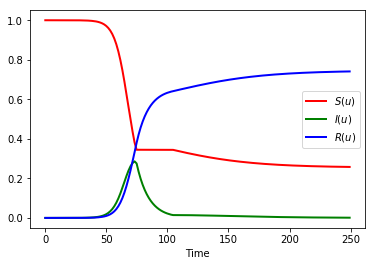

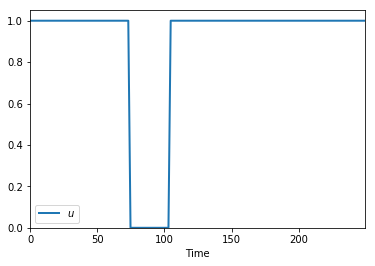

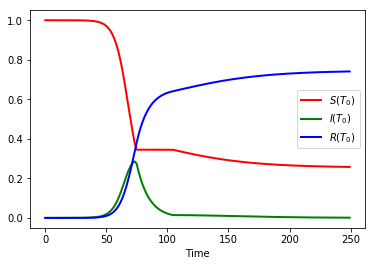

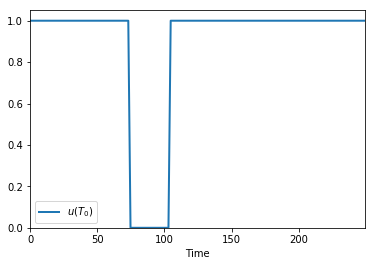

In [16]:
# minimisation with respect to u and T0 for alpha = 0 (figure 1)

# parameters
alpha  = 0.0
NT=int(5001) # number of time step
D=30
h = D/NT        #the time step
beta=0.29

# formula
S_inf1, T1, u1, Jval1, yval1 = exact_value_T(D,alpha,Init)

# we add a time interval of length T_end
T_end = 250-T1-D
NT_end=int(T_end/h)
u_end = np.ones(NT_end)
u1 = np.concatenate((u1,u_end),axis=0)
yval1 = RK4_state(u1,Init) 
tval_end1=np.linspace(0,T1+D+T_end,len(u1)) # discretized time interval [t0,t0+h,...,T]



# dichotomy
u2, Jval2, yval2, T2 = optimSIR_dic(alpha,D,Init)
# compute Sinf
S_inf2 = Dicho_S_inf(J(yval2))
# u=1 on the last interval
u2 = np.concatenate((u2,u_end),axis=0)
yval2 = RK4_state(u2,Init) 
tval_end2=np.linspace(0,T2+D+T_end,len(u2)) # discretized time interval [t0,t0+h,...,T]


# post processing - resultats et figures
print('T_max',T_max_ind(Init)*h)
print('J(u) by formula:',Jval1)
#print('number of iterations in the optimisation of T0:',i2)
print('J(u) by dichotomy:',Jval2)
print('T by formula:',T1)
print('T by dichotomy:',T2)
print('S_inf by formula',S_inf1)
print('S_inf by dichotomy',S_inf2)
S_herd=nu/beta
print('S_inf/S_herd by formula',S_inf1/S_herd)
print('S_inf/S_herd by dichotomy',S_inf2/S_herd)

# extract the values 
N_time=int(len(u1)/150.0)
yval1=yval1[::N_time,:]
yval2=yval2[::N_time,:]
u1=u1[::N_time]
u2=u2[::N_time]
tval_end1=tval_end1[::N_time]
tval_end2=tval_end2[::N_time]


#plot
plot_save_opt_sol(yval1,u1,yval2,u2,tval_end1,tval_end2,1)

('T_ind_max', 12391)
('T_max', 74.33113377324536)
('J(u) by formula:', 0.7410016896621586)
('J(u) by dichotomy:', 0.741001640042041)
('T by formula:', 72.10557888422316)
('T by dichotomy:', 72.09958008398321)
('S_inf by formula', 0.221981180481524)
('S_inf by dichotomy', 0.221981180481524)
('S_inf/S_herd by formula', 0.6437454233964195)
('S_inf/S_herd by dichotomy', 0.6437454233964195)


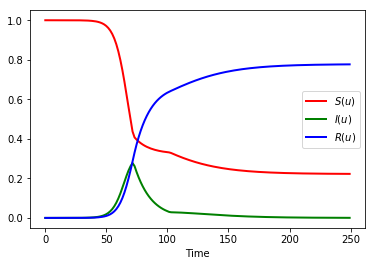

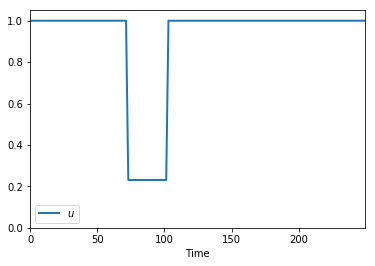

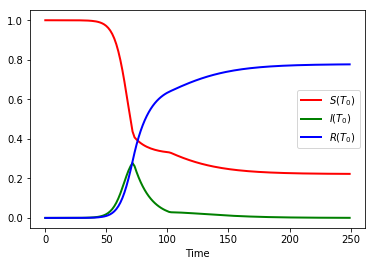

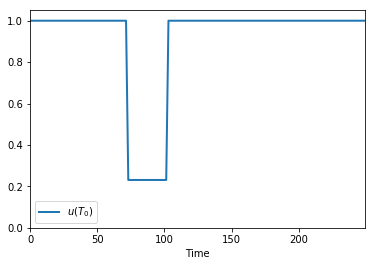

In [17]:
# minimisation with respect to u and T0 for alpha = 0.231 (figure 2 )

# parameters
alpha  = 0.231
NT=int(5001) # number of time step
D=30
h = D/NT        #the time step
beta=0.29

# formula
S_inf1, T1, u1, Jval1, yval1 = exact_value_T(D,alpha,Init)

# we add a time interval of length T_end
T_end = 250-T1-D
NT_end=int(T_end/h)
u_end = np.ones(NT_end)
u1 = np.concatenate((u1,u_end),axis=0)
yval1 = RK4_state(u1,Init) 
tval_end1=np.linspace(0,T1+D+T_end,len(u1)) # discretized time interval [t0,t0+h,...,T]



# dichotomy
u2, Jval2, yval2, T2 = optimSIR_dic(alpha,D,Init)
# compute Sinf
S_inf2 = Dicho_S_inf(J(yval2))
# u=1 on the last interval
u2 = np.concatenate((u2,u_end),axis=0)
yval2 = RK4_state(u2,Init) 
tval_end2=np.linspace(0,T2+D+T_end,len(u2)) # discretized time interval [t0,t0+h,...,T]


# post processing - resultats et figures
print('T_max',T_max_ind(Init)*h)
print('J(u) by formula:',Jval1)
#print('number of iterations in the optimisation of T0:',i2)
print('J(u) by dichotomy:',Jval2)
print('T by formula:',T1)
print('T by dichotomy:',T2)
print('S_inf by formula',S_inf1)
print('S_inf by dichotomy',S_inf2)
S_herd=nu/beta
print('S_inf/S_herd by formula',S_inf1/S_herd)
print('S_inf/S_herd by dichotomy',S_inf2/S_herd)

# extract the values 
N_time=int(len(u1)/150.0)
yval1=yval1[::N_time,:]
yval2=yval2[::N_time,:]
u1=u1[::N_time]
u2=u2[::N_time]
tval_end1=tval_end1[::N_time]
tval_end2=tval_end2[::N_time]


#plot
plot_save_opt_sol(yval1,u1,yval2,u2,tval_end1,tval_end2,2)

(6196, 5001)
('T_ind_max', 6196)
('T_max', 74.3371325734853)
('J(u) by formula:', 0.7126836213890874)
('J(u) by dichotomy:', 0.7126841081581439)
('T by formula:', 74.3371325734853)
('T by dichotomy:', 74.3131373725255)
('S_inf by formula', 0.32310485846143344)
('S_inf by dichotomy', 0.3230995968100478)
('S_inf/S_herd by formula', 0.937004089538157)
('S_inf/S_herd by dichotomy', 0.9369888307491385)


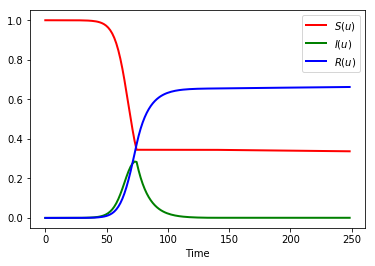

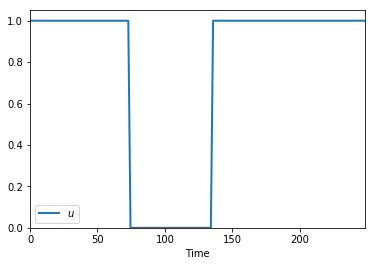

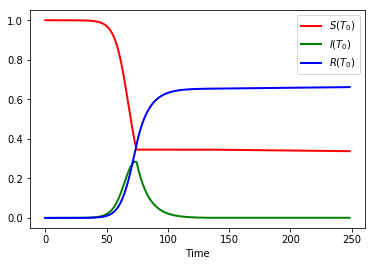

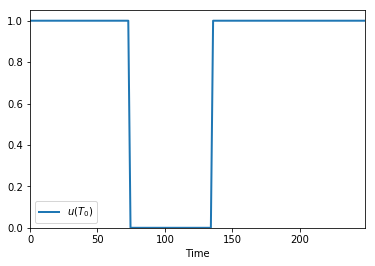

In [18]:
# minimisation with respect to u and T0 for alpha = 0 (figure 1)

# parameters
alpha  = 0.0
NT=int(5001) # number of time step
D=60
h = D/NT        #the time step
beta=0.29

# formula
S_inf1, T1, u1, Jval1, yval1 = exact_value_T(D,alpha,Init)

# we add a time interval of length T_end
T_end = 250-T1-D
NT_end=int(T_end/h)
u_end = np.ones(NT_end)
u1 = np.concatenate((u1,u_end),axis=0)
yval1 = RK4_state(u1,Init) 
tval_end1=np.linspace(0,T1+D+T_end,len(u1)) # discretized time interval [t0,t0+h,...,T]



# dichotomy
u2, Jval2, yval2, T2 = optimSIR_dic(alpha,D,Init)
# compute Sinf
S_inf2 = Dicho_S_inf(J(yval2))
# u=1 on the last interval
u2 = np.concatenate((u2,u_end),axis=0)
yval2 = RK4_state(u2,Init) 
tval_end2=np.linspace(0,T2+D+T_end,len(u2)) # discretized time interval [t0,t0+h,...,T]


# post processing - resultats et figures
print('T_max',T_max_ind(Init)*h)
print('J(u) by formula:',Jval1)
#print('number of iterations in the optimisation of T0:',i2)
print('J(u) by dichotomy:',Jval2)
print('T by formula:',T1)
print('T by dichotomy:',T2)
print('S_inf by formula',S_inf1)
print('S_inf by dichotomy',S_inf2)
S_herd=nu/beta
print('S_inf/S_herd by formula',S_inf1/S_herd)
print('S_inf/S_herd by dichotomy',S_inf2/S_herd)

# extract the values 
N_time=int(len(u1)/150.0)
yval1=yval1[::N_time,:]
yval2=yval2[::N_time,:]
u1=u1[::N_time]
u2=u2[::N_time]
tval_end1=tval_end1[::N_time]
tval_end2=tval_end2[::N_time]


#plot
plot_save_opt_sol(yval1,u1,yval2,u2,tval_end1,tval_end2,1)

('T_ind_max', 6196)
('T_max', 74.3371325734853)
('J(u) by formula:', 0.7149162102709903)
('J(u) by dichotomy:', 0.7149153212921888)
('T by formula:', 71.46970605878825)
('T by dichotomy:', 71.44571085782844)
('S_inf by formula', 0.30168993732202803)
('S_inf by dichotomy', 0.3016951989734136)
('S_inf/S_herd by formula', 0.8749008182338812)
('S_inf/S_herd by dichotomy', 0.8749160770228994)


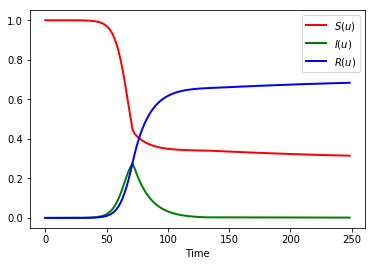

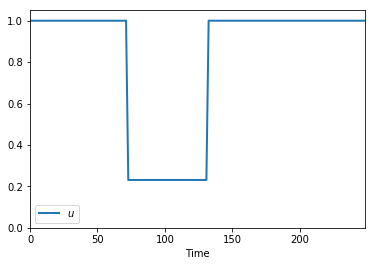

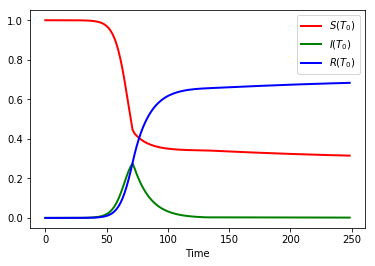

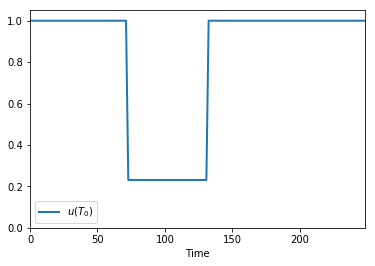

In [19]:
# minimisation with respect to u and T0 for alpha = 0 (figure 2)

# parameters
alpha  = 0.231
NT=int(5001) # number of time step
D=60
h = D/NT        #the time step
beta=0.29

# formula
S_inf1, T1, u1, Jval1, yval1 = exact_value_T(D,alpha,Init)

# we add a time interval of length T_end
T_end = 250-T1-D
NT_end=int(T_end/h)
u_end = np.ones(NT_end)
u1 = np.concatenate((u1,u_end),axis=0)
yval1 = RK4_state(u1,Init) 
tval_end1=np.linspace(0,T1+D+T_end,len(u1)) # discretized time interval [t0,t0+h,...,T]



# dichotomy
u2, Jval2, yval2, T2 = optimSIR_dic(alpha,D,Init)
# compute Sinf
S_inf2 = Dicho_S_inf(J(yval2))
# u=1 on the last interval
u2 = np.concatenate((u2,u_end),axis=0)
yval2 = RK4_state(u2,Init) 
tval_end2=np.linspace(0,T2+D+T_end,len(u2)) # discretized time interval [t0,t0+h,...,T]



# post processing - resultats et figures
print('T_max',T_max_ind(Init)*h)
print('J(u) by formula:',Jval1)
#print('number of iterations in the optimisation of T0:',i2)
print('J(u) by dichotomy:',Jval2)
print('T by formula:',T1)
print('T by dichotomy:',T2)
print('S_inf by formula',S_inf1)
print('S_inf by dichotomy',S_inf2)
S_herd=nu/beta
print('S_inf/S_herd by formula',S_inf1/S_herd)
print('S_inf/S_herd by dichotomy',S_inf2/S_herd)

# extract the values 
N_time=int(len(u1)/150.0)
yval1=yval1[::N_time,:]
yval2=yval2[::N_time,:]
u1=u1[::N_time]
u2=u2[::N_time]
tval_end1=tval_end1[::N_time]
tval_end2=tval_end2[::N_time]


#plot
plot_save_opt_sol(yval1,u1,yval2,u2,tval_end1,tval_end2,2)

(4131, 5001)
('T_ind_max', 4131)
('T_max', 74.34313137372526)
('J(u) by formula:', 0.712004849106803)
('J(u) by dichotomy:', 0.7120058411827834)
('T by formula:', 74.34313137372526)
('T by dichotomy:', 74.30713857228554)
('S_inf by formula', 0.3398947880328936)
('S_inf by dichotomy', 0.3398263865648807)
('S_inf/S_herd by formula', 0.9856948852953913)
('S_inf/S_herd by dichotomy', 0.9854965210381539)


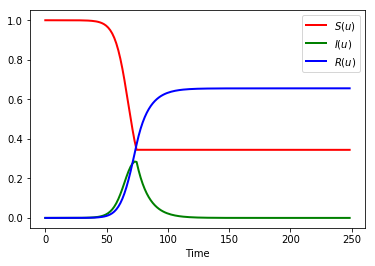

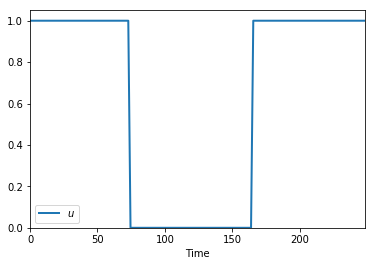

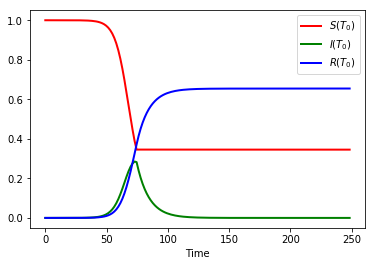

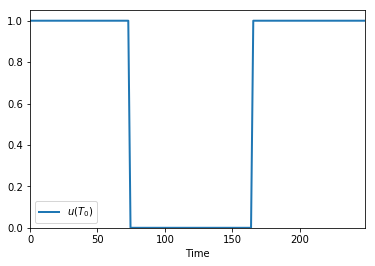

In [20]:
# minimisation with respect to u and T0 for alpha = 0 (figure 1)

# parameters
alpha  = 0.0
NT=int(5001) # number of time step
D=90
h = D/NT        #the time step
beta=0.29

# formula
S_inf1, T1, u1, Jval1, yval1 = exact_value_T(D,alpha,Init)

# we add a time interval of length T_end
T_end = 250-T1-D
NT_end=int(T_end/h)
u_end = np.ones(NT_end)
u1 = np.concatenate((u1,u_end),axis=0)
yval1 = RK4_state(u1,Init) 
tval_end1=np.linspace(0,T1+D+T_end,len(u1)) # discretized time interval [t0,t0+h,...,T]



# dichotomy
u2, Jval2, yval2, T2 = optimSIR_dic(alpha,D,Init)
# compute Sinf
S_inf2 = Dicho_S_inf(J(yval2))
# u=1 on the last interval
u2 = np.concatenate((u2,u_end),axis=0)
yval2 = RK4_state(u2,Init) 
tval_end2=np.linspace(0,T2+D+T_end,len(u2)) # discretized time interval [t0,t0+h,...,T]


# post processing - resultats et figures
print('T_max',T_max_ind(Init)*h)
print('J(u) by formula:',Jval1)
#print('number of iterations in the optimisation of T0:',i2)
print('J(u) by dichotomy:',Jval2)
print('T by formula:',T1)
print('T by dichotomy:',T2)
print('S_inf by formula',S_inf1)
print('S_inf by dichotomy',S_inf2)
S_herd=nu/beta
print('S_inf/S_herd by formula',S_inf1/S_herd)
print('S_inf/S_herd by dichotomy',S_inf2/S_herd) 

# extract the values 
N_time=int(len(u1)/150.0)
yval1=yval1[::N_time,:]
yval2=yval2[::N_time,:]
u1=u1[::N_time]
u2=u2[::N_time]
tval_end1=tval_end1[::N_time]
tval_end2=tval_end2[::N_time]


#plot
plot_save_opt_sol(yval1,u1,yval2,u2,tval_end1,tval_end2,1)

('T_ind_max', 4131)
('T_max', 74.34313137372526)
('J(u) by formula:', 0.71226663428517)
('J(u) by dichotomy:', 0.7122647571311282)
('T by formula:', 71.35572885422916)
('T by dichotomy:', 71.31973605278944)
('S_inf by formula', 0.33070268306224454)
('S_inf by dichotomy', 0.3307500379247149)
('S_inf/S_herd by formula', 0.9590377808805091)
('S_inf/S_herd by dichotomy', 0.9591751099816732)


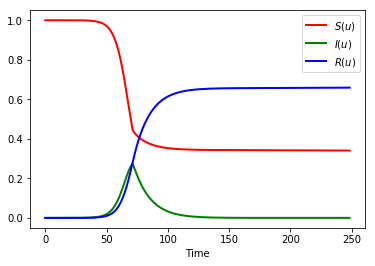

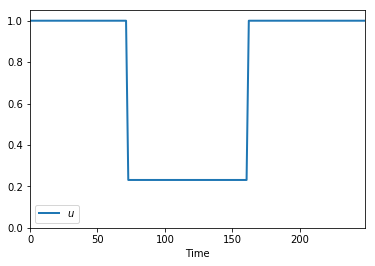

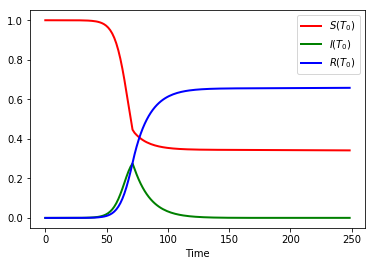

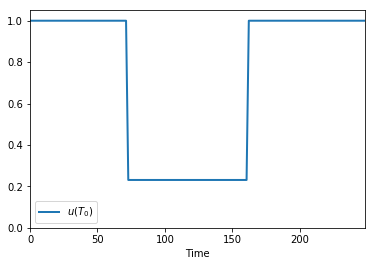

In [21]:
# minimisation with respect to u and T0 for alpha = 0.231 (figure 2)

# parameters
alpha  = 0.231
NT=int(5001) # number of time step
D=90
h = D/NT        #the time step
beta=0.29

# formula
S_inf1, T1, u1, Jval1, yval1 = exact_value_T(D,alpha,Init)

# we add a time interval of length T_end
T_end = 250-T1-D
NT_end=int(T_end/h)
u_end = np.ones(NT_end)
u1 = np.concatenate((u1,u_end),axis=0)
yval1 = RK4_state(u1,Init) 
tval_end1=np.linspace(0,T1+D+T_end,len(u1)) # discretized time interval [t0,t0+h,...,T]



# dichotomy
u2, Jval2, yval2, T2 = optimSIR_dic(alpha,D,Init)
# compute Sinf
S_inf2 = Dicho_S_inf(J(yval2))
# u=1 on the last interval
u2 = np.concatenate((u2,u_end),axis=0)
yval2 = RK4_state(u2,Init) 
tval_end2=np.linspace(0,T2+D+T_end,len(u2)) # discretized time interval [t0,t0+h,...,T]


# post processing - resultats et figures
print('T_max',T_max_ind(Init)*h)
print('J(u) by formula:',Jval1)
#print('number of iterations in the optimisation of T0:',i2)
print('J(u) by dichotomy:',Jval2)
print('T by formula:',T1)
print('T by dichotomy:',T2)
print('S_inf by formula',S_inf1)
print('S_inf by dichotomy',S_inf2)
S_herd=nu/beta
print('S_inf/S_herd by formula',S_inf1/S_herd)
print('S_inf/S_herd by dichotomy',S_inf2/S_herd)

# extract the values 
N_time=int(len(u1)/150.0)
yval1=yval1[::N_time,:]
yval2=yval2[::N_time,:]
u1=u1[::N_time]
u2=u2[::N_time]
tval_end1=tval_end1[::N_time]
tval_end2=tval_end2[::N_time]


#plot
plot_save_opt_sol(yval1,u1,yval2,u2,tval_end1,tval_end2,2)

##############################################
Iteration 1/50 and 1/6 and R0=1.5
##############################################
(611872, 5001)
('T=', 244.6998600279944)
('S_inf=', 0.43757883742045467)
##############################################
Iteration 2/50 and 1/6 and R0=1.5
##############################################
(202580, 5001)
('T=', 244.7007741308881)
('S_inf=', 0.4746729535757509)
##############################################
Iteration 3/50 and 1/6 and R0=1.5
##############################################
(121384, 5001)
('T=', 244.70083942395192)
('S_inf=', 0.5065383913534737)
##############################################
Iteration 4/50 and 1/6 and R0=1.5
##############################################
(86653, 5001)
('T=', 244.7015739709201)
('S_inf=', 0.533632914424811)
##############################################
Iteration 5/50 and 1/6 and R0=1.5
##############################################
(67375, 5001)
('T=', 244.7010597880424)
('S_inf=', 0.5564905804061494)
#

('T=', 244.7207864549539)
('S_inf=', 0.6665929158529752)
##############################################
Iteration 43/50 and 1/6 and R0=1.5
##############################################
(7127, 5001)
('T=', 244.71260033707543)
('S_inf=', 0.6666081746420148)
##############################################
Iteration 44/50 and 1/6 and R0=1.5
##############################################
(6963, 5001)
('T=', 244.70761357932489)
('S_inf=', 0.6665929158529752)
##############################################
Iteration 45/50 and 1/6 and R0=1.5
##############################################
(6807, 5001)
('T=', 244.72521822166178)
('S_inf=', 0.6666081746420148)
##############################################
Iteration 46/50 and 1/6 and R0=1.5
##############################################
(6657, 5001)
('T=', 244.71128631416573)
('S_inf=', 0.666613260905028)
##############################################
Iteration 47/50 and 1/6 and R0=1.5
##############################################
(6514, 5001)
('

('T=', 242.68997629045617)
('S_inf=', 0.6635258992560132)
##############################################
Iteration 37/50 and 2/6 and R0=1.5
##############################################
('T=', 242.68607502989192)
('S_inf=', 0.663592020675185)
##############################################
Iteration 38/50 and 2/6 and R0=1.5
##############################################
('T=', 242.73140473946026)
('S_inf=', 0.6633427937875379)
##############################################
Iteration 39/50 and 2/6 and R0=1.5
##############################################
('T=', 242.76658953923499)
('S_inf=', 0.6631495157930362)
##############################################
Iteration 40/50 and 2/6 and R0=1.5
##############################################
('T=', 242.7544695142604)
('S_inf=', 0.6632410685272737)
##############################################
Iteration 41/50 and 2/6 and R0=1.5
##############################################
('T=', 242.7495806961056)
('S_inf=', 0.6632817586313794)
##########

('T=', 238.15285922407352)
('S_inf=', 0.6584650675578753)
##############################################
Iteration 31/50 and 3/6 and R0=1.5
##############################################
('T=', 238.16994968353265)
('S_inf=', 0.6593755086372389)
##############################################
Iteration 32/50 and 3/6 and R0=1.5
##############################################
('T=', 238.16756648670264)
('S_inf=', 0.6601893107193516)
##############################################
Iteration 33/50 and 3/6 and R0=1.5
##############################################
('T=', 238.1679337601867)
('S_inf=', 0.6609064738042133)
##############################################
Iteration 34/50 and 3/6 and R0=1.5
##############################################
('T=', 238.135915674008)
('S_inf=', 0.6615727742589429)
##############################################
Iteration 35/50 and 3/6 and R0=1.5
##############################################
('T=', 238.1381682847104)
('S_inf=', 0.6621322631903953)
###########

('T=', 230.7310293043432)
('S_inf=', 0.6226577759449196)
##############################################
Iteration 25/50 and 4/6 and R0=1.5
##############################################
('T=', 230.57633371284925)
('S_inf=', 0.6259333293254229)
##############################################
Iteration 26/50 and 4/6 and R0=1.5
##############################################
('T=', 230.41057094703507)
('S_inf=', 0.628974914607319)
##############################################
Iteration 27/50 and 4/6 and R0=1.5
##############################################
('T=', 230.2640533117866)
('S_inf=', 0.6317927043166339)
##############################################
Iteration 28/50 and 4/6 and R0=1.5
##############################################
('T=', 230.13518112703989)
('S_inf=', 0.6344121297684339)
##############################################
Iteration 29/50 and 4/6 and R0=1.5
##############################################
('T=', 230.00942668609133)
('S_inf=', 0.636838277225732)
###########

('T=', 222.7542736350689)
('S_inf=', 0.5283228558390262)
##############################################
Iteration 19/50 and 5/6 and R0=1.5
##############################################
('T=', 221.79810568498542)
('S_inf=', 0.532661438189289)
##############################################
Iteration 20/50 and 5/6 and R0=1.5
##############################################
('T=', 220.8581140914674)
('S_inf=', 0.5368423463861428)
##############################################
Iteration 21/50 and 5/6 and R0=1.5
##############################################
('T=', 219.9327399826157)
('S_inf=', 0.5408604941665739)
##############################################
Iteration 22/50 and 5/6 and R0=1.5
##############################################
('T=', 219.02728025823404)
('S_inf=', 0.5447311403196219)
##############################################
Iteration 23/50 and 5/6 and R0=1.5
##############################################
('T=', 218.14783165815814)
('S_inf=', 0.5484593711083005)
###########

('T=', 228.7247693318479)
('S_inf=', 0.49444325790807475)
##############################################
Iteration 13/50 and 6/6 and R0=1.5
##############################################
('T=', 227.56248750249947)
('S_inf=', 0.49973297144180684)
##############################################
Iteration 14/50 and 6/6 and R0=1.5
##############################################
('T=', 226.42034858334452)
('S_inf=', 0.5048141481919975)
##############################################
Iteration 15/50 and 6/6 and R0=1.5
##############################################
('T=', 225.32607764161455)
('S_inf=', 0.5097020469476866)
##############################################
Iteration 16/50 and 6/6 and R0=1.5
##############################################
('T=', 224.23221478153346)
('S_inf=', 0.5144068402349002)
##############################################
Iteration 17/50 and 6/6 and R0=1.5
##############################################
('T=', 223.18979469412238)
('S_inf=', 0.5189285280536385)
######

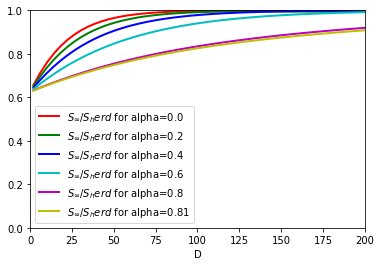

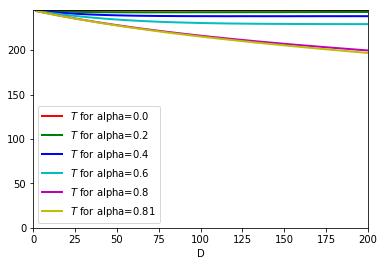

In [8]:
#graphique S infini et T en fonction de D (figure 3-4) 

# parameters
NT=int(5001) # number of time step
S_herd=nu/beta
min_D=2
max_D=200
nb_D = 50
D_array = np.linspace(min_D,max_D,nb_D)

color_plt=['r-','g-','b-','c-','m-','y-','b--','g--','r--']
color_tikz=['red','black!60!green','blue','brown',"orange",'black']
R0_array=[1.5, 2, 2.5, 3.5, 4.5, 6 ,8, 10]



#for ind_R0 in range(len(R0_array)):
ind_R0=0
RR0=R0_array[ind_R0]
S_herd=1.0/RR0
beta=RR0*nu
alpha_bar=(S_herd/(S0+I0-S_herd))*(np.log(S0)-np.log(S_herd))
alpha_array=[0.0,0.2,0.4,0.6,0.8,alpha_bar]
# Computation of T Sinf theoretical
S_inf_rel_theo_array =  np.zeros((len(D_array),len(alpha_array)))
T_theo_array =  np.zeros((len(D_array),len(alpha_array)))
for ind_alpha in range(len(alpha_array)):
    alpha = alpha_array[ind_alpha]
    for ind_D in range(len(D_array)):
        D = D_array[ind_D]
        h = D/NT        #the time step
        print('##############################################')
        print('Iteration '+str(ind_D+1)+'/'+str(len(D_array))+' and '+str(ind_alpha+1)+'/'+str(len(alpha_array))+" and R0="+str(RR0))
        print('##############################################')
        S_inf, T, u, Jval, yval = exact_value_T(D,alpha,Init)
        print('T=',T)
        print('S_inf=',S_inf)
        S_inf_rel_theo_array[ind_D,ind_alpha] = S_inf/S_herd
        T_theo_array[ind_D,ind_alpha] = T




# post processing - resultats et figures
# Plot
plt.figure(2*ind_R0+1)
for ind_alpha in range(len(alpha_array)):
    plt.plot(D_array,S_inf_rel_theo_array[:,ind_alpha],'{0}'.format(color_plt[ind_alpha]),linewidth=2,label=r'$S_\infty/S_herd$ for alpha={0}'.format(round(alpha_array[ind_alpha],2)))
plt.legend(loc='best')
plt.xlabel(r'D')
plt.axis([0, max(D_array),0.0, np.max(S_inf_rel_theo_array)])
plt.savefig("fig3_simu_covid_S_infinity_relative_with_respect_to_D_R0_{0}.png".format(10*RR0))
plt.figure(2*ind_R0+2)
for ind_alpha in range(len(alpha_array)):
    plt.plot(D_array,T_theo_array[:,ind_alpha],'{0}'.format(color_plt[ind_alpha]),linewidth=2,label=r'$T$ for alpha={0}'.format(round(alpha_array[ind_alpha],2)))
plt.legend(loc='best')
plt.xlabel(r'D')
plt.axis([0, max(D_array), 0.0, np.max(T_theo_array)])
plt.savefig("fig4_simu_covid_T_with_respect_to_D_R0_{0}.png".format(10*RR0))
plt.show()


# Save the values for tikz
File = open('fig3_simu_covid_S_infinity_with_respect_to_D_R0_{0}.txt'.format(10*RR0),'w')
for ind_alpha in range(len(alpha_array)):
    File.write('\\addplot[color={0}'.format(color_tikz[ind_alpha]))
    if alpha_array[ind_alpha]==alpha_array[-1]:
        File.write(' ,dashed,thick]coordinates { ')
    else:
        File.write(' ]coordinates { ')
    write_to_file(File,D_array,S_inf_rel_theo_array[:,ind_alpha])
    File.write(' };\n\n')
File.close()
File = open('fig4_simu_covid_T_with_respect_to_D_R0_{0}.txt'.format(10*RR0),'w')
for ind_alpha in range(len(alpha_array)):
    File.write('\\addplot[color={0}'.format(color_tikz[ind_alpha]))
    if alpha_array[ind_alpha]==alpha_array[-1]:
        File.write(' ,dashed,thick]coordinates { ')
    else:
        File.write(' ]coordinates { ')
    write_to_file(File,D_array,T_theo_array[:,ind_alpha])
    File.write(' };\n\n')
File.close()







##############################################
Iteration 1/50 and 1/6 and R0=2
##############################################
(332023, 5001)
('T=', 132.78264347130573)
('S_inf=', 0.22388839776902006)
##############################################
Iteration 2/50 and 1/6 and R0=2
##############################################
(109927, 5001)
('T=', 132.78320662398133)
('S_inf=', 0.26340103196733855)
##############################################
Iteration 3/50 and 1/6 and R0=2
##############################################
(65867, 5001)
('T=', 132.78282302723127)
('S_inf=', 0.2991371158802414)
##############################################
Iteration 4/50 and 1/6 and R0=2
##############################################
(47021, 5001)
('T=', 132.7837779382899)
('S_inf=', 0.33073806796547695)
##############################################
Iteration 5/50 and 1/6 and R0=2
##############################################
(36560, 5001)
('T=', 132.78323927051323)
('S_inf=', 0.3582115176175613)
######

('T=', 132.80436157666426)
('S_inf=', 0.4998817443850021)
##############################################
Iteration 43/50 and 1/6 and R0=2
##############################################
(3868, 5001)
('T=', 132.81160910675007)
('S_inf=', 0.4998054504398422)
##############################################
Iteration 44/50 and 1/6 and R0=2
##############################################
(3779, 5001)
('T=', 132.80914429359024)
('S_inf=', 0.49985122680693816)
##############################################
Iteration 45/50 and 1/6 and R0=2
##############################################
(3694, 5001)
('T=', 132.80666315716448)
('S_inf=', 0.49988937377951814)
##############################################
Iteration 46/50 and 1/6 and R0=2
##############################################
(3613, 5001)
('T=', 132.81386171745243)
('S_inf=', 0.4997978210453262)
##############################################
Iteration 47/50 and 1/6 and R0=2
##############################################
(3535, 5001)
('T=', 1

('T=', 130.465221241466)
('S_inf=', 0.49704360962505345)
##############################################
Iteration 37/50 and 2/6 and R0=2
##############################################
('T=', 130.45482332105004)
('S_inf=', 0.4972724914605332)
##############################################
Iteration 38/50 and 2/6 and R0=2
##############################################
('T=', 130.4544968557309)
('S_inf=', 0.4973411560111771)
##############################################
Iteration 39/50 and 2/6 and R0=2
##############################################
('T=', 130.4501058971879)
('S_inf=', 0.497447967534401)
##############################################
Iteration 40/50 and 2/6 and R0=2
##############################################
('T=', 130.4881064603406)
('S_inf=', 0.49692916870731363)
##############################################
Iteration 41/50 and 2/6 and R0=2
##############################################
('T=', 130.48730662030854)
('S_inf=', 0.4969673156798935)
#####################

('T=', 126.05808634191528)
('S_inf=', 0.48996353151421357)
##############################################
Iteration 32/50 and 3/6 and R0=2
##############################################
('T=', 126.01835551257095)
('S_inf=', 0.4911231994806442)
##############################################
Iteration 33/50 and 3/6 and R0=2
##############################################
('T=', 126.00241584336193)
('S_inf=', 0.49213027955675503)
##############################################
Iteration 34/50 and 3/6 and R0=2
##############################################
('T=', 126.00986741427222)
('S_inf=', 0.49301528932061)
##############################################
Iteration 35/50 and 3/6 and R0=2
##############################################
('T=', 126.00920632200089)
('S_inf=', 0.49380874635027305)
##############################################
Iteration 36/50 and 3/6 and R0=2
##############################################
('T=', 126.04850458479731)
('S_inf=', 0.4944267273060684)
################

('T=', 117.48158123477344)
('S_inf=', 0.44442367564826213)
##############################################
Iteration 27/50 and 4/6 and R0=2
##############################################
('T=', 117.25141502311781)
('S_inf=', 0.4482383729062577)
##############################################
Iteration 28/50 and 4/6 and R0=2
##############################################
('T=', 117.07813539332949)
('S_inf=', 0.4518089295397415)
##############################################
Iteration 29/50 and 4/6 and R0=2
##############################################
('T=', 116.86965464050046)
('S_inf=', 0.45516586312677765)
##############################################
Iteration 30/50 and 4/6 and R0=2
##############################################
('T=', 116.70514876616512)
('S_inf=', 0.45830154427285)
##############################################
Iteration 31/50 and 4/6 and R0=2
##############################################
('T=', 116.52241796538651)
('S_inf=', 0.4612388611615066)
#################

('T=', 107.70593636374765)
('S_inf=', 0.3202018741388932)
##############################################
Iteration 22/50 and 5/6 and R0=2
##############################################
('T=', 106.69134744479675)
('S_inf=', 0.32307815587142186)
##############################################
Iteration 23/50 and 5/6 and R0=2
##############################################
('T=', 105.63866002309742)
('S_inf=', 0.3257637027410508)
##############################################
Iteration 24/50 and 5/6 and R0=2
##############################################
('T=', 104.60161029018685)
('S_inf=', 0.3282661441422958)
##############################################
Iteration 25/50 and 5/6 and R0=2
##############################################
('T=', 103.59111851099166)
('S_inf=', 0.33060073886418906)
##############################################
Iteration 26/50 and 5/6 and R0=2
##############################################
('T=', 102.54660904553782)
('S_inf=', 0.3327751163012467)
###############

('T=', 117.31188456186312)
('S_inf=', 0.35330581694377894)
##############################################
Iteration 17/50 and 6/6 and R0=2
##############################################
('T=', 116.59287734289875)
('S_inf=', 0.3595390322633438)
##############################################
Iteration 18/50 and 6/6 and R0=2
##############################################
('T=', 115.88650433178671)
('S_inf=', 0.3654594424077531)
##############################################
Iteration 19/50 and 6/6 and R0=2
##############################################
('T=', 115.18796648833498)
('S_inf=', 0.3710899355605546)
##############################################
Iteration 20/50 and 6/6 and R0=2
##############################################
('T=', 114.50093654738438)
('S_inf=', 0.37644577051078043)
##############################################
Iteration 21/50 and 6/6 and R0=2
##############################################
('T=', 113.84967904378307)
('S_inf=', 0.38154220604746253)
##############

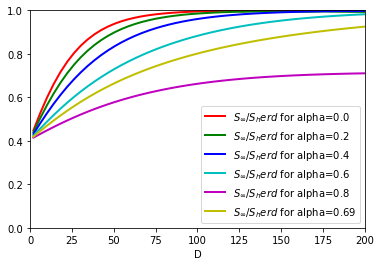

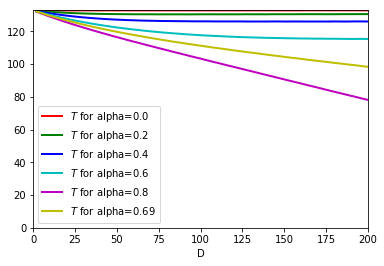

In [9]:
#graphique S infini et T en fonction de D (figure 3-4) 

# parameters
NT=int(5001) # number of time step
S_herd=nu/beta
min_D=2
max_D=200
nb_D = 50
D_array = np.linspace(min_D,max_D,nb_D)

color_plt=['r-','g-','b-','c-','m-','y-','b--','g--','r--']
color_tikz=['red','black!60!green','blue','brown',"orange",'black']
R0_array=[1.5, 2, 2.5, 3.5, 4.5, 6 ,8, 10]



#for ind_R0 in range(len(R0_array)):
ind_R0=1
RR0=R0_array[ind_R0]
S_herd=1.0/RR0
beta=RR0*nu
alpha_bar=(S_herd/(S0+I0-S_herd))*(np.log(S0)-np.log(S_herd))
alpha_array=[0.0,0.2,0.4,0.6,0.8,alpha_bar]
# Computation of T Sinf theoretical
S_inf_rel_theo_array =  np.zeros((len(D_array),len(alpha_array)))
T_theo_array =  np.zeros((len(D_array),len(alpha_array)))
for ind_alpha in range(len(alpha_array)):
    alpha = alpha_array[ind_alpha]
    for ind_D in range(len(D_array)):
        D = D_array[ind_D]
        h = D/NT        #the time step
        print('##############################################')
        print('Iteration '+str(ind_D+1)+'/'+str(len(D_array))+' and '+str(ind_alpha+1)+'/'+str(len(alpha_array))+" and R0="+str(RR0))
        print('##############################################')
        S_inf, T, u, Jval, yval = exact_value_T(D,alpha,Init)
        print('T=',T)
        print('S_inf=',S_inf)
        S_inf_rel_theo_array[ind_D,ind_alpha] = S_inf/S_herd
        T_theo_array[ind_D,ind_alpha] = T




# post processing - resultats et figures
# Plot
plt.figure(2*ind_R0+1)
for ind_alpha in range(len(alpha_array)):
    plt.plot(D_array,S_inf_rel_theo_array[:,ind_alpha],'{0}'.format(color_plt[ind_alpha]),linewidth=2,label=r'$S_\infty/S_herd$ for alpha={0}'.format(round(alpha_array[ind_alpha],2)))
plt.legend(loc='best')
plt.xlabel(r'D')
plt.axis([0, max(D_array),0.0, np.max(S_inf_rel_theo_array)])
plt.savefig("fig3_simu_covid_S_infinity_relative_with_respect_to_D_R0_{0}.png".format(10*RR0))
plt.figure(2*ind_R0+2)
for ind_alpha in range(len(alpha_array)):
    plt.plot(D_array,T_theo_array[:,ind_alpha],'{0}'.format(color_plt[ind_alpha]),linewidth=2,label=r'$T$ for alpha={0}'.format(round(alpha_array[ind_alpha],2)))
plt.legend(loc='best')
plt.xlabel(r'D')
plt.axis([0, max(D_array), 0.0, np.max(T_theo_array)])
plt.savefig("fig4_simu_covid_T_with_respect_to_D_R0_{0}.png".format(10*RR0))
plt.show()


# Save the values for tikz
File = open('fig3_simu_covid_S_infinity_with_respect_to_D_R0_{0}.txt'.format(10*RR0),'w')
for ind_alpha in range(len(alpha_array)):
    File.write('\\addplot[color={0}'.format(color_tikz[ind_alpha]))
    if alpha_array[ind_alpha]==alpha_array[-1]:
        File.write(' ,dashed,thick]coordinates { ')
    else:
        File.write(' ]coordinates { ')
    write_to_file(File,D_array,S_inf_rel_theo_array[:,ind_alpha])
    File.write(' };\n\n')
File.close()
File = open('fig4_simu_covid_T_with_respect_to_D_R0_{0}.txt'.format(10*RR0),'w')
for ind_alpha in range(len(alpha_array)):
    File.write('\\addplot[color={0}'.format(color_tikz[ind_alpha]))
    if alpha_array[ind_alpha]==alpha_array[-1]:
        File.write(' ,dashed,thick]coordinates { ')
    else:
        File.write(' ]coordinates { ')
    write_to_file(File,D_array,T_theo_array[:,ind_alpha])
    File.write(' };\n\n')
File.close()







##############################################
Iteration 1/50 and 1/6 and R0=2.5
##############################################
(230457, 5001)
('T=', 92.16436712657467)
('S_inf=', 0.12458801338384248)
##############################################
Iteration 2/50 and 1/6 and R0=2.5
##############################################
(76300, 5001)
('T=', 92.16442425800554)
('S_inf=', 0.15926208556278232)
##############################################
Iteration 3/50 and 1/6 and R0=2.5
##############################################
(45719, 5001)
('T=', 92.16599945317058)
('S_inf=', 0.19235534719879913)
##############################################
Iteration 4/50 and 1/6 and R0=2.5
##############################################
(32637, 5001)
('T=', 92.16444058127149)
('S_inf=', 0.2227874760289688)
##############################################
Iteration 5/50 and 1/6 and R0=2.5
##############################################
(25377, 5001)
('T=', 92.16740325404307)
('S_inf=', 0.25003967322646337)


('T=', 92.16843978143146)
('S_inf=', 0.3996917724617081)
##############################################
Iteration 43/50 and 1/6 and R0=2.5
##############################################
(2685, 5001)
('T=', 92.19213300197103)
('S_inf=', 0.3997344970709763)
##############################################
Iteration 44/50 and 1/6 and R0=2.5
##############################################
(2623, 5001)
('T=', 92.1826899926137)
('S_inf=', 0.39992980957048796)
##############################################
Iteration 45/50 and 1/6 and R0=2.5
##############################################
(2564, 5001)
('T=', 92.18091075662419)
('S_inf=', 0.3999420166017075)
##############################################
Iteration 46/50 and 1/6 and R0=2.5
##############################################
(2508, 5001)
('T=', 92.19406730898717)
('S_inf=', 0.3997283935553666)
##############################################
Iteration 47/50 and 1/6 and R0=2.5
##############################################
(2454, 5001)
('T='

('T=', 89.76833204787613)
('S_inf=', 0.3972137451241531)
##############################################
Iteration 37/50 and 2/6 and R0=2.5
##############################################
('T=', 89.76141098310949)
('S_inf=', 0.3974578857485428)
##############################################
Iteration 38/50 and 2/6 and R0=2.5
##############################################
('T=', 89.76699354006749)
('S_inf=', 0.39742736817049407)
##############################################
Iteration 39/50 and 2/6 and R0=2.5
##############################################
('T=', 89.76609576043974)
('S_inf=', 0.39751281738903044)
##############################################
Iteration 40/50 and 2/6 and R0=2.5
##############################################
('T=', 89.76841366420592)
('S_inf=', 0.3975067138734207)
##############################################
Iteration 41/50 and 2/6 and R0=2.5
##############################################
('T=', 89.75092328473079)
('S_inf=', 0.3979278564504928)
###########

('T=', 85.24695060987801)
('S_inf=', 0.38711853030564114)
##############################################
Iteration 31/50 and 3/6 and R0=2.5
##############################################
('T=', 85.2296561095944)
('S_inf=', 0.38857116702075956)
##############################################
Iteration 32/50 and 3/6 and R0=2.5
##############################################
('T=', 85.22525698941844)
('S_inf=', 0.38985290529880523)
##############################################
Iteration 33/50 and 3/6 and R0=2.5
##############################################
('T=', 85.22688931601434)
('S_inf=', 0.3909820556866073)
##############################################
Iteration 34/50 and 3/6 and R0=2.5
##############################################
('T=', 85.22445714938644)
('S_inf=', 0.3919891357622146)
##############################################
Iteration 35/50 and 3/6 and R0=2.5
##############################################
('T=', 85.23250451950426)
('S_inf=', 0.3928558349787979)
###########

('T=', 75.64487102579483)
('S_inf=', 0.3236663820267715)
##############################################
Iteration 26/50 and 4/6 and R0=2.5
##############################################
('T=', 75.23105991046688)
('S_inf=', 0.3277618410009079)
##############################################
Iteration 27/50 and 4/6 and R0=2.5
##############################################
('T=', 74.79942378871164)
('S_inf=', 0.33164978044431304)
##############################################
Iteration 28/50 and 4/6 and R0=2.5
##############################################
('T=', 74.42348265040869)
('S_inf=', 0.3353424073882065)
##############################################
Iteration 29/50 and 4/6 and R0=2.5
##############################################
('T=', 74.02205273231067)
('S_inf=', 0.33884582534819796)
##############################################
Iteration 30/50 and 4/6 and R0=2.5
##############################################
('T=', 73.61695007937188)
('S_inf=', 0.34217224135550683)
##########

('T=', 69.87791013225926)
('S_inf=', 0.19010314993880467)
##############################################
Iteration 20/50 and 5/6 and R0=2.5
##############################################
('T=', 68.82027676097432)
('S_inf=', 0.1917388921222153)
##############################################
Iteration 21/50 and 5/6 and R0=2.5
##############################################
('T=', 67.77988892017514)
('S_inf=', 0.19318542532172397)
##############################################
Iteration 22/50 and 5/6 and R0=2.5
##############################################
('T=', 66.74505098980204)
('S_inf=', 0.1944610600841599)
##############################################
Iteration 23/50 and 5/6 and R0=2.5
##############################################
('T=', 65.70608327314129)
('S_inf=', 0.19558410695635225)
##############################################
Iteration 24/50 and 5/6 and R0=2.5
##############################################
('T=', 64.67834596346036)
('S_inf=', 0.19657287648513036)
#########

('T=', 81.36318042513945)
('S_inf=', 0.2481048587781754)
##############################################
Iteration 14/50 and 6/6 and R0=2.5
##############################################
('T=', 80.72188011377315)
('S_inf=', 0.2559356693054734)
##############################################
Iteration 15/50 and 6/6 and R0=2.5
##############################################
('T=', 80.13311623389608)
('S_inf=', 0.26332702670887)
##############################################
Iteration 16/50 and 6/6 and R0=2.5
##############################################
('T=', 79.53921052524188)
('S_inf=', 0.2702972415351944)
##############################################
Iteration 17/50 and 6/6 and R0=2.5
##############################################
('T=', 78.98141188088911)
('S_inf=', 0.2768768313624955)
##############################################
Iteration 18/50 and 6/6 and R0=2.5
##############################################
('T=', 78.41210533403523)
('S_inf=', 0.2830963137688217)
###############

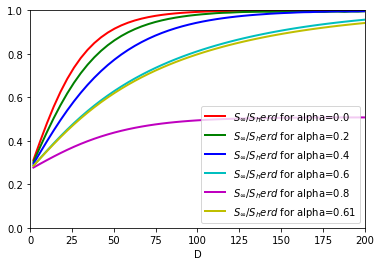

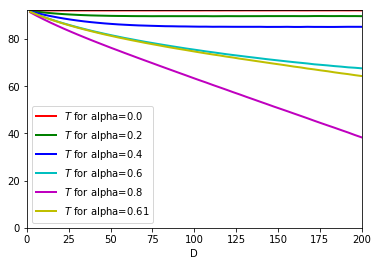

In [10]:
#graphique S infini et T en fonction de D (figure 3-4) 

# parameters
NT=int(5001) # number of time step
S_herd=nu/beta
min_D=2
max_D=200
nb_D = 50
D_array = np.linspace(min_D,max_D,nb_D)

color_plt=['r-','g-','b-','c-','m-','y-','b--','g--','r--']
color_tikz=['red','black!60!green','blue','brown',"orange",'black']
R0_array=[1.5, 2, 2.5, 3.5, 4.5, 6 ,8, 10]



#for ind_R0 in range(len(R0_array)):
ind_R0=2
RR0=R0_array[ind_R0]
S_herd=1.0/RR0
beta=RR0*nu
alpha_bar=(S_herd/(S0+I0-S_herd))*(np.log(S0)-np.log(S_herd))
alpha_array=[0.0,0.2,0.4,0.6,0.8,alpha_bar]
# Computation of T Sinf theoretical
S_inf_rel_theo_array =  np.zeros((len(D_array),len(alpha_array)))
T_theo_array =  np.zeros((len(D_array),len(alpha_array)))
for ind_alpha in range(len(alpha_array)):
    alpha = alpha_array[ind_alpha]
    for ind_D in range(len(D_array)):
        D = D_array[ind_D]
        h = D/NT        #the time step
        print('##############################################')
        print('Iteration '+str(ind_D+1)+'/'+str(len(D_array))+' and '+str(ind_alpha+1)+'/'+str(len(alpha_array))+" and R0="+str(RR0))
        print('##############################################')
        S_inf, T, u, Jval, yval = exact_value_T(D,alpha,Init)
        print('T=',T)
        print('S_inf=',S_inf)
        S_inf_rel_theo_array[ind_D,ind_alpha] = S_inf/S_herd
        T_theo_array[ind_D,ind_alpha] = T




# post processing - resultats et figures
# Plot
plt.figure(2*ind_R0+1)
for ind_alpha in range(len(alpha_array)):
    plt.plot(D_array,S_inf_rel_theo_array[:,ind_alpha],'{0}'.format(color_plt[ind_alpha]),linewidth=2,label=r'$S_\infty/S_herd$ for alpha={0}'.format(round(alpha_array[ind_alpha],2)))
plt.legend(loc='best')
plt.xlabel(r'D')
plt.axis([0, max(D_array),0.0, np.max(S_inf_rel_theo_array)])
plt.savefig("fig3_simu_covid_S_infinity_relative_with_respect_to_D_R0_{0}.png".format(10*RR0))
plt.figure(2*ind_R0+2)
for ind_alpha in range(len(alpha_array)):
    plt.plot(D_array,T_theo_array[:,ind_alpha],'{0}'.format(color_plt[ind_alpha]),linewidth=2,label=r'$T$ for alpha={0}'.format(round(alpha_array[ind_alpha],2)))
plt.legend(loc='best')
plt.xlabel(r'D')
plt.axis([0, max(D_array), 0.0, np.max(T_theo_array)])
plt.savefig("fig4_simu_covid_T_with_respect_to_D_R0_{0}.png".format(10*RR0))
plt.show()


# Save the values for tikz
File = open('fig3_simu_covid_S_infinity_with_respect_to_D_R0_{0}.txt'.format(10*RR0),'w')
for ind_alpha in range(len(alpha_array)):
    File.write('\\addplot[color={0}'.format(color_tikz[ind_alpha]))
    if alpha_array[ind_alpha]==alpha_array[-1]:
        File.write(' ,dashed,thick]coordinates { ')
    else:
        File.write(' ]coordinates { ')
    write_to_file(File,D_array,S_inf_rel_theo_array[:,ind_alpha])
    File.write(' };\n\n')
File.close()
File = open('fig4_simu_covid_T_with_respect_to_D_R0_{0}.txt'.format(10*RR0),'w')
for ind_alpha in range(len(alpha_array)):
    File.write('\\addplot[color={0}'.format(color_tikz[ind_alpha]))
    if alpha_array[ind_alpha]==alpha_array[-1]:
        File.write(' ,dashed,thick]coordinates { ')
    else:
        File.write(' ]coordinates { ')
    write_to_file(File,D_array,T_theo_array[:,ind_alpha])
    File.write(' };\n\n')
File.close()







##############################################
Iteration 1/50 and 1/6 and R0=3.5
##############################################
(144531, 5001)
('T=', 57.80083983203359)
('S_inf=', 0.044185094316334314)
##############################################
Iteration 2/50 and 1/6 and R0=3.5
##############################################
(47852, 5001)
('T=', 57.80146827777302)
('S_inf=', 0.06726510260608999)
##############################################
Iteration 3/50 and 1/6 and R0=3.5
##############################################
(28673, 5001)
('T=', 57.802570098225246)
('S_inf=', 0.09201049872483827)
##############################################
Iteration 4/50 and 1/6 and R0=3.5
##############################################
(20469, 5001)
('T=', 57.802921048443366)
('S_inf=', 0.11669485968755014)
##############################################
Iteration 5/50 and 1/6 and R0=3.5
##############################################
(15915, 5001)
('T=', 57.802113046778395)
('S_inf=', 0.14013235960551

('T=', 57.802251794539046)
('S_inf=', 0.2851606096559557)
##############################################
Iteration 43/50 and 1/6 and R0=3.5
##############################################
(1684, 5001)
('T=', 57.82180706715799)
('S_inf=', 0.28555297851618955)
##############################################
Iteration 44/50 and 1/6 and R0=3.5
##############################################
(1645, 5001)
('T=', 57.811866198188916)
('S_inf=', 0.2854745047441428)
##############################################
Iteration 45/50 and 1/6 and R0=3.5
##############################################
(1608, 5001)
('T=', 57.81080518590159)
('S_inf=', 0.2854221888961116)
##############################################
Iteration 46/50 and 1/6 and R0=3.5
##############################################
(1573, 5001)
('T=', 57.823472040285814)
('S_inf=', 0.28555297851618955)
##############################################
Iteration 47/50 and 1/6 and R0=3.5
##############################################
(1539, 5001)


('T=', 55.29499814322849)
('S_inf=', 0.2841404506193477)
##############################################
Iteration 37/50 and 2/6 and R0=3.5
##############################################
('T=', 55.31945039563515)
('S_inf=', 0.28386143276318143)
##############################################
Iteration 38/50 and 2/6 and R0=3.5
##############################################
('T=', 55.320462438124615)
('S_inf=', 0.28396606445924377)
##############################################
Iteration 39/50 and 2/6 and R0=3.5
##############################################
('T=', 55.33398626397169)
('S_inf=', 0.28367832729507225)
##############################################
Iteration 40/50 and 2/6 and R0=3.5
##############################################
('T=', 55.33538190321119)
('S_inf=', 0.28370448521908775)
##############################################
Iteration 41/50 and 2/6 and R0=3.5
##############################################
('T=', 55.32949736583294)
('S_inf=', 0.28393990653522816)
#######

('T=', 50.2377891768585)
('S_inf=', 0.2707301549073551)
##############################################
Iteration 31/50 and 3/6 and R0=3.5
##############################################
('T=', 50.26553872898889)
('S_inf=', 0.2723606655043269)
##############################################
Iteration 32/50 and 3/6 and R0=3.5
##############################################
('T=', 50.2088480263131)
('S_inf=', 0.27386910578922596)
##############################################
Iteration 33/50 and 3/6 and R0=3.5
##############################################
('T=', 50.227676913596866)
('S_inf=', 0.2751770019900055)
##############################################
Iteration 34/50 and 3/6 and R0=3.5
##############################################
('T=', 50.20367355100407)
('S_inf=', 0.27636282787871225)
##############################################
Iteration 35/50 and 3/6 and R0=3.5
##############################################
('T=', 50.225301878399826)
('S_inf=', 0.2773655482993099)
###########

('T=', 40.075135993209514)
('S_inf=', 0.16596766922491674)
##############################################
Iteration 25/50 and 4/6 and R0=3.5
##############################################
('T=', 39.40579231092557)
('S_inf=', 0.16754586397385735)
##############################################
Iteration 26/50 and 4/6 and R0=3.5
##############################################
('T=', 38.76912780709164)
('S_inf=', 0.16894095325468883)
##############################################
Iteration 27/50 and 4/6 and R0=3.5
##############################################
('T=', 38.10617468343066)
('S_inf=', 0.17016165637541636)
##############################################
Iteration 28/50 and 4/6 and R0=3.5
##############################################
('T=', 37.433900974907054)
('S_inf=', 0.17122541195205038)
##############################################
Iteration 29/50 and 4/6 and R0=3.5
##############################################
('T=', 36.81532264975576)
('S_inf=', 0.17215837790860639)
#####

('T=', 38.83145003652331)
('S_inf=', 0.07303728450553021)
##############################################
Iteration 19/50 and 5/6 and R0=3.5
##############################################
('T=', 37.912801113246736)
('S_inf=', 0.07342093405775886)
##############################################
Iteration 20/50 and 5/6 and R0=3.5
##############################################
('T=', 37.00133442699215)
('S_inf=', 0.07373482914594595)
##############################################
Iteration 21/50 and 5/6 and R0=3.5
##############################################
('T=', 36.10069822770139)
('S_inf=', 0.07398768907809665)
##############################################
Iteration 22/50 and 5/6 and R0=3.5
##############################################
('T=', 35.20484474533664)
('S_inf=', 0.07418823316221619)
##############################################
Iteration 23/50 and 5/6 and R0=3.5
##############################################
('T=', 34.31620614652579)
('S_inf=', 0.07435390001431492)
######

('T=', 50.14557904745582)
('S_inf=', 0.15474591982222863)
##############################################
Iteration 13/50 and 6/6 and R0=3.5
##############################################
('T=', 49.68212071871339)
('S_inf=', 0.16281999903504074)
##############################################
Iteration 14/50 and 6/6 and R0=3.5
##############################################
('T=', 49.24220053948393)
('S_inf=', 0.17041451630756704)
##############################################
Iteration 15/50 and 6/6 and R0=3.5
##############################################
('T=', 48.803667837861)
('S_inf=', 0.17754691025581792)
##############################################
Iteration 16/50 and 6/6 and R0=3.5
##############################################
('T=', 48.38958738864471)
('S_inf=', 0.18423461949580383)
##############################################
Iteration 17/50 and 6/6 and R0=3.5
##############################################
('T=', 47.96728001338507)
('S_inf=', 0.1905125212595455)
##########

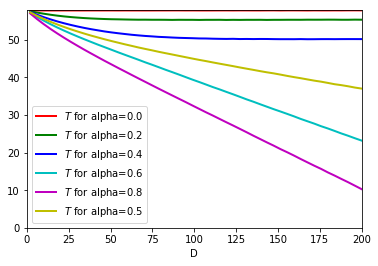

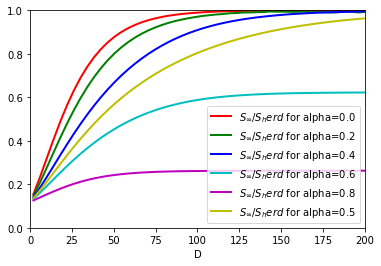

In [11]:
#graphique S infini et T en fonction de D (figure 3-4) 

# parameters
NT=int(5001) # number of time step
S_herd=nu/beta
min_D=2
max_D=200
nb_D = 50
D_array = np.linspace(min_D,max_D,nb_D)

color_plt=['r-','g-','b-','c-','m-','y-','b--','g--','r--']
color_tikz=['red','black!60!green','blue','brown',"orange",'black']
R0_array=[1.5, 2, 2.5, 3.5, 4.5, 6 ,8, 10]



#for ind_R0 in range(len(R0_array)):
ind_R0=3
RR0=R0_array[ind_R0]
S_herd=1.0/RR0
beta=RR0*nu
alpha_bar=(S_herd/(S0+I0-S_herd))*(np.log(S0)-np.log(S_herd))
alpha_array=[0.0,0.2,0.4,0.6,0.8,alpha_bar]
# Computation of T Sinf theoretical
S_inf_rel_theo_array =  np.zeros((len(D_array),len(alpha_array)))
T_theo_array =  np.zeros((len(D_array),len(alpha_array)))
for ind_alpha in range(len(alpha_array)):
    alpha = alpha_array[ind_alpha]
    for ind_D in range(len(D_array)):
        D = D_array[ind_D]
        h = D/NT        #the time step
        print('##############################################')
        print('Iteration '+str(ind_D+1)+'/'+str(len(D_array))+' and '+str(ind_alpha+1)+'/'+str(len(alpha_array))+" and R0="+str(RR0))
        print('##############################################')
        S_inf, T, u, Jval, yval = exact_value_T(D,alpha,Init)
        print('T=',T)
        print('S_inf=',S_inf)
        S_inf_rel_theo_array[ind_D,ind_alpha] = S_inf/S_herd
        T_theo_array[ind_D,ind_alpha] = T




# post processing - resultats et figures
# Plot
plt.figure(2*ind_R0+1)
for ind_alpha in range(len(alpha_array)):
    plt.plot(D_array,S_inf_rel_theo_array[:,ind_alpha],'{0}'.format(color_plt[ind_alpha]),linewidth=2,label=r'$S_\infty/S_herd$ for alpha={0}'.format(round(alpha_array[ind_alpha],2)))
plt.legend(loc='best')
plt.xlabel(r'D')
plt.axis([0, max(D_array),0.0, np.max(S_inf_rel_theo_array)])
plt.savefig("fig3_simu_covid_S_infinity_relative_with_respect_to_D_R0_{0}.png".format(10*RR0))
plt.figure(2*ind_R0+2)
for ind_alpha in range(len(alpha_array)):
    plt.plot(D_array,T_theo_array[:,ind_alpha],'{0}'.format(color_plt[ind_alpha]),linewidth=2,label=r'$T$ for alpha={0}'.format(round(alpha_array[ind_alpha],2)))
plt.legend(loc='best')
plt.xlabel(r'D')
plt.axis([0, max(D_array), 0.0, np.max(T_theo_array)])
plt.savefig("fig4_simu_covid_T_with_respect_to_D_R0_{0}.png".format(10*RR0))
plt.show()


# Save the values for tikz
File = open('fig3_simu_covid_S_infinity_with_respect_to_D_R0_{0}.txt'.format(10*RR0),'w')
for ind_alpha in range(len(alpha_array)):
    File.write('\\addplot[color={0}'.format(color_tikz[ind_alpha]))
    if alpha_array[ind_alpha]==alpha_array[-1]:
        File.write(' ,dashed,thick]coordinates { ')
    else:
        File.write(' ]coordinates { ')
    write_to_file(File,D_array,S_inf_rel_theo_array[:,ind_alpha])
    File.write(' };\n\n')
File.close()
File = open('fig4_simu_covid_T_with_respect_to_D_R0_{0}.txt'.format(10*RR0),'w')
for ind_alpha in range(len(alpha_array)):
    File.write('\\addplot[color={0}'.format(color_tikz[ind_alpha]))
    if alpha_array[ind_alpha]==alpha_array[-1]:
        File.write(' ,dashed,thick]coordinates { ')
    else:
        File.write(' ]coordinates { ')
    write_to_file(File,D_array,T_theo_array[:,ind_alpha])
    File.write(' };\n\n')
File.close()







##############################################
Iteration 1/50 and 1/6 and R0=4.5
##############################################
(105949, 5001)
('T=', 42.37112577484503)
('S_inf=', 0.0172356508790368)
##############################################
Iteration 2/50 and 1/6 and R0=4.5
##############################################
(35078, 5001)
('T=', 42.371476725063154)
('S_inf=', 0.0316670744252065)
##############################################
Iteration 3/50 and 1/6 and R0=4.5
##############################################
(21019, 5001)
('T=', 42.372692808377096)
('S_inf=', 0.0492519810301022)
##############################################
Iteration 4/50 and 1/6 and R0=4.5
##############################################
(15005, 5001)
('T=', 42.37299478879734)
('S_inf=', 0.06838311158637322)
##############################################
Iteration 5/50 and 1/6 and R0=4.5
##############################################
(11667, 5001)
('T=', 42.3736885276006)
('S_inf=', 0.08766343919058397)
#

('T=', 42.37937718578733)
('S_inf=', 0.22184583876037428)
##############################################
Iteration 43/50 and 1/6 and R0=4.5
##############################################
(1235, 5001)
('T=', 42.40494758191219)
('S_inf=', 0.22146606445652772)
##############################################
Iteration 44/50 and 1/6 and R0=4.5
##############################################
(1206, 5001)
('T=', 42.3836538814686)
('S_inf=', 0.2220018174923113)
##############################################
Iteration 45/50 and 1/6 and R0=4.5
##############################################
(1179, 5001)
('T=', 42.387400071006205)
('S_inf=', 0.22213745117225647)
##############################################
Iteration 46/50 and 1/6 and R0=4.5
##############################################
(1153, 5001)
('T=', 42.38427416557504)
('S_inf=', 0.2220018174923113)
##############################################
Iteration 47/50 and 1/6 and R0=4.5
##############################################
(1128, 5001)
('

('T=', 39.83648984488816)
('S_inf=', 0.22065226237685653)
##############################################
Iteration 37/50 and 2/6 and R0=4.5
##############################################
('T=', 39.83826091924472)
('S_inf=', 0.22083536784478253)
##############################################
Iteration 38/50 and 2/6 and R0=4.5
##############################################
('T=', 39.839215830303324)
('S_inf=', 0.22098456489272228)
##############################################
Iteration 39/50 and 2/6 and R0=4.5
##############################################
('T=', 39.84420258805382)
('S_inf=', 0.22100490994471406)
##############################################
Iteration 40/50 and 2/6 and R0=4.5
##############################################
('T=', 39.85806920248603)
('S_inf=', 0.2206590440608538)
##############################################
Iteration 41/50 and 2/6 and R0=4.5
##############################################
('T=', 39.85294369697488)
('S_inf=', 0.22090996636875238)
#######

('T=', 33.38858758860473)
('S_inf=', 0.20358276375575257)
##############################################
Iteration 31/50 and 3/6 and R0=4.5
##############################################
('T=', 33.337879362902925)
('S_inf=', 0.20552232537896897)
##############################################
Iteration 32/50 and 3/6 and R0=4.5
##############################################
('T=', 33.2859468922542)
('S_inf=', 0.20727199985026212)
##############################################
Iteration 33/50 and 3/6 and R0=4.5
##############################################
('T=', 33.21380621834817)
('S_inf=', 0.20887247727361552)
##############################################
Iteration 34/50 and 3/6 and R0=4.5
##############################################
('T=', 33.153369326134765)
('S_inf=', 0.21030341259703744)
##############################################
Iteration 35/50 and 3/6 and R0=4.5
##############################################
('T=', 33.13978020722386)
('S_inf=', 0.21159193255651687)
######

('T=', 25.362568302665995)
('S_inf=', 0.08259073956063334)
##############################################
Iteration 25/50 and 4/6 and R0=4.5
##############################################
('T=', 24.720158009214483)
('S_inf=', 0.08292982376049635)
##############################################
Iteration 26/50 and 4/6 and R0=4.5
##############################################
('T=', 24.122555080820568)
('S_inf=', 0.08320787280438402)
##############################################
Iteration 27/50 and 4/6 and R0=4.5
##############################################
('T=', 23.505943709217338)
('S_inf=', 0.08343845006029088)
##############################################
Iteration 28/50 and 4/6 and R0=4.5
##############################################
('T=', 22.882443919379387)
('S_inf=', 0.0836215555282169)
##############################################
Iteration 29/50 and 4/6 and R0=4.5
##############################################
('T=', 22.287199702916556)
('S_inf=', 0.08377075257615663)
##

('T=', 25.713289995062212)
('S_inf=', 0.03008694205384488)
##############################################
Iteration 19/50 and 5/6 and R0=4.5
##############################################
('T=', 24.956396475806876)
('S_inf=', 0.030181885629806525)
##############################################
Iteration 20/50 and 5/6 and R0=4.5
##############################################
('T=', 24.17924578349636)
('S_inf=', 0.03025648415377638)
##############################################
Iteration 21/50 and 5/6 and R0=4.5
##############################################
('T=', 23.39921403474407)
('S_inf=', 0.030310737625754466)
##############################################
Iteration 22/50 and 5/6 and R0=4.5
##############################################
('T=', 22.647813294483957)
('S_inf=', 0.030351427729738027)
##############################################
Iteration 23/50 and 5/6 and R0=4.5
##############################################
('T=', 21.86567584442295)
('S_inf=', 0.03038533614972433)
#

('T=', 36.1579439214198)
('S_inf=', 0.11243014914857821)
##############################################
Iteration 13/50 and 6/6 and R0=4.5
##############################################
('T=', 35.79010728466551)
('S_inf=', 0.11987643817756993)
##############################################
Iteration 14/50 and 6/6 and R0=4.5
##############################################
('T=', 35.4269064554436)
('S_inf=', 0.12687513606274248)
##############################################
Iteration 15/50 and 6/6 and R0=4.5
##############################################
('T=', 35.08898220355929)
('S_inf=', 0.13343302448809308)
##############################################
Iteration 16/50 and 6/6 and R0=4.5
##############################################
('T=', 34.755367293888156)
('S_inf=', 0.13957723018961082)
##############################################
Iteration 17/50 and 6/6 and R0=4.5
##############################################
('T=', 34.43941415798473)
('S_inf=', 0.14532809821928744)
########

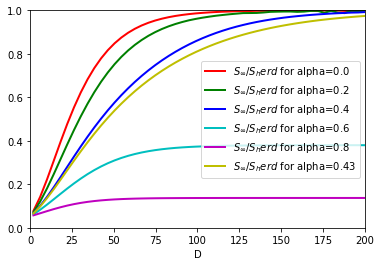

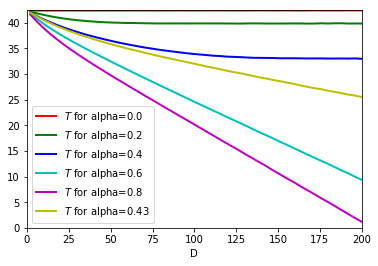

In [12]:
#graphique S infini et T en fonction de D (figure 3-4) 

# parameters
NT=int(5001) # number of time step
S_herd=nu/beta
min_D=2
max_D=200
nb_D = 50
D_array = np.linspace(min_D,max_D,nb_D)

color_plt=['r-','g-','b-','c-','m-','y-','b--','g--','r--']
color_tikz=['red','black!60!green','blue','brown',"orange",'black']
R0_array=[1.5, 2, 2.5, 3.5, 4.5, 6 ,8, 10]



#for ind_R0 in range(len(R0_array)):
ind_R0=4
RR0=R0_array[ind_R0]
S_herd=1.0/RR0
beta=RR0*nu
alpha_bar=(S_herd/(S0+I0-S_herd))*(np.log(S0)-np.log(S_herd))
alpha_array=[0.0,0.2,0.4,0.6,0.8,alpha_bar]
# Computation of T Sinf theoretical
S_inf_rel_theo_array =  np.zeros((len(D_array),len(alpha_array)))
T_theo_array =  np.zeros((len(D_array),len(alpha_array)))
for ind_alpha in range(len(alpha_array)):
    alpha = alpha_array[ind_alpha]
    for ind_D in range(len(D_array)):
        D = D_array[ind_D]
        h = D/NT        #the time step
        print('##############################################')
        print('Iteration '+str(ind_D+1)+'/'+str(len(D_array))+' and '+str(ind_alpha+1)+'/'+str(len(alpha_array))+" and R0="+str(RR0))
        print('##############################################')
        S_inf, T, u, Jval, yval = exact_value_T(D,alpha,Init)
        print('T=',T)
        print('S_inf=',S_inf)
        S_inf_rel_theo_array[ind_D,ind_alpha] = S_inf/S_herd
        T_theo_array[ind_D,ind_alpha] = T




# post processing - resultats et figures
# Plot
plt.figure(2*ind_R0+1)
for ind_alpha in range(len(alpha_array)):
    plt.plot(D_array,S_inf_rel_theo_array[:,ind_alpha],'{0}'.format(color_plt[ind_alpha]),linewidth=2,label=r'$S_\infty/S_herd$ for alpha={0}'.format(round(alpha_array[ind_alpha],2)))
plt.legend(loc='best')
plt.xlabel(r'D')
plt.axis([0, max(D_array),0.0, np.max(S_inf_rel_theo_array)])
plt.savefig("fig3_simu_covid_S_infinity_relative_with_respect_to_D_R0_{0}.png".format(10*RR0))
plt.figure(2*ind_R0+2)
for ind_alpha in range(len(alpha_array)):
    plt.plot(D_array,T_theo_array[:,ind_alpha],'{0}'.format(color_plt[ind_alpha]),linewidth=2,label=r'$T$ for alpha={0}'.format(round(alpha_array[ind_alpha],2)))
plt.legend(loc='best')
plt.xlabel(r'D')
plt.axis([0, max(D_array), 0.0, np.max(T_theo_array)])
plt.savefig("fig4_simu_covid_T_with_respect_to_D_R0_{0}.png".format(10*RR0))
plt.show()


# Save the values for tikz
File = open('fig3_simu_covid_S_infinity_with_respect_to_D_R0_{0}.txt'.format(10*RR0),'w')
for ind_alpha in range(len(alpha_array)):
    File.write('\\addplot[color={0}'.format(color_tikz[ind_alpha]))
    if alpha_array[ind_alpha]==alpha_array[-1]:
        File.write(' ,dashed,thick]coordinates { ')
    else:
        File.write(' ]coordinates { ')
    write_to_file(File,D_array,S_inf_rel_theo_array[:,ind_alpha])
    File.write(' };\n\n')
File.close()
File = open('fig4_simu_covid_T_with_respect_to_D_R0_{0}.txt'.format(10*RR0),'w')
for ind_alpha in range(len(alpha_array)):
    File.write('\\addplot[color={0}'.format(color_tikz[ind_alpha]))
    if alpha_array[ind_alpha]==alpha_array[-1]:
        File.write(' ,dashed,thick]coordinates { ')
    else:
        File.write(' ]coordinates { ')
    write_to_file(File,D_array,T_theo_array[:,ind_alpha])
    File.write(' };\n\n')
File.close()







##############################################
Iteration 1/50 and 1/6 and R0=6
##############################################
(124305, 15001)
('T=', 16.57289514032398)
('S_inf=', 0.004524231929885865)
##############################################
Iteration 2/50 and 1/6 and R0=6
##############################################
(41155, 15001)
('T=', 16.57288153578877)
('S_inf=', 0.011304220495976763)
##############################################
Iteration 3/50 and 1/6 and R0=6
##############################################
(24660, 15001)
('T=', 16.573099208352097)
('S_inf=', 0.021573385473424272)
##############################################
Iteration 4/50 and 1/6 and R0=6
##############################################
(17604, 15001)
('T=', 16.573001255698596)
('S_inf=', 0.03442637204995219)
##############################################
Iteration 5/50 and 1/6 and R0=6
##############################################
(13688, 15001)
('T=', 16.573480135337913)
('S_inf=', 0.04865264963386535

('T=', 16.57621192600765)
('S_inf=', 0.166511535645462)
##############################################
Iteration 43/50 and 1/6 and R0=6
##############################################
(1448, 15001)
('T=', 16.57504737779386)
('S_inf=', 0.1664606730155589)
##############################################
Iteration 44/50 and 1/6 and R0=6
##############################################
(1415, 15001)
('T=', 16.578459395223987)
('S_inf=', 0.16660308837928772)
##############################################
Iteration 45/50 and 1/6 and R0=6
##############################################
(1383, 15001)
('T=', 16.576078601562617)
('S_inf=', 0.16650644938247172)
##############################################
Iteration 46/50 and 1/6 and R0=6
##############################################
(1353, 15001)
('T=', 16.58096807151632)
('S_inf=', 0.16655222574938455)
##############################################
Iteration 47/50 and 1/6 and R0=6
##############################################
(1324, 15001)
('T=',

('T=', 13.969011589703543)
('S_inf=', 0.16520945231994122)
##############################################
Iteration 37/50 and 2/6 and R0=6
##############################################
('T=', 13.969335377641489)
('S_inf=', 0.16542307536553447)
##############################################
Iteration 38/50 and 2/6 and R0=6
##############################################
('T=', 13.97840960262513)
('S_inf=', 0.16545867920646667)
##############################################
Iteration 39/50 and 2/6 and R0=6
##############################################
('T=', 13.977919839357646)
('S_inf=', 0.16560618083318585)
##############################################
Iteration 40/50 and 2/6 and R0=6
##############################################
('T=', 13.968674197230387)
('S_inf=', 0.16589609782363385)
##############################################
Iteration 41/50 and 2/6 and R0=6
##############################################
('T=', 13.973297018294016)
('S_inf=', 0.16593170166456606)
############

('T=', 3.7868468632703394)
('S_inf=', 0.11765797962347921)
##############################################
Iteration 32/50 and 3/6 and R0=6
##############################################
('T=', 3.4104828385590618)
('S_inf=', 0.11820220976344299)
##############################################
Iteration 33/50 and 3/6 and R0=6
##############################################
('T=', 3.0198394936936173)
('S_inf=', 0.11865997343257138)
##############################################
Iteration 34/50 and 3/6 and R0=6
##############################################
('T=', 2.634578102956401)
('S_inf=', 0.11904652941983539)
##############################################
Iteration 35/50 and 3/6 and R0=6
##############################################
('T=', 2.248639206365834)
('S_inf=', 0.11936696398822529)
##############################################
Iteration 36/50 and 3/6 and R0=6
##############################################
('T=', 1.8740083994400372)
('S_inf=', 0.11964162218970233)
#############

('T=', 0.47386228673190495)
('S_inf=', 0.030214946293970743)
##############################################
Iteration 27/50 and 4/6 and R0=6
##############################################
('T=', 0.007136939170041724)
('S_inf=', 0.030245463871912636)
##############################################
Iteration 28/50 and 4/6 and R0=6
##############################################
('T=', 0.007406308967157291)
('S_inf=', 0.0302658089238739)
##############################################
Iteration 29/50 and 4/6 and R0=6
##############################################
('T=', 0.007675678764272858)
('S_inf=', 0.03027598144985453)
##############################################
Iteration 30/50 and 4/6 and R0=6
##############################################
('T=', 0.007945048561388423)
('S_inf=', 0.030286153975835162)
##############################################
Iteration 31/50 and 4/6 and R0=6
##############################################
('T=', 0.00821441835850399)
('S_inf=', 0.030296326501815796

('T=', 1.5438970735284312)
('S_inf=', 0.008481344536351522)
##############################################
Iteration 21/50 and 5/6 and R0=6
##############################################
('T=', 0.9274810250745186)
('S_inf=', 0.008491517062332154)
##############################################
Iteration 22/50 and 5/6 and R0=6
##############################################
('T=', 0.3068747797765863)
('S_inf=', 0.008496603325322469)
##############################################
Iteration 23/50 and 5/6 and R0=6
##############################################
('T=', 0.006059459981579459)
('S_inf=', 0.008501689588312785)
##############################################
Iteration 24/50 and 5/6 and R0=6
##############################################
('T=', 0.0063288297786950245)
('S_inf=', 0.0085067758513031)
##############################################
Iteration 25/50 and 5/6 and R0=6
##############################################
('T=', 0.006598199575810592)
('S_inf=', 0.0085067758513031)
##

('T=', 11.105327672032747)
('S_inf=', 0.09087880497946675)
##############################################
Iteration 15/50 and 6/6 and R0=6
##############################################
('T=', 10.838896454522079)
('S_inf=', 0.09665679973646546)
##############################################
Iteration 16/50 and 6/6 and R0=6
##############################################
('T=', 10.584937874889972)
('S_inf=', 0.10205841103218076)
##############################################
Iteration 17/50 and 6/6 and R0=6
##############################################
('T=', 10.326092546211203)
('S_inf=', 0.10709889765558368)
##############################################
Iteration 18/50 and 6/6 and R0=6
##############################################
('T=', 10.080274920447481)
('S_inf=', 0.11179351839564514)
##############################################
Iteration 19/50 and 6/6 and R0=6
##############################################
('T=', 9.844394047199573)
('S_inf=', 0.11615753204133605)
############

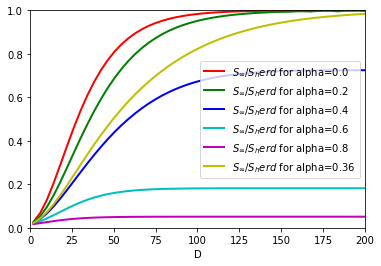

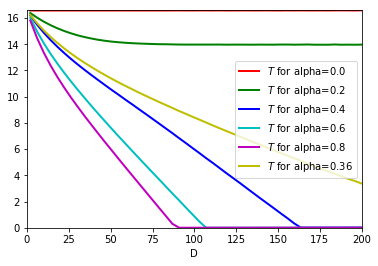

In [14]:
#graphique S infini et T en fonction de D (figure 3-4) 

# parameters
NT=int(15001) # number of time step
S_herd=nu/beta
min_D=2
max_D=200
nb_D = 50
D_array = np.linspace(min_D,max_D,nb_D)

color_plt=['r-','g-','b-','c-','m-','y-','b--','g--','r--']
color_tikz=['red','black!60!green','blue','brown',"orange",'black']
R0_array=[1.5, 2, 2.5, 3.5, 4.5, 6 ,8, 10]



#for ind_R0 in range(len(R0_array)):
ind_R0=5
RR0=R0_array[ind_R0]
S_herd=1.0/RR0
beta=RR0*nu
alpha_bar=(S_herd/(S0+I0-S_herd))*(np.log(S0)-np.log(S_herd))
alpha_array=[0.0,0.2,0.4,0.6,0.8,alpha_bar]
# Computation of T Sinf theoretical
S_inf_rel_theo_array =  np.zeros((len(D_array),len(alpha_array)))
T_theo_array =  np.zeros((len(D_array),len(alpha_array)))
for ind_alpha in range(len(alpha_array)):
    alpha = alpha_array[ind_alpha]
    for ind_D in range(len(D_array)):
        D = D_array[ind_D]
        h = D/NT        #the time step
        print('##############################################')
        print('Iteration '+str(ind_D+1)+'/'+str(len(D_array))+' and '+str(ind_alpha+1)+'/'+str(len(alpha_array))+" and R0="+str(RR0))
        print('##############################################')
        S_inf, T, u, Jval, yval = exact_value_T(D,alpha,Init)
        print('T=',T)
        print('S_inf=',S_inf)
        S_inf_rel_theo_array[ind_D,ind_alpha] = S_inf/S_herd
        T_theo_array[ind_D,ind_alpha] = T




# post processing - resultats et figures
# Plot
plt.figure(2*ind_R0+1)
for ind_alpha in range(len(alpha_array)):
    plt.plot(D_array,S_inf_rel_theo_array[:,ind_alpha],'{0}'.format(color_plt[ind_alpha]),linewidth=2,label=r'$S_\infty/S_herd$ for alpha={0}'.format(round(alpha_array[ind_alpha],2)))
plt.legend(loc='best')
plt.xlabel(r'D')
plt.axis([0, max(D_array),0.0, np.max(S_inf_rel_theo_array)])
plt.savefig("fig3_simu_covid_S_infinity_relative_with_respect_to_D_R0_{0}.png".format(10*RR0))
plt.figure(2*ind_R0+2)
for ind_alpha in range(len(alpha_array)):
    plt.plot(D_array,T_theo_array[:,ind_alpha],'{0}'.format(color_plt[ind_alpha]),linewidth=2,label=r'$T$ for alpha={0}'.format(round(alpha_array[ind_alpha],2)))
plt.legend(loc='best')
plt.xlabel(r'D')
plt.axis([0, max(D_array), 0.0, np.max(T_theo_array)])
plt.savefig("fig4_simu_covid_T_with_respect_to_D_R0_{0}.png".format(10*RR0))
plt.show()


# Save the values for tikz
File = open('fig3_simu_covid_S_infinity_with_respect_to_D_R0_{0}.txt'.format(10*RR0),'w')
for ind_alpha in range(len(alpha_array)):
    File.write('\\addplot[color={0}'.format(color_tikz[ind_alpha]))
    if alpha_array[ind_alpha]==alpha_array[-1]:
        File.write(' ,dashed,thick]coordinates { ')
    else:
        File.write(' ]coordinates { ')
    write_to_file(File,D_array,S_inf_rel_theo_array[:,ind_alpha])
    File.write(' };\n\n')
File.close()
File = open('fig4_simu_covid_T_with_respect_to_D_R0_{0}.txt'.format(10*RR0),'w')
for ind_alpha in range(len(alpha_array)):
    File.write('\\addplot[color={0}'.format(color_tikz[ind_alpha]))
    if alpha_array[ind_alpha]==alpha_array[-1]:
        File.write(' ,dashed,thick]coordinates { ')
    else:
        File.write(' ]coordinates { ')
    write_to_file(File,D_array,T_theo_array[:,ind_alpha])
    File.write(' };\n\n')
File.close()







##############################################
Iteration 1/50 and 1/6 and R0=8
##############################################
(92474, 15001)
('T=', 12.32904473035131)
('S_inf=', 0.0008125315110778807)
##############################################
Iteration 2/50 and 1/6 and R0=8
##############################################
(30617, 15001)
('T=', 12.32928961198505)
('S_inf=', 0.0031852731913146973)
##############################################
Iteration 3/50 and 1/6 and R0=8
##############################################
(18345, 15001)
('T=', 12.329014800373852)
('S_inf=', 0.008113862019073489)
##############################################
Iteration 4/50 and 1/6 and R0=8
##############################################
(13096, 15001)
('T=', 12.329017521280893)
('S_inf=', 0.015674591939056397)
##############################################
Iteration 5/50 and 1/6 and R0=8
##############################################
(10183, 15001)
('T=', 12.329613399922996)
('S_inf=', 0.025226593815765

('T=', 12.339944683959844)
('S_inf=', 0.12465286255160522)
##############################################
Iteration 43/50 and 1/6 and R0=8
##############################################
(1078, 15001)
('T=', 12.33971068595427)
('S_inf=', 0.12468338012948608)
##############################################
Iteration 44/50 and 1/6 and R0=8
##############################################
(1053, 15001)
('T=', 12.337185684219689)
('S_inf=', 0.12484359741336061)
##############################################
Iteration 45/50 and 1/6 and R0=8
##############################################
(1029, 15001)
('T=', 12.333177788147456)
('S_inf=', 0.12488174438571167)
##############################################
Iteration 46/50 and 1/6 and R0=8
##############################################
(1007, 15001)
('T=', 12.340750072444148)
('S_inf=', 0.12464523315713501)
##############################################
Iteration 47/50 and 1/6 and R0=8
##############################################
(985, 15001)
('

('T=', 9.618634948146314)
('S_inf=', 0.12357711793130492)
##############################################
Iteration 37/50 and 2/6 and R0=8
##############################################
('T=', 9.624193761232243)
('S_inf=', 0.12379837037094117)
##############################################
Iteration 38/50 and 2/6 and R0=8
##############################################
('T=', 9.63540661915056)
('S_inf=', 0.12383651734329225)
##############################################
Iteration 39/50 and 2/6 and R0=8
##############################################
('T=', 9.633150987213096)
('S_inf=', 0.12401962281057739)
##############################################
Iteration 40/50 and 2/6 and R0=8
##############################################
('T=', 9.638704358484944)
('S_inf=', 0.12398147583822632)
##############################################
Iteration 41/50 and 2/6 and R0=8
##############################################
('T=', 9.620958602759814)
('S_inf=', 0.12435531616726685)
##################

('T=', 0.00821441835850399)
('S_inf=', 0.047039032606109615)
##############################################
Iteration 32/50 and 3/6 and R0=8
##############################################
('T=', 0.008483788155619556)
('S_inf=', 0.04707717957846069)
##############################################
Iteration 33/50 and 3/6 and R0=8
##############################################
('T=', 0.008753157952735123)
('S_inf=', 0.047107697156341555)
##############################################
Iteration 34/50 and 3/6 and R0=8
##############################################
('T=', 0.00902252774985069)
('S_inf=', 0.04713058533975219)
##############################################
Iteration 35/50 and 3/6 and R0=8
##############################################
('T=', 0.009291897546966256)
('S_inf=', 0.04714584412869262)
##############################################
Iteration 36/50 and 3/6 and R0=8
##############################################
('T=', 0.009561267344081822)
('S_inf=', 0.047153473523162834

('T=', 0.006598199575810592)
('S_inf=', 0.008495331742584229)
##############################################
Iteration 26/50 and 4/6 and R0=8
##############################################
('T=', 0.006867569372926158)
('S_inf=', 0.008502961137054444)
##############################################
Iteration 27/50 and 4/6 and R0=8
##############################################
('T=', 0.007136939170041724)
('S_inf=', 0.008502961137054444)
##############################################
Iteration 28/50 and 4/6 and R0=8
##############################################
('T=', 0.007406308967157291)
('S_inf=', 0.00851059053152466)
##############################################
Iteration 29/50 and 4/6 and R0=8
##############################################
('T=', 0.007675678764272858)
('S_inf=', 0.00851059053152466)
##############################################
Iteration 30/50 and 4/6 and R0=8
##############################################
('T=', 0.007945048561388423)
('S_inf=', 0.008510590531524

('T=', 0.7722070229331649)
('S_inf=', 0.0016593942972717283)
##############################################
Iteration 20/50 and 5/6 and R0=8
##############################################
('T=', 0.2888242824628018)
('S_inf=', 0.0016593942972717283)
##############################################
Iteration 21/50 and 5/6 and R0=8
##############################################
('T=', 0.005520720387348325)
('S_inf=', 0.0016593942972717283)
##############################################
Iteration 22/50 and 5/6 and R0=8
##############################################
('T=', 0.005790090184463892)
('S_inf=', 0.0016593942972717283)
##############################################
Iteration 23/50 and 5/6 and R0=8
##############################################
('T=', 0.006059459981579459)
('S_inf=', 0.0016593942972717283)
##############################################
Iteration 24/50 and 5/6 and R0=8
##############################################
('T=', 0.0063288297786950245)
('S_inf=', 0.00165939429

('T=', 8.222556591465331)
('S_inf=', 0.05978775076583863)
##############################################
Iteration 14/50 and 6/6 and R0=8
##############################################
('T=', 8.011830503816752)
('S_inf=', 0.0650672917392273)
##############################################
Iteration 15/50 and 6/6 and R0=8
##############################################
('T=', 7.8050987077052)
('S_inf=', 0.07001876875039674)
##############################################
Iteration 16/50 and 6/6 and R0=8
##############################################
('T=', 7.600619822624068)
('S_inf=', 0.07464218179934694)
##############################################
Iteration 17/50 and 6/6 and R0=8
##############################################
('T=', 7.406883078543062)
('S_inf=', 0.07895278967501833)
##############################################
Iteration 18/50 and 6/6 and R0=8
##############################################
('T=', 7.2102948238824895)
('S_inf=', 0.08295059237741088)
###################

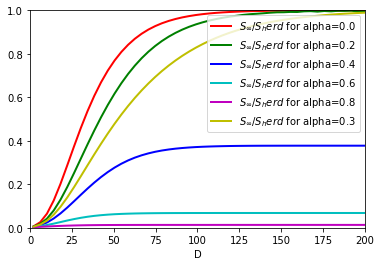

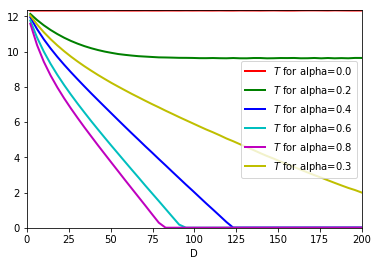

In [15]:
#graphique S infini et T en fonction de D (figure 3-4) 

# parameters
NT=int(15001) # number of time step
S_herd=nu/beta
min_D=2
max_D=200
nb_D = 50
D_array = np.linspace(min_D,max_D,nb_D)

color_plt=['r-','g-','b-','c-','m-','y-','b--','g--','r--']
color_tikz=['red','black!60!green','blue','brown',"orange",'black']
R0_array=[1.5, 2, 2.5, 3.5, 4.5, 6 ,8, 10]



#for ind_R0 in range(len(R0_array)):
ind_R0=6
RR0=R0_array[ind_R0]
S_herd=1.0/RR0
beta=RR0*nu
alpha_bar=(S_herd/(S0+I0-S_herd))*(np.log(S0)-np.log(S_herd))
alpha_array=[0.0,0.2,0.4,0.6,0.8,alpha_bar]
# Computation of T Sinf theoretical
S_inf_rel_theo_array =  np.zeros((len(D_array),len(alpha_array)))
T_theo_array =  np.zeros((len(D_array),len(alpha_array)))
for ind_alpha in range(len(alpha_array)):
    alpha = alpha_array[ind_alpha]
    for ind_D in range(len(D_array)):
        D = D_array[ind_D]
        h = D/NT        #the time step
        print('##############################################')
        print('Iteration '+str(ind_D+1)+'/'+str(len(D_array))+' and '+str(ind_alpha+1)+'/'+str(len(alpha_array))+" and R0="+str(RR0))
        print('##############################################')
        S_inf, T, u, Jval, yval = exact_value_T(D,alpha,Init)
        print('T=',T)
        print('S_inf=',S_inf)
        S_inf_rel_theo_array[ind_D,ind_alpha] = S_inf/S_herd
        T_theo_array[ind_D,ind_alpha] = T




# post processing - resultats et figures
# Plot
plt.figure(2*ind_R0+1)
for ind_alpha in range(len(alpha_array)):
    plt.plot(D_array,S_inf_rel_theo_array[:,ind_alpha],'{0}'.format(color_plt[ind_alpha]),linewidth=2,label=r'$S_\infty/S_herd$ for alpha={0}'.format(round(alpha_array[ind_alpha],2)))
plt.legend(loc='best')
plt.xlabel(r'D')
plt.axis([0, max(D_array),0.0, np.max(S_inf_rel_theo_array)])
plt.savefig("fig3_simu_covid_S_infinity_relative_with_respect_to_D_R0_{0}.png".format(10*RR0))
plt.figure(2*ind_R0+2)
for ind_alpha in range(len(alpha_array)):
    plt.plot(D_array,T_theo_array[:,ind_alpha],'{0}'.format(color_plt[ind_alpha]),linewidth=2,label=r'$T$ for alpha={0}'.format(round(alpha_array[ind_alpha],2)))
plt.legend(loc='best')
plt.xlabel(r'D')
plt.axis([0, max(D_array), 0.0, np.max(T_theo_array)])
plt.savefig("fig4_simu_covid_T_with_respect_to_D_R0_{0}.png".format(10*RR0))
plt.show()


# Save the values for tikz
File = open('fig3_simu_covid_S_infinity_with_respect_to_D_R0_{0}.txt'.format(10*RR0),'w')
for ind_alpha in range(len(alpha_array)):
    File.write('\\addplot[color={0}'.format(color_tikz[ind_alpha]))
    if alpha_array[ind_alpha]==alpha_array[-1]:
        File.write(' ,dashed,thick]coordinates { ')
    else:
        File.write(' ]coordinates { ')
    write_to_file(File,D_array,S_inf_rel_theo_array[:,ind_alpha])
    File.write(' };\n\n')
File.close()
File = open('fig4_simu_covid_T_with_respect_to_D_R0_{0}.txt'.format(10*RR0),'w')
for ind_alpha in range(len(alpha_array)):
    File.write('\\addplot[color={0}'.format(color_tikz[ind_alpha]))
    if alpha_array[ind_alpha]==alpha_array[-1]:
        File.write(' ,dashed,thick]coordinates { ')
    else:
        File.write(' ]coordinates { ')
    write_to_file(File,D_array,T_theo_array[:,ind_alpha])
    File.write(' };\n\n')
File.close()







##############################################
Iteration 1/50 and 1/6 and R0=10
##############################################
(74002, 15001)
('T=', 9.86627558162789)
('S_inf=', 0.00014953713131713868)
##############################################
Iteration 2/50 and 1/6 and R0=10
##############################################
(24501, 15001)
('T=', 9.86641162697997)
('S_inf=', 0.0009490976701965331)
##############################################
Iteration 3/50 and 1/6 and R0=10
##############################################
(14681, 15001)
('T=', 9.866572160495423)
('S_inf=', 0.003280640615631103)
##############################################
Iteration 4/50 and 1/6 and R0=10
##############################################
(10480, 15001)
('T=', 9.866226605301142)
('S_inf=', 0.007748414008453369)
##############################################
Iteration 5/50 and 1/6 and R0=10
##############################################
(8149, 15001)
('T=', 9.866838809385495)
('S_inf=', 0.014236451052947

('T=', 9.86972024994252)
('S_inf=', 0.09983825683755493)
##############################################
Iteration 43/50 and 1/6 and R0=10
##############################################
(862, 15001)
('T=', 9.867189806393858)
('S_inf=', 0.0996734619173279)
##############################################
Iteration 44/50 and 1/6 and R0=10
##############################################
(843, 15001)
('T=', 9.876778282808354)
('S_inf=', 0.09967956543289186)
##############################################
Iteration 45/50 and 1/6 and R0=10
##############################################
(824, 15001)
('T=', 9.876130706932463)
('S_inf=', 0.09973449707296755)
##############################################
Iteration 46/50 and 1/6 and R0=10
##############################################
(806, 15001)
('T=', 9.877502044081414)
('S_inf=', 0.09964904785507203)
##############################################
Iteration 47/50 and 1/6 and R0=10
##############################################
(788, 15001)
('T=', 

('T=', 6.998847695867894)
('S_inf=', 0.09858703614694214)
##############################################
Iteration 37/50 and 2/6 and R0=10
##############################################
('T=', 6.999413644532541)
('S_inf=', 0.0988006591916809)
##############################################
Iteration 38/50 and 2/6 and R0=10
##############################################
('T=', 7.009404815189191)
('S_inf=', 0.09891052247183227)
##############################################
Iteration 39/50 and 2/6 and R0=10
##############################################
('T=', 6.999329296414252)
('S_inf=', 0.09913024903213502)
##############################################
Iteration 40/50 and 2/6 and R0=10
##############################################
('T=', 7.00029521841401)
('S_inf=', 0.09925842285897829)
##############################################
Iteration 41/50 and 2/6 and R0=10
##############################################
('T=', 7.013918799971156)
('S_inf=', 0.09916687012551881)
##############

('T=', 0.007945048561388423)
('S_inf=', 0.01968078693600464)
##############################################
Iteration 31/50 and 3/6 and R0=10
##############################################
('T=', 0.00821441835850399)
('S_inf=', 0.019686890451568604)
##############################################
Iteration 32/50 and 3/6 and R0=10
##############################################
('T=', 0.008483788155619556)
('S_inf=', 0.019686890451568604)
##############################################
Iteration 33/50 and 3/6 and R0=10
##############################################
('T=', 0.008753157952735123)
('S_inf=', 0.019692993967132567)
##############################################
Iteration 34/50 and 3/6 and R0=10
##############################################
('T=', 0.00902252774985069)
('S_inf=', 0.019692993967132567)
##############################################
Iteration 35/50 and 3/6 and R0=10
##############################################
('T=', 0.009291897546966256)
('S_inf=', 0.01969299396

('T=', 0.0063288297786950245)
('S_inf=', 0.0024871835923156735)
##############################################
Iteration 25/50 and 4/6 and R0=10
##############################################
('T=', 0.006598199575810592)
('S_inf=', 0.0024932871078796387)
##############################################
Iteration 26/50 and 4/6 and R0=10
##############################################
('T=', 0.006867569372926158)
('S_inf=', 0.0024932871078796387)
##############################################
Iteration 27/50 and 4/6 and R0=10
##############################################
('T=', 0.007136939170041724)
('S_inf=', 0.0024932871078796387)
##############################################
Iteration 28/50 and 4/6 and R0=10
##############################################
('T=', 0.007406308967157291)
('S_inf=', 0.0024932871078796387)
##############################################
Iteration 29/50 and 4/6 and R0=10
##############################################
('T=', 0.007675678764272858)
('S_inf=', 0.00

('T=', 0.6644781504362295)
('S_inf=', 0.00033264259823608395)
##############################################
Iteration 19/50 and 5/6 and R0=10
##############################################
('T=', 0.2789909244145628)
('S_inf=', 0.00033264259823608395)
##############################################
Iteration 20/50 and 5/6 and R0=10
##############################################
('T=', 0.0052513505902327595)
('S_inf=', 0.00033264259823608395)
##############################################
Iteration 21/50 and 5/6 and R0=10
##############################################
('T=', 0.005520720387348325)
('S_inf=', 0.00033264259823608395)
##############################################
Iteration 22/50 and 5/6 and R0=10
##############################################
('T=', 0.005790090184463892)
('S_inf=', 0.00033264259823608395)
##############################################
Iteration 23/50 and 5/6 and R0=10
##############################################
('T=', 0.006059459981579459)
('S_inf=', 0.0

('T=', 6.6324721209062245)
('S_inf=', 0.04061584532040405)
##############################################
Iteration 13/50 and 6/6 and R0=10
##############################################
('T=', 6.448800011971991)
('S_inf=', 0.045486450740448006)
##############################################
Iteration 14/50 and 6/6 and R0=10
##############################################
('T=', 6.270602368005397)
('S_inf=', 0.050100708506805425)
##############################################
Iteration 15/50 and 6/6 and R0=10
##############################################
('T=', 6.098831506470997)
('S_inf=', 0.054440308072784424)
##############################################
Iteration 16/50 and 6/6 and R0=10
##############################################
('T=', 5.926897390514101)
('S_inf=', 0.058499145922821044)
##############################################
Iteration 17/50 and 6/6 and R0=10
##############################################
('T=', 5.767327076154106)
('S_inf=', 0.062271118541351325)
######

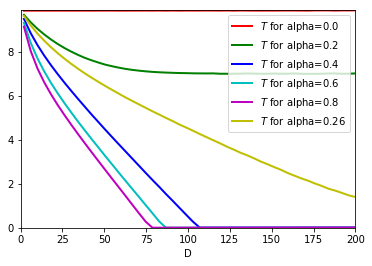

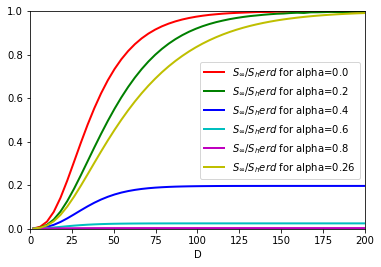

In [16]:
#graphique S infini et T en fonction de D (figure 3-4) 

# parameters
NT=int(15001) # number of time step
S_herd=nu/beta
min_D=2
max_D=200
nb_D = 50
D_array = np.linspace(min_D,max_D,nb_D)

color_plt=['r-','g-','b-','c-','m-','y-','b--','g--','r--']
color_tikz=['red','black!60!green','blue','brown',"orange",'black']
R0_array=[1.5, 2, 2.5, 3.5, 4.5, 6 ,8, 10]



#for ind_R0 in range(len(R0_array)):
ind_R0=7
RR0=R0_array[ind_R0]
S_herd=1.0/RR0
beta=RR0*nu
alpha_bar=(S_herd/(S0+I0-S_herd))*(np.log(S0)-np.log(S_herd))
alpha_array=[0.0,0.2,0.4,0.6,0.8,alpha_bar]
# Computation of T Sinf theoretical
S_inf_rel_theo_array =  np.zeros((len(D_array),len(alpha_array)))
T_theo_array =  np.zeros((len(D_array),len(alpha_array)))
for ind_alpha in range(len(alpha_array)):
    alpha = alpha_array[ind_alpha]
    for ind_D in range(len(D_array)):
        D = D_array[ind_D]
        h = D/NT        #the time step
        print('##############################################')
        print('Iteration '+str(ind_D+1)+'/'+str(len(D_array))+' and '+str(ind_alpha+1)+'/'+str(len(alpha_array))+" and R0="+str(RR0))
        print('##############################################')
        S_inf, T, u, Jval, yval = exact_value_T(D,alpha,Init)
        print('T=',T)
        print('S_inf=',S_inf)
        S_inf_rel_theo_array[ind_D,ind_alpha] = S_inf/S_herd
        T_theo_array[ind_D,ind_alpha] = T




# post processing - resultats et figures
# Plot
plt.figure(2*ind_R0+1)
for ind_alpha in range(len(alpha_array)):
    plt.plot(D_array,S_inf_rel_theo_array[:,ind_alpha],'{0}'.format(color_plt[ind_alpha]),linewidth=2,label=r'$S_\infty/S_herd$ for alpha={0}'.format(round(alpha_array[ind_alpha],2)))
plt.legend(loc='best')
plt.xlabel(r'D')
plt.axis([0, max(D_array),0.0, np.max(S_inf_rel_theo_array)])
plt.savefig("fig3_simu_covid_S_infinity_relative_with_respect_to_D_R0_{0}.png".format(10*RR0))
plt.figure(2*ind_R0+2)
for ind_alpha in range(len(alpha_array)):
    plt.plot(D_array,T_theo_array[:,ind_alpha],'{0}'.format(color_plt[ind_alpha]),linewidth=2,label=r'$T$ for alpha={0}'.format(round(alpha_array[ind_alpha],2)))
plt.legend(loc='best')
plt.xlabel(r'D')
plt.axis([0, max(D_array), 0.0, np.max(T_theo_array)])
plt.savefig("fig4_simu_covid_T_with_respect_to_D_R0_{0}.png".format(10*RR0))
plt.show()


# Save the values for tikz
File = open('fig3_simu_covid_S_infinity_with_respect_to_D_R0_{0}.txt'.format(10*RR0),'w')
for ind_alpha in range(len(alpha_array)):
    File.write('\\addplot[color={0}'.format(color_tikz[ind_alpha]))
    if alpha_array[ind_alpha]==alpha_array[-1]:
        File.write(' ,dashed,thick]coordinates { ')
    else:
        File.write(' ]coordinates { ')
    write_to_file(File,D_array,S_inf_rel_theo_array[:,ind_alpha])
    File.write(' };\n\n')
File.close()
File = open('fig4_simu_covid_T_with_respect_to_D_R0_{0}.txt'.format(10*RR0),'w')
for ind_alpha in range(len(alpha_array)):
    File.write('\\addplot[color={0}'.format(color_tikz[ind_alpha]))
    if alpha_array[ind_alpha]==alpha_array[-1]:
        File.write(' ,dashed,thick]coordinates { ')
    else:
        File.write(' ]coordinates { ')
    write_to_file(File,D_array,T_theo_array[:,ind_alpha])
    File.write(' };\n\n')
File.close()







##############################################
Iteration 1/4 and 1/50 and R0=1.5
##############################################
('T=', 244.6975302469753)
('S_inf=', 0.6031366985002428)
##############################################
Iteration 2/4 and 1/50 and R0=1.5
##############################################
('T=', 244.6975302469753)
('S_inf=', 0.651893615744816)
##############################################
Iteration 3/4 and 1/50 and R0=1.5
##############################################
('T=', 244.6915308469153)
('S_inf=', 0.6657282511407304)
##############################################
Iteration 4/4 and 1/50 and R0=1.5
##############################################
('T=', 244.67953204679532)
('S_inf=', 0.6662317911790377)
##############################################
Iteration 1/4 and 2/50 and R0=1.5
##############################################
('T=', 244.6975302469753)
('S_inf=', 0.6012547811853574)
##############################################
Iteration 2/4 and 2/50 and R

('T=', 242.52574742525746)
('S_inf=', 0.5793991090176199)
##############################################
Iteration 2/4 and 12/50 and R0=1.5
##############################################
('T=', 241.93780621937805)
('S_inf=', 0.638252258343403)
##############################################
Iteration 3/4 and 12/50 and R0=1.5
##############################################
('T=', 241.87181281871813)
('S_inf=', 0.6636479695683303)
##############################################
Iteration 4/4 and 12/50 and R0=1.5
##############################################
('T=', 242.03979602039794)
('S_inf=', 0.6646652221709709)
##############################################
Iteration 1/4 and 13/50 and R0=1.5
##############################################
('T=', 242.2947705229477)
('S_inf=', 0.5768559775110181)
##############################################
Iteration 2/4 and 13/50 and R0=1.5
##############################################
('T=', 241.6078392160784)
('S_inf=', 0.6365127563928871)
##########

('T=', 239.75102489751023)
('S_inf=', 0.547279358089237)
##############################################
Iteration 2/4 and 23/50 and R0=1.5
##############################################
('T=', 237.54624537546243)
('S_inf=', 0.6120630900884158)
##############################################
Iteration 3/4 and 23/50 and R0=1.5
##############################################
('T=', 236.55634436556343)
('S_inf=', 0.6558659871581282)
##############################################
Iteration 4/4 and 23/50 and R0=1.5
##############################################
('T=', 236.54434556544345)
('S_inf=', 0.6659164428722192)
##############################################
Iteration 1/4 and 24/50 and R0=1.5
##############################################
('T=', 239.46605339466052)
('S_inf=', 0.5438613893443642)
##############################################
Iteration 2/4 and 24/50 and R0=1.5
##############################################
('T=', 237.04229577042295)
('S_inf=', 0.6087315878147671)
########

('T=', 236.32836716328367)
('S_inf=', 0.5045140586742186)
##############################################
Iteration 2/4 and 34/50 and R0=1.5
##############################################
('T=', 230.74892510748924)
('S_inf=', 0.5624059042905057)
##############################################
Iteration 3/4 and 34/50 and R0=1.5
##############################################
('T=', 225.1094890510949)
('S_inf=', 0.6245854696269241)
##############################################
Iteration 4/4 and 34/50 and R0=1.5
##############################################
('T=', 222.93770622937706)
('S_inf=', 0.6605148315521966)
##############################################
Iteration 1/4 and 35/50 and R0=1.5
##############################################
('T=', 235.986401359864)
('S_inf=', 0.5000279746965727)
##############################################
Iteration 2/4 and 35/50 and R0=1.5
##############################################
('T=', 229.99300069993)
('S_inf=', 0.5562057496774101)
#############

('T=', 232.27277272272772)
('S_inf=', 0.44937896761108787)
##############################################
Iteration 2/4 and 45/50 and R0=1.5
##############################################
('T=', 221.2818718128187)
('S_inf=', 0.4751561485620053)
##############################################
Iteration 3/4 and 45/50 and R0=1.5
##############################################
('T=', 201.6998300169983)
('S_inf=', 0.5092493695395114)
##############################################
Iteration 4/4 and 45/50 and R0=1.5
##############################################
('T=', 165.1034896510349)
('S_inf=', 0.5366592409176675)
##############################################
Iteration 1/4 and 46/50 and R0=1.5
##############################################
('T=', 231.87681231876812)
('S_inf=', 0.44374338819245784)
##############################################
Iteration 2/4 and 46/50 and R0=1.5
##############################################
('T=', 220.33996600339967)
('S_inf=', 0.4651870730561256)
########

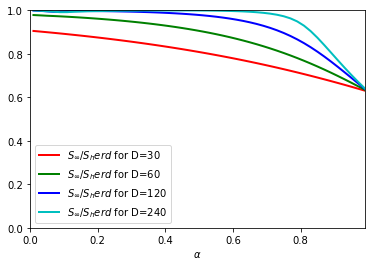

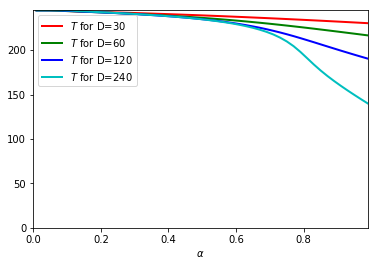

In [16]:
#graphique S infini et T en fonction de alpha (figure 3-4)

# parameters
NT=int(10001) # number of time step
nb_alpha = 50
min_alpha = 0.01
max_alpha = 0.99
alpha_array = np.linspace(min_alpha,max_alpha,nb_alpha)
D_array=[30,60,120,240]
color_plt=['r-','g-','b-','c-','m-','y-','b--','g--','r--']
color_tikz=['red','black!60!green','blue','black','brown']
R0_array=[1.5, 2, 2.5, 3.5, 4.5, 6 ,8, 10]

#for ind_R0 in range(len(R0_array)):
ind_R0=0
RR0=R0_array[ind_R0]
S_herd=1.0/RR0
beta=RR0*nu
# Computation of T Sinf theoretical
S_inf_rel_theo_array =  np.zeros((len(D_array),len(alpha_array)))
T_theo_array =  np.zeros((len(D_array),len(alpha_array)))
for ind_alpha in range(len(alpha_array)):
    alpha = alpha_array[ind_alpha]
    for ind_D in range(len(D_array)):
        D = D_array[ind_D]
        h = D/NT        #the time step
        print('##############################################')
        print('Iteration '+str(ind_D+1)+'/'+str(len(D_array))+' and '+str(ind_alpha+1)+'/'+str(len(alpha_array))+" and R0="+str(RR0))
        print('##############################################')  
        S_inf, T, u, Jval, yval = exact_value_T(D,alpha,Init)
        print("T=",T)
        print('S_inf=',S_inf)
        S_inf_rel_theo_array[ind_D,ind_alpha] = S_inf/S_herd
        T_theo_array[ind_D,ind_alpha] = T

# post processing - resultats et figures
# Plot
plt.figure(2*ind_R0+1)
for ind_D in range(len(D_array)):
    plt.plot(alpha_array,S_inf_rel_theo_array[ind_D,:],'{0}'.format(color_plt[ind_D]),linewidth=2,label=r'$S_\infty/S_herd$ for D={0}'.format(D_array[ind_D]))
plt.legend(loc='best')
plt.xlabel(r'$\alpha$')
plt.axis([0, max(alpha_array),0.0, np.max(S_inf_rel_theo_array)])
plt.savefig("fig3_simu_covid_S_infinity_rel_with_respect_to_alpha_R0_{0}.png".format(10*RR0))
plt.figure(2*ind_R0+2)
for ind_D in range(len(D_array)):
    plt.plot(alpha_array,T_theo_array[ind_D,:],'{0}'.format(color_plt[ind_D]),linewidth=2,label=r'$T$ for D={0}'.format(D_array[ind_D]))
plt.legend(loc='best')
plt.xlabel(r'$\alpha$')
plt.axis([0, max(alpha_array), 0.0, np.max(T_theo_array)])
plt.savefig("fig4_simu_covid_T_with_respect_to_alpha_R0_{0}.png".format(10*RR0))
plt.show()

# Save the values for tikz
File = open('fig3_simu_covid_S_infinity_rel_with_respect_to_alpha_R0_{0}.txt'.format(10*RR0),'w')
for ind_D in range(len(D_array)):
    File.write('\\addplot[color={0}'.format(color_tikz[ind_D]))
    File.write(' ]coordinates { ')
    write_to_file(File,alpha_array,S_inf_rel_theo_array[ind_D,:])
    File.write(' };\n\n')
File.close()
File = open('fig4_simu_covid_T_with_respect_to_alpha_R0_{0}.txt'.format(10*RR0),'w')
for ind_D in range(len(D_array)):
    File.write('\\addplot[color={0}'.format(color_tikz[ind_D]))
    File.write(' ]coordinates { ')
    write_to_file(File,alpha_array,T_theo_array[ind_D,:])
    File.write(' };\n\n')
File.close()




##############################################
Iteration 1/4 and 1/50 and R0=2
##############################################
('T=', 63.38083095845208)
('S_inf=', 0.4160575868378067)
##############################################
Iteration 2/4 and 1/50 and R0=2
##############################################
('T=', 63.38083095845208)
('S_inf=', 0.480022430459877)
##############################################
Iteration 3/4 and 1/50 and R0=2
##############################################
('T=', 63.38083095845208)
('S_inf=', 0.49817276001342004)
##############################################
Iteration 4/4 and 1/50 and R0=2
##############################################
('T=', 63.38083095845208)
('S_inf=', 0.4985389709501876)
##############################################
Iteration 1/4 and 2/50 and R0=2
##############################################
('T=', 63.20833958302085)
('S_inf=', 0.4136619569597856)
##############################################
Iteration 2/4 and 2/50 and R0=2
######

('T=', 61.16544172791361)
('S_inf=', 0.38579940818738556)
##############################################
Iteration 2/4 and 12/50 and R0=2
##############################################
('T=', 60.53697315134244)
('S_inf=', 0.4617347718050461)
##############################################
Iteration 3/4 and 12/50 and R0=2
##############################################
('T=', 60.41697915104245)
('S_inf=', 0.4960746765215226)
##############################################
Iteration 4/4 and 12/50 and R0=2
##############################################
('T=', 60.44097795110245)
('S_inf=', 0.4991645813004989)
##############################################
Iteration 1/4 and 13/50 and R0=2
##############################################
('T=', 60.940452977351136)
('S_inf=', 0.38257980370163736)
##############################################
Iteration 2/4 and 13/50 and R0=2
##############################################
('T=', 60.21898905054748)
('S_inf=', 0.45938491829412076)
###################

('T=', 56.124193790310485)
('S_inf=', 0.42609787002085114)
##############################################
Iteration 3/4 and 23/50 and R0=2
##############################################
('T=', 54.98725063746813)
('S_inf=', 0.4848365783994675)
##############################################
Iteration 4/4 and 23/50 and R0=2
##############################################
('T=', 54.89725513724314)
('S_inf=', 0.49939346313597865)
##############################################
Iteration 1/4 and 24/50 and R0=2
##############################################
('T=', 58.15059247037648)
('S_inf=', 0.3413887027098008)
##############################################
Iteration 2/4 and 24/50 and R0=2
##############################################
('T=', 55.60821958902055)
('S_inf=', 0.42152023331125643)
##############################################
Iteration 3/4 and 24/50 and R0=2
##############################################
('T=', 54.237288135593225)
('S_inf=', 0.48276901248563386)
#################

('T=', 41.19994000299985)
('S_inf=', 0.4308815003823776)
##############################################
Iteration 4/4 and 34/50 and R0=2
##############################################
('T=', 32.986350682465876)
('S_inf=', 0.48600387576041415)
##############################################
Iteration 1/4 and 35/50 and R0=2
##############################################
('T=', 54.774261286935655)
('S_inf=', 0.2889671329904252)
##############################################
Iteration 2/4 and 35/50 and R0=2
##############################################
('T=', 48.50157492125394)
('S_inf=', 0.3496894839431992)
##############################################
Iteration 3/4 and 35/50 and R0=2
##############################################
('T=', 39.226038698065096)
('S_inf=', 0.41984939591225434)
##############################################
Iteration 4/4 and 35/50 and R0=2
##############################################
('T=', 25.246737663116846)
('S_inf=', 0.47616195683478557)
################

('T=', 0.0119994000299985)
('S_inf=', 0.2738151554816666)
##############################################
Iteration 1/4 and 46/50 and R0=2
##############################################
('T=', 51.02894855257237)
('S_inf=', 0.22788620049539945)
##############################################
Iteration 2/4 and 46/50 and R0=2
##############################################
('T=', 40.26998650067497)
('S_inf=', 0.2444190984115524)
##############################################
Iteration 3/4 and 46/50 and R0=2
##############################################
('T=', 20.33298335083246)
('S_inf=', 0.25647354174681847)
##############################################
Iteration 4/4 and 46/50 and R0=2
##############################################
('T=', 0.0119994000299985)
('S_inf=', 0.25879287767967984)
##############################################
Iteration 1/4 and 47/50 and R0=2
##############################################
('T=', 50.68246587670617)
('S_inf=', 0.2221565252138901)
##################

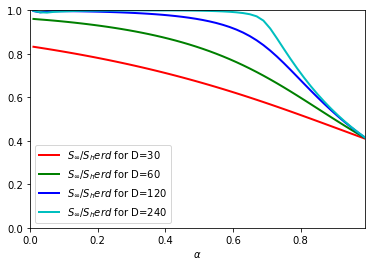

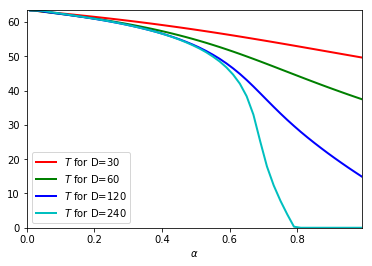

In [17]:
#graphique S infini et T en fonction de alpha (figure 3-4)

# parameters
NT=int(20001) # number of time step
nb_alpha = 50
min_alpha = 0.01
max_alpha = 0.99
alpha_array = np.linspace(min_alpha,max_alpha,nb_alpha)
D_array=[30,60,120,240]
color_plt=['r-','g-','b-','c-','m-','y-','b--','g--','r--']
color_tikz=['red','black!60!green','blue','black','brown']
R0_array=[1.5, 2, 2.5, 3.5, 4.5, 6 ,8, 10]

#for ind_R0 in range(len(R0_array)):
ind_R0=1
RR0=R0_array[ind_R0]
S_herd=1.0/RR0
beta=RR0*nu
# Computation of T Sinf theoretical
S_inf_rel_theo_array =  np.zeros((len(D_array),len(alpha_array)))
T_theo_array =  np.zeros((len(D_array),len(alpha_array)))
for ind_alpha in range(len(alpha_array)):
    alpha = alpha_array[ind_alpha]
    for ind_D in range(len(D_array)):
        D = D_array[ind_D]
        h = D/NT        #the time step
        print('##############################################')
        print('Iteration '+str(ind_D+1)+'/'+str(len(D_array))+' and '+str(ind_alpha+1)+'/'+str(len(alpha_array))+" and R0="+str(RR0))
        print('##############################################')  
        S_inf, T, u, Jval, yval = exact_value_T(D,alpha,Init)
        print("T=",T)
        print('S_inf=',S_inf)
        S_inf_rel_theo_array[ind_D,ind_alpha] = S_inf/S_herd
        T_theo_array[ind_D,ind_alpha] = T

# post processing - resultats et figures
# Plot
plt.figure(2*ind_R0+1)
for ind_D in range(len(D_array)):
    plt.plot(alpha_array,S_inf_rel_theo_array[ind_D,:],'{0}'.format(color_plt[ind_D]),linewidth=2,label=r'$S_\infty/S_herd$ for D={0}'.format(D_array[ind_D]))
plt.legend(loc='best')
plt.xlabel(r'$\alpha$')
plt.axis([0, max(alpha_array),0.0, np.max(S_inf_rel_theo_array)])
plt.savefig("fig3_simu_covid_S_infinity_rel_with_respect_to_alpha_R0_{0}.png".format(10*RR0))
plt.figure(2*ind_R0+2)
for ind_D in range(len(D_array)):
    plt.plot(alpha_array,T_theo_array[ind_D,:],'{0}'.format(color_plt[ind_D]),linewidth=2,label=r'$T$ for D={0}'.format(D_array[ind_D]))
plt.legend(loc='best')
plt.xlabel(r'$\alpha$')
plt.axis([0, max(alpha_array), 0.0, np.max(T_theo_array)])
plt.savefig("fig4_simu_covid_T_with_respect_to_alpha_R0_{0}.png".format(10*RR0))
plt.show()

# Save the values for tikz
File = open('fig3_simu_covid_S_infinity_rel_with_respect_to_alpha_R0_{0}.txt'.format(10*RR0),'w')
for ind_D in range(len(D_array)):
    File.write('\\addplot[color={0}'.format(color_tikz[ind_D]))
    File.write(' ]coordinates { ')
    write_to_file(File,alpha_array,S_inf_rel_theo_array[ind_D,:])
    File.write(' };\n\n')
File.close()
File = open('fig4_simu_covid_T_with_respect_to_alpha_R0_{0}.txt'.format(10*RR0),'w')
for ind_D in range(len(D_array)):
    File.write('\\addplot[color={0}'.format(color_tikz[ind_D]))
    File.write(' ]coordinates { ')
    write_to_file(File,alpha_array,T_theo_array[ind_D,:])
    File.write(' };\n\n')
File.close()




##############################################
Iteration 1/4 and 1/50 and R0=2.5
##############################################
('T=', 45.946468451051636)
('S_inf=', 0.3096466066711959)
##############################################
Iteration 2/4 and 1/50 and R0=2.5
##############################################
('T=', 45.946468451051636)
('S_inf=', 0.37804870610956576)
##############################################
Iteration 3/4 and 1/50 and R0=2.5
##############################################
('T=', 45.946468451051636)
('S_inf=', 0.39742736817049407)
##############################################
Iteration 4/4 and 1/50 and R0=2.5
##############################################
('T=', 45.94246858438052)
('S_inf=', 0.397830200200737)
##############################################
Iteration 1/4 and 2/50 and R0=2.5
##############################################
('T=', 45.72047598413386)
('S_inf=', 0.3071441652712021)
##############################################
Iteration 2/4 and 2/50 a

('T=', 43.72654244858505)
('S_inf=', 0.2780364993283463)
##############################################
Iteration 2/4 and 12/50 and R0=2.5
##############################################
('T=', 43.08456384787174)
('S_inf=', 0.35806579600327304)
##############################################
Iteration 3/4 and 12/50 and R0=2.5
##############################################
('T=', 42.94656844771841)
('S_inf=', 0.3956817627061081)
##############################################
Iteration 4/4 and 12/50 and R0=2.5
##############################################
('T=', 42.95056831438952)
('S_inf=', 0.39966735839926915)
##############################################
Iteration 1/4 and 13/50 and R0=2.5
##############################################
('T=', 43.50454984833839)
('S_inf=', 0.2746978762898179)
##############################################
Iteration 2/4 and 13/50 and R0=2.5
##############################################
('T=', 42.76257458084731)
('S_inf=', 0.3554718018691331)
###########

('T=', 41.01463284557182)
('S_inf=', 0.23661193888503268)
##############################################
Iteration 2/4 and 23/50 and R0=2.5
##############################################
('T=', 38.572714242858574)
('S_inf=', 0.31798400899410245)
##############################################
Iteration 3/4 and 23/50 and R0=2.5
##############################################
('T=', 37.190760307989734)
('S_inf=', 0.38236999516126247)
##############################################
Iteration 4/4 and 23/50 and R0=2.5
##############################################
('T=', 37.07076430785641)
('S_inf=', 0.39931335449390415)
##############################################
Iteration 1/4 and 24/50 and R0=2.5
##############################################
('T=', 40.74064197860071)
('S_inf=', 0.2323394779582138)
##############################################
Iteration 2/4 and 24/50 and R0=2.5
##############################################
('T=', 38.036732108929705)
('S_inf=', 0.3127288820541153)
######

('T=', 37.805739808673046)
('S_inf=', 0.1856964116685715)
##############################################
Iteration 2/4 and 34/50 and R0=2.5
##############################################
('T=', 31.696943435218827)
('S_inf=', 0.24037170450063328)
##############################################
Iteration 3/4 and 34/50 and R0=2.5
##############################################
('T=', 20.89130362321256)
('S_inf=', 0.2953887942068405)
##############################################
Iteration 4/4 and 34/50 and R0=2.5
##############################################
('T=', 0.007999733342221926)
('S_inf=', 0.31798400899410245)
##############################################
Iteration 1/4 and 35/50 and R0=2.5
##############################################
('T=', 37.500749975000836)
('S_inf=', 0.18075866754029085)
##############################################
Iteration 2/4 and 35/50 and R0=2.5
##############################################
('T=', 31.02696576780774)
('S_inf=', 0.23145446819480137)
###

('T=', 34.47685077164095)
('S_inf=', 0.1315948493038254)
##############################################
Iteration 2/4 and 45/50 and R0=2.5
##############################################
('T=', 24.955168161061298)
('S_inf=', 0.14427795474086763)
##############################################
Iteration 3/4 and 45/50 and R0=2.5
##############################################
('T=', 7.35175494150195)
('S_inf=', 0.1501129156637802)
##############################################
Iteration 4/4 and 45/50 and R0=2.5
##############################################
('T=', 0.007999733342221926)
('S_inf=', 0.15057678285012055)
##############################################
Iteration 1/4 and 46/50 and R0=2.5
##############################################
('T=', 34.18486050464985)
('S_inf=', 0.12690734931554412)
##############################################
Iteration 2/4 and 46/50 and R0=2.5
##############################################
('T=', 24.42318589380354)
('S_inf=', 0.13675231999405668)
######

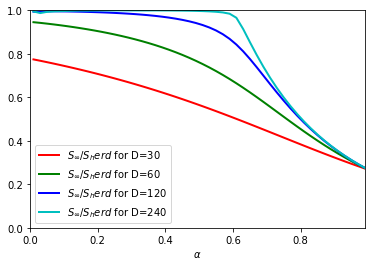

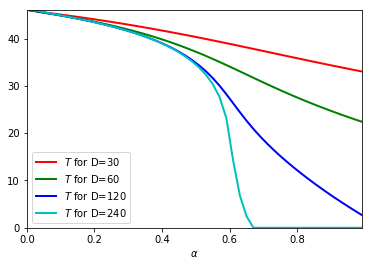

In [18]:
#graphique S infini et T en fonction de alpha (figure 3-4)

# parameters
NT=int(30001) # number of time step
nb_alpha = 50
min_alpha = 0.01
max_alpha = 0.99
alpha_array = np.linspace(min_alpha,max_alpha,nb_alpha)
D_array=[30,60,120,240]
color_plt=['r-','g-','b-','c-','m-','y-','b--','g--','r--']
color_tikz=['red','black!60!green','blue','black','brown']
R0_array=[1.5, 2, 2.5, 3.5, 4.5, 6 ,8, 10]

#for ind_R0 in range(len(R0_array)):
ind_R0=2
RR0=R0_array[ind_R0]
S_herd=1.0/RR0
beta=RR0*nu
# Computation of T Sinf theoretical
S_inf_rel_theo_array =  np.zeros((len(D_array),len(alpha_array)))
T_theo_array =  np.zeros((len(D_array),len(alpha_array)))
for ind_alpha in range(len(alpha_array)):
    alpha = alpha_array[ind_alpha]
    for ind_D in range(len(D_array)):
        D = D_array[ind_D]
        h = D/NT        #the time step
        print('##############################################')
        print('Iteration '+str(ind_D+1)+'/'+str(len(D_array))+' and '+str(ind_alpha+1)+'/'+str(len(alpha_array))+" and R0="+str(RR0))
        print('##############################################')  
        S_inf, T, u, Jval, yval = exact_value_T(D,alpha,Init)
        print("T=",T)
        print('S_inf=',S_inf)
        S_inf_rel_theo_array[ind_D,ind_alpha] = S_inf/S_herd
        T_theo_array[ind_D,ind_alpha] = T

# post processing - resultats et figures
# Plot
plt.figure(2*ind_R0+1)
for ind_D in range(len(D_array)):
    plt.plot(alpha_array,S_inf_rel_theo_array[ind_D,:],'{0}'.format(color_plt[ind_D]),linewidth=2,label=r'$S_\infty/S_herd$ for D={0}'.format(D_array[ind_D]))
plt.legend(loc='best')
plt.xlabel(r'$\alpha$')
plt.axis([0, max(alpha_array),0.0, np.max(S_inf_rel_theo_array)])
plt.savefig("fig3_simu_covid_S_infinity_rel_with_respect_to_alpha_R0_{0}.png".format(10*RR0))
plt.figure(2*ind_R0+2)
for ind_D in range(len(D_array)):
    plt.plot(alpha_array,T_theo_array[ind_D,:],'{0}'.format(color_plt[ind_D]),linewidth=2,label=r'$T$ for D={0}'.format(D_array[ind_D]))
plt.legend(loc='best')
plt.xlabel(r'$\alpha$')
plt.axis([0, max(alpha_array), 0.0, np.max(T_theo_array)])
plt.savefig("fig4_simu_covid_T_with_respect_to_alpha_R0_{0}.png".format(10*RR0))
plt.show()

# Save the values for tikz
File = open('fig3_simu_covid_S_infinity_rel_with_respect_to_alpha_R0_{0}.txt'.format(10*RR0),'w')
for ind_D in range(len(D_array)):
    File.write('\\addplot[color={0}'.format(color_tikz[ind_D]))
    File.write(' ]coordinates { ')
    write_to_file(File,alpha_array,S_inf_rel_theo_array[ind_D,:])
    File.write(' };\n\n')
File.close()
File = open('fig4_simu_covid_T_with_respect_to_alpha_R0_{0}.txt'.format(10*RR0),'w')
for ind_D in range(len(D_array)):
    File.write('\\addplot[color={0}'.format(color_tikz[ind_D]))
    File.write(' ]coordinates { ')
    write_to_file(File,alpha_array,T_theo_array[ind_D,:])
    File.write(' };\n\n')
File.close()




##############################################
Iteration 1/4 and 1/50 and R0=3.5
##############################################
('T=', 30.034199316013677)
('S_inf=', 0.19514247381030486)
##############################################
Iteration 2/4 and 1/50 and R0=3.5
##############################################
('T=', 30.04019919601608)
('S_inf=', 0.2630833217867976)
##############################################
Iteration 3/4 and 1/50 and R0=3.5
##############################################
('T=', 30.08579828403432)
('S_inf=', 0.28218732562618365)
##############################################
Iteration 4/4 and 1/50 and R0=3.5
##############################################
('T=', 30.09059818803624)
('S_inf=', 0.2822657993982304)
##############################################
Iteration 1/4 and 2/50 and R0=3.5
##############################################
('T=', 29.84340313193736)
('S_inf=', 0.19273594480087064)
##############################################
Iteration 2/4 and 2/50 a

('T=', 27.875442491150174)
('S_inf=', 0.16497366811232428)
##############################################
Iteration 2/4 and 12/50 and R0=3.5
##############################################
('T=', 27.2022559548809)
('S_inf=', 0.24218314049834117)
##############################################
Iteration 3/4 and 12/50 and R0=3.5
##############################################
('T=', 27.047459050818983)
('S_inf=', 0.28114100866556)
##############################################
Iteration 4/4 and 12/50 and R0=3.5
##############################################
('T=', 27.047459050818983)
('S_inf=', 0.28558785574821033)
##############################################
Iteration 1/4 and 13/50 and R0=3.5
##############################################
('T=', 27.654046919061617)
('S_inf=', 0.16180855930643795)
##############################################
Iteration 2/4 and 13/50 and R0=3.5
##############################################
('T=', 26.872262554748904)
('S_inf=', 0.23941040055268858)
######

('T=', 25.215695686086278)
('S_inf=', 0.12626865987725613)
##############################################
Iteration 2/4 and 23/50 and R0=3.5
##############################################
('T=', 22.4167516649667)
('S_inf=', 0.1966945106352299)
##############################################
Iteration 3/4 and 23/50 and R0=3.5
##############################################
('T=', 19.8740025199496)
('S_inf=', 0.26304844455477683)
##############################################
Iteration 4/4 and 23/50 and R0=3.5
##############################################
('T=', 19.430011399772003)
('S_inf=', 0.2848118373357478)
##############################################
Iteration 1/4 and 24/50 and R0=3.5
##############################################
('T=', 24.9535009299814)
('S_inf=', 0.12238856781494357)
##############################################
Iteration 2/4 and 24/50 and R0=3.5
##############################################
('T=', 21.846763064738703)
('S_inf=', 0.1903730123314623)
##########

('T=', 22.333353332933342)
('S_inf=', 0.08302961147948563)
##############################################
Iteration 2/4 and 34/50 and R0=3.5
##############################################
('T=', 16.27887442251155)
('S_inf=', 0.11301531170935712)
##############################################
Iteration 3/4 and 34/50 and R0=3.5
##############################################
('T=', 4.98230035399292)
('S_inf=', 0.1282217848704202)
##############################################
Iteration 4/4 and 34/50 and R0=3.5
##############################################
('T=', 0.004799904001919961)
('S_inf=', 0.12936401421910093)
##############################################
Iteration 1/4 and 35/50 and R0=3.5
##############################################
('T=', 22.08315833683326)
('S_inf=', 0.07926287042124068)
##############################################
Iteration 2/4 and 35/50 and R0=3.5
##############################################
('T=', 15.814483710325792)
('S_inf=', 0.10562133852095033)
####

('T=', 19.81220375592488)
('S_inf=', 0.04680960602589852)
##############################################
Iteration 2/4 and 45/50 and R0=3.5
##############################################
('T=', 12.033359332813344)
('S_inf=', 0.05097743525238256)
##############################################
Iteration 3/4 and 45/50 and R0=3.5
##############################################
('T=', 0.0023999520009599807)
('S_inf=', 0.0519104012089386)
##############################################
Iteration 4/4 and 45/50 and R0=3.5
##############################################
('T=', 0.004799904001919961)
('S_inf=', 0.05192783982494899)
##############################################
Iteration 1/4 and 46/50 and R0=3.5
##############################################
('T=', 19.61060778784424)
('S_inf=', 0.044185094316334314)
##############################################
Iteration 2/4 and 46/50 and R0=3.5
##############################################
('T=', 11.722565548689026)
('S_inf=', 0.04730660658219474

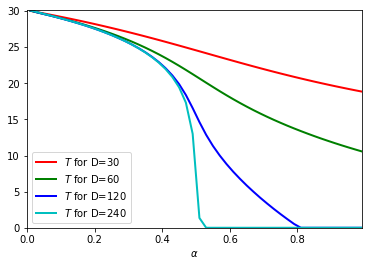

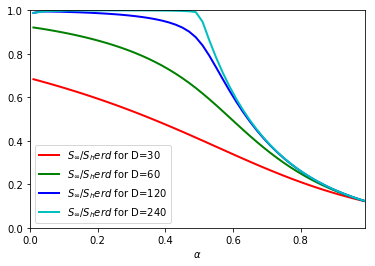

In [19]:
#graphique S infini et T en fonction de alpha (figure 3-4)

# parameters
NT=int(50001) # number of time step
nb_alpha = 50
min_alpha = 0.01
max_alpha = 0.99
alpha_array = np.linspace(min_alpha,max_alpha,nb_alpha)
D_array=[30,60,120,240]
color_plt=['r-','g-','b-','c-','m-','y-','b--','g--','r--']
color_tikz=['red','black!60!green','blue','black','brown']
R0_array=[1.5, 2, 2.5, 3.5, 4.5, 6 ,8, 10]

#for ind_R0 in range(len(R0_array)):
ind_R0=3
RR0=R0_array[ind_R0]
S_herd=1.0/RR0
beta=RR0*nu
# Computation of T Sinf theoretical
S_inf_rel_theo_array =  np.zeros((len(D_array),len(alpha_array)))
T_theo_array =  np.zeros((len(D_array),len(alpha_array)))
for ind_alpha in range(len(alpha_array)):
    alpha = alpha_array[ind_alpha]
    for ind_D in range(len(D_array)):
        D = D_array[ind_D]
        h = D/NT        #the time step
        print('##############################################')
        print('Iteration '+str(ind_D+1)+'/'+str(len(D_array))+' and '+str(ind_alpha+1)+'/'+str(len(alpha_array))+" and R0="+str(RR0))
        print('##############################################')  
        S_inf, T, u, Jval, yval = exact_value_T(D,alpha,Init)
        print("T=",T)
        print('S_inf=',S_inf)
        S_inf_rel_theo_array[ind_D,ind_alpha] = S_inf/S_herd
        T_theo_array[ind_D,ind_alpha] = T

# post processing - resultats et figures
# Plot
plt.figure(2*ind_R0+1)
for ind_D in range(len(D_array)):
    plt.plot(alpha_array,S_inf_rel_theo_array[ind_D,:],'{0}'.format(color_plt[ind_D]),linewidth=2,label=r'$S_\infty/S_herd$ for D={0}'.format(D_array[ind_D]))
plt.legend(loc='best')
plt.xlabel(r'$\alpha$')
plt.axis([0, max(alpha_array),0.0, np.max(S_inf_rel_theo_array)])
plt.savefig("fig3_simu_covid_S_infinity_rel_with_respect_to_alpha_R0_{0}.png".format(10*RR0))
plt.figure(2*ind_R0+2)
for ind_D in range(len(D_array)):
    plt.plot(alpha_array,T_theo_array[ind_D,:],'{0}'.format(color_plt[ind_D]),linewidth=2,label=r'$T$ for D={0}'.format(D_array[ind_D]))
plt.legend(loc='best')
plt.xlabel(r'$\alpha$')
plt.axis([0, max(alpha_array), 0.0, np.max(T_theo_array)])
plt.savefig("fig4_simu_covid_T_with_respect_to_alpha_R0_{0}.png".format(10*RR0))
plt.show()

# Save the values for tikz
File = open('fig3_simu_covid_S_infinity_rel_with_respect_to_alpha_R0_{0}.txt'.format(10*RR0),'w')
for ind_D in range(len(D_array)):
    File.write('\\addplot[color={0}'.format(color_tikz[ind_D]))
    File.write(' ]coordinates { ')
    write_to_file(File,alpha_array,S_inf_rel_theo_array[ind_D,:])
    File.write(' };\n\n')
File.close()
File = open('fig4_simu_covid_T_with_respect_to_alpha_R0_{0}.txt'.format(10*RR0),'w')
for ind_D in range(len(D_array)):
    File.write('\\addplot[color={0}'.format(color_tikz[ind_D]))
    File.write(' ]coordinates { ')
    write_to_file(File,alpha_array,T_theo_array[ind_D,:])
    File.write(' };\n\n')
File.close()




##############################################
Iteration 1/4 and 1/50 and R0=4.5
##############################################
('T=', 22.516349673006538)
('S_inf=', 0.13609144461501904)
##############################################
Iteration 2/4 and 1/50 and R0=4.5
##############################################
('T=', 22.516349673006538)
('S_inf=', 0.20014444996914166)
##############################################
Iteration 3/4 and 1/50 and R0=4.5
##############################################
('T=', 22.542749145017098)
('S_inf=', 0.21941799588935512)
##############################################
Iteration 4/4 and 1/50 and R0=4.5
##############################################
('T=', 22.58354832903342)
('S_inf=', 0.21793280709395513)
##############################################
Iteration 1/4 and 2/50 and R0=4.5
##############################################
('T=', 22.3327533449331)
('S_inf=', 0.13389417899990674)
##############################################
Iteration 2/4 and 2/5

('T=', 20.373792524149515)
('S_inf=', 0.10857137095413719)
##############################################
Iteration 2/4 and 12/50 and R0=4.5
##############################################
('T=', 19.665206695866082)
('S_inf=', 0.17939249693752546)
##############################################
Iteration 3/4 and 12/50 and R0=4.5
##############################################
('T=', 19.492410151796964)
('S_inf=', 0.21764119468207294)
##############################################
Iteration 4/4 and 12/50 and R0=4.5
##############################################
('T=', 19.487610247795043)
('S_inf=', 0.222151014540251)
##############################################
Iteration 1/4 and 13/50 and R0=4.5
##############################################
('T=', 20.154796904061918)
('S_inf=', 0.10568915525530159)
##############################################
Iteration 2/4 and 13/50 and R0=4.5
##############################################
('T=', 19.323213535729284)
('S_inf=', 0.1765306262906816)
####

('T=', 17.791444171116577)
('S_inf=', 0.07394409246412659)
##############################################
Iteration 2/4 and 23/50 and R0=4.5
##############################################
('T=', 14.609707805843883)
('S_inf=', 0.12852986695807395)
##############################################
Iteration 3/4 and 23/50 and R0=4.5
##############################################
('T=', 8.875022499550008)
('S_inf=', 0.18049791142907884)
##############################################
Iteration 4/4 and 23/50 and R0=4.5
##############################################
('T=', 0.004799904001919961)
('S_inf=', 0.19545830632703487)
##############################################
Iteration 1/4 and 24/50 and R0=4.5
##############################################
('T=', 17.547849043019138)
('S_inf=', 0.07060750393747456)
##############################################
Iteration 2/4 and 24/50 and R0=4.5
##############################################
('T=', 14.062518749625006)
('S_inf=', 0.12130737350099183)


('T=', 15.305093898122037)
('S_inf=', 0.03987291206189135)
##############################################
Iteration 2/4 and 34/50 and R0=4.5
##############################################
('T=', 9.817003659926801)
('S_inf=', 0.05404663161616516)
##############################################
Iteration 3/4 and 34/50 and R0=4.5
##############################################
('T=', 0.0023999520009599807)
('S_inf=', 0.058095296962529505)
##############################################
Iteration 4/4 and 34/50 and R0=4.5
##############################################
('T=', 0.004799904001919961)
('S_inf=', 0.05819024053849116)
##############################################
Iteration 1/4 and 35/50 and R0=4.5
##############################################
('T=', 15.10889782204356)
('S_inf=', 0.037295872142932465)
##############################################
Iteration 2/4 and 35/50 and R0=4.5
##############################################
('T=', 9.503809923801523)
('S_inf=', 0.0492926711340857

('T=', 13.439131217375651)
('S_inf=', 0.0179341643307546)
##############################################
Iteration 2/4 and 45/50 and R0=4.5
##############################################
('T=', 7.024659506809863)
('S_inf=', 0.01937866302217102)
##############################################
Iteration 3/4 and 45/50 and R0=4.5
##############################################
('T=', 0.0023999520009599807)
('S_inf=', 0.01959567691008335)
##############################################
Iteration 4/4 and 45/50 and R0=4.5
##############################################
('T=', 0.004799904001919961)
('S_inf=', 0.01959567691008335)
##############################################
Iteration 1/4 and 46/50 and R0=4.5
##############################################
('T=', 13.299334013319733)
('S_inf=', 0.016598172583294338)
##############################################
Iteration 2/4 and 46/50 and R0=4.5
##############################################
('T=', 6.825463490730185)
('S_inf=', 0.01765611528686692

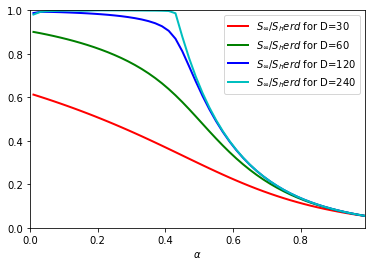

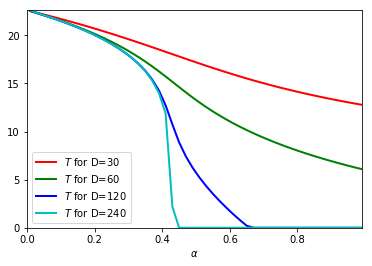

In [20]:
#graphique S infini et T en fonction de alpha (figure 3-4)

# parameters
NT=int(50001) # number of time step
nb_alpha = 50
min_alpha = 0.01
max_alpha = 0.99
alpha_array = np.linspace(min_alpha,max_alpha,nb_alpha)
D_array=[30,60,120,240]
color_plt=['r-','g-','b-','c-','m-','y-','b--','g--','r--']
color_tikz=['red','black!60!green','blue','black','brown']
R0_array=[1.5, 2, 2.5, 3.5, 4.5, 6 ,8, 10]

#for ind_R0 in range(len(R0_array)):
ind_R0=4
RR0=R0_array[ind_R0]
S_herd=1.0/RR0
beta=RR0*nu
# Computation of T Sinf theoretical
S_inf_rel_theo_array =  np.zeros((len(D_array),len(alpha_array)))
T_theo_array =  np.zeros((len(D_array),len(alpha_array)))
for ind_alpha in range(len(alpha_array)):
    alpha = alpha_array[ind_alpha]
    for ind_D in range(len(D_array)):
        D = D_array[ind_D]
        h = D/NT        #the time step
        print('##############################################')
        print('Iteration '+str(ind_D+1)+'/'+str(len(D_array))+' and '+str(ind_alpha+1)+'/'+str(len(alpha_array))+" and R0="+str(RR0))
        print('##############################################')  
        S_inf, T, u, Jval, yval = exact_value_T(D,alpha,Init)
        print("T=",T)
        print('S_inf=',S_inf)
        S_inf_rel_theo_array[ind_D,ind_alpha] = S_inf/S_herd
        T_theo_array[ind_D,ind_alpha] = T

# post processing - resultats et figures
# Plot
plt.figure(2*ind_R0+1)
for ind_D in range(len(D_array)):
    plt.plot(alpha_array,S_inf_rel_theo_array[ind_D,:],'{0}'.format(color_plt[ind_D]),linewidth=2,label=r'$S_\infty/S_herd$ for D={0}'.format(D_array[ind_D]))
plt.legend(loc='best')
plt.xlabel(r'$\alpha$')
plt.axis([0, max(alpha_array),0.0, np.max(S_inf_rel_theo_array)])
plt.savefig("fig3_simu_covid_S_infinity_rel_with_respect_to_alpha_R0_{0}.png".format(10*RR0))
plt.figure(2*ind_R0+2)
for ind_D in range(len(D_array)):
    plt.plot(alpha_array,T_theo_array[ind_D,:],'{0}'.format(color_plt[ind_D]),linewidth=2,label=r'$T$ for D={0}'.format(D_array[ind_D]))
plt.legend(loc='best')
plt.xlabel(r'$\alpha$')
plt.axis([0, max(alpha_array), 0.0, np.max(T_theo_array)])
plt.savefig("fig4_simu_covid_T_with_respect_to_alpha_R0_{0}.png".format(10*RR0))
plt.show()

# Save the values for tikz
File = open('fig3_simu_covid_S_infinity_rel_with_respect_to_alpha_R0_{0}.txt'.format(10*RR0),'w')
for ind_D in range(len(D_array)):
    File.write('\\addplot[color={0}'.format(color_tikz[ind_D]))
    File.write(' ]coordinates { ')
    write_to_file(File,alpha_array,S_inf_rel_theo_array[ind_D,:])
    File.write(' };\n\n')
File.close()
File = open('fig4_simu_covid_T_with_respect_to_alpha_R0_{0}.txt'.format(10*RR0),'w')
for ind_D in range(len(D_array)):
    File.write('\\addplot[color={0}'.format(color_tikz[ind_D]))
    File.write(' ]coordinates { ')
    write_to_file(File,alpha_array,T_theo_array[ind_D,:])
    File.write(' };\n\n')
File.close()




##############################################
Iteration 1/4 and 1/50 and R0=6
##############################################
('T=', 16.499070018599628)
('S_inf=', 0.08829498338038635)
##############################################
Iteration 2/4 and 1/50 and R0=6
##############################################
('T=', 16.492470150596986)
('S_inf=', 0.14588673921973166)
##############################################
Iteration 3/4 and 1/50 and R0=6
##############################################
('T=', 16.511669766604665)
('S_inf=', 0.1643295288226166)
##############################################
Iteration 4/4 and 1/50 and R0=6
##############################################
('T=', 16.550068998620027)
('S_inf=', 0.16265106203581237)
##############################################
Iteration 1/4 and 2/50 and R0=6
##############################################
('T=', 16.319673606527868)
('S_inf=', 0.08640289354798888)
##############################################
Iteration 2/4 and 2/50 and R0

('T=', 14.372712545749085)
('S_inf=', 0.06455230774159242)
##############################################
Iteration 2/4 and 12/50 and R0=6
##############################################
('T=', 13.59452810943781)
('S_inf=', 0.12559763615136205)
##############################################
Iteration 3/4 and 12/50 and R0=6
##############################################
('T=', 13.379732405351893)
('S_inf=', 0.16213226321080015)
##############################################
Iteration 4/4 and 12/50 and R0=6
##############################################
('T=', 13.382132357352852)
('S_inf=', 0.16646575927854917)
##############################################
Iteration 1/4 and 13/50 and R0=6
##############################################
('T=', 14.157316853662927)
('S_inf=', 0.06206512513932799)
##############################################
Iteration 2/4 and 13/50 and R0=6
##############################################
('T=', 13.226135477290454)
('S_inf=', 0.12258148219810483)
############

('T=', 8.55222895542089)
('S_inf=', 0.06720225075954692)
##############################################
Iteration 3/4 and 23/50 and R0=6
##############################################
('T=', 2.0303593928121435)
('S_inf=', 0.08315277149717712)
##############################################
Iteration 4/4 and 23/50 and R0=6
##############################################
('T=', 0.004799904001919961)
('S_inf=', 0.08396657357562765)
##############################################
Iteration 1/4 and 24/50 and R0=6
##############################################
('T=', 11.751964960700786)
('S_inf=', 0.03332773924404399)
##############################################
Iteration 2/4 and 24/50 and R0=6
##############################################
('T=', 8.164636707265855)
('S_inf=', 0.060508728664291384)
##############################################
Iteration 3/4 and 24/50 and R0=6
##############################################
('T=', 1.377572448551029)
('S_inf=', 0.0724258428506012)
#############

('T=', 5.510289794204116)
('S_inf=', 0.01851145515325419)
##############################################
Iteration 3/4 and 34/50 and R0=6
##############################################
('T=', 0.0023999520009599807)
('S_inf=', 0.019279480864791865)
##############################################
Iteration 4/4 and 34/50 and R0=6
##############################################
('T=', 0.004799904001919961)
('S_inf=', 0.019284567127782183)
##############################################
Iteration 1/4 and 35/50 and R0=6
##############################################
('T=', 9.92920141597168)
('S_inf=', 0.012652080188410441)
##############################################
Iteration 2/4 and 35/50 and R0=6
##############################################
('T=', 5.324293514129717)
('S_inf=', 0.016380310960311888)
##############################################
Iteration 3/4 and 35/50 and R0=6
##############################################
('T=', 0.0023999520009599807)
('S_inf=', 0.016975403730178834)
##

('T=', 3.862722745545089)
('S_inf=', 0.004849752761266072)
##############################################
Iteration 3/4 and 45/50 and R0=6
##############################################
('T=', 0.0023999520009599807)
('S_inf=', 0.004885356602198281)
##############################################
Iteration 4/4 and 45/50 and R0=6
##############################################
('T=', 0.004799904001919961)
('S_inf=', 0.004885356602198281)
##############################################
Iteration 1/4 and 46/50 and R0=6
##############################################
('T=', 8.76162476750465)
('S_inf=', 0.004051209471786499)
##############################################
Iteration 2/4 and 46/50 and R0=6
##############################################
('T=', 3.7475250494990098)
('S_inf=', 0.004295350095321655)
##############################################
Iteration 3/4 and 46/50 and R0=6
##############################################
('T=', 0.0023999520009599807)
('S_inf=', 0.004320781410273233)


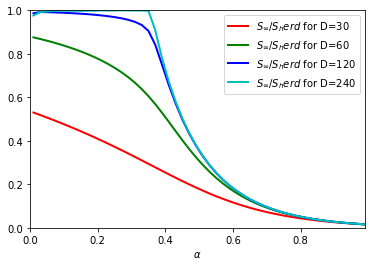

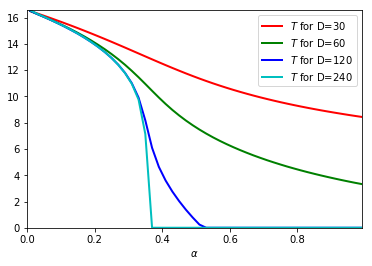

In [21]:
#graphique S infini et T en fonction de alpha (figure 3-4)

# parameters
NT=int(50001) # number of time step
nb_alpha = 50
min_alpha = 0.01
max_alpha = 0.99
alpha_array = np.linspace(min_alpha,max_alpha,nb_alpha)
D_array=[30,60,120,240]
color_plt=['r-','g-','b-','c-','m-','y-','b--','g--','r--']
color_tikz=['red','black!60!green','blue','black','brown']
R0_array=[1.5, 2, 2.5, 3.5, 4.5, 6 ,8, 10]

#for ind_R0 in range(len(R0_array)):
ind_R0=5
RR0=R0_array[ind_R0]
S_herd=1.0/RR0
beta=RR0*nu
# Computation of T Sinf theoretical
S_inf_rel_theo_array =  np.zeros((len(D_array),len(alpha_array)))
T_theo_array =  np.zeros((len(D_array),len(alpha_array)))
for ind_alpha in range(len(alpha_array)):
    alpha = alpha_array[ind_alpha]
    for ind_D in range(len(D_array)):
        D = D_array[ind_D]
        h = D/NT        #the time step
        print('##############################################')
        print('Iteration '+str(ind_D+1)+'/'+str(len(D_array))+' and '+str(ind_alpha+1)+'/'+str(len(alpha_array))+" and R0="+str(RR0))
        print('##############################################')  
        S_inf, T, u, Jval, yval = exact_value_T(D,alpha,Init)
        print("T=",T)
        print('S_inf=',S_inf)
        S_inf_rel_theo_array[ind_D,ind_alpha] = S_inf/S_herd
        T_theo_array[ind_D,ind_alpha] = T

# post processing - resultats et figures
# Plot
plt.figure(2*ind_R0+1)
for ind_D in range(len(D_array)):
    plt.plot(alpha_array,S_inf_rel_theo_array[ind_D,:],'{0}'.format(color_plt[ind_D]),linewidth=2,label=r'$S_\infty/S_herd$ for D={0}'.format(D_array[ind_D]))
plt.legend(loc='best')
plt.xlabel(r'$\alpha$')
plt.axis([0, max(alpha_array),0.0, np.max(S_inf_rel_theo_array)])
plt.savefig("fig3_simu_covid_S_infinity_rel_with_respect_to_alpha_R0_{0}.png".format(10*RR0))
plt.figure(2*ind_R0+2)
for ind_D in range(len(D_array)):
    plt.plot(alpha_array,T_theo_array[ind_D,:],'{0}'.format(color_plt[ind_D]),linewidth=2,label=r'$T$ for D={0}'.format(D_array[ind_D]))
plt.legend(loc='best')
plt.xlabel(r'$\alpha$')
plt.axis([0, max(alpha_array), 0.0, np.max(T_theo_array)])
plt.savefig("fig4_simu_covid_T_with_respect_to_alpha_R0_{0}.png".format(10*RR0))
plt.show()

# Save the values for tikz
File = open('fig3_simu_covid_S_infinity_rel_with_respect_to_alpha_R0_{0}.txt'.format(10*RR0),'w')
for ind_D in range(len(D_array)):
    File.write('\\addplot[color={0}'.format(color_tikz[ind_D]))
    File.write(' ]coordinates { ')
    write_to_file(File,alpha_array,S_inf_rel_theo_array[ind_D,:])
    File.write(' };\n\n')
File.close()
File = open('fig4_simu_covid_T_with_respect_to_alpha_R0_{0}.txt'.format(10*RR0),'w')
for ind_D in range(len(D_array)):
    File.write('\\addplot[color={0}'.format(color_tikz[ind_D]))
    File.write(' ]coordinates { ')
    write_to_file(File,alpha_array,T_theo_array[ind_D,:])
    File.write(' };\n\n')
File.close()




##############################################
Iteration 1/4 and 1/50 and R0=8
##############################################
('T=', 12.25115497690046)
('S_inf=', 0.05578231866897583)
##############################################
Iteration 2/4 and 1/50 and R0=8
##############################################
('T=', 12.242155156896862)
('S_inf=', 0.10590744033828735)
##############################################
Iteration 3/4 and 1/50 and R0=8
##############################################
('T=', 12.254154916901662)
('S_inf=', 0.12315750123544313)
##############################################
Iteration 4/4 and 1/50 and R0=8
##############################################
('T=', 12.28295434091318)
('S_inf=', 0.12179946901974488)
##############################################
Iteration 1/4 and 2/50 and R0=8
##############################################
('T=', 12.074758504829903)
('S_inf=', 0.05421829280258178)
##############################################
Iteration 2/4 and 2/50 and R0=

('T=', 10.148197036059278)
('S_inf=', 0.036067963357940686)
##############################################
Iteration 2/4 and 12/50 and R0=8
##############################################
('T=', 9.242215155696886)
('S_inf=', 0.08583450348715209)
##############################################
Iteration 3/4 and 12/50 and R0=8
##############################################
('T=', 8.918221635567289)
('S_inf=', 0.12043380740957642)
##############################################
Iteration 4/4 and 12/50 and R0=8
##############################################
('T=', 8.918221635567289)
('S_inf=', 0.1247901916520691)
##############################################
Iteration 1/4 and 13/50 and R0=8
##############################################
('T=', 9.940001199976)
('S_inf=', 0.03400802685098267)
##############################################
Iteration 2/4 and 13/50 and R0=8
##############################################
('T=', 8.828223435531289)
('S_inf=', 0.08236312900320435)
###################

('T=', 4.929501409971801)
('S_inf=', 0.026966095754974363)
##############################################
Iteration 3/4 and 23/50 and R0=8
##############################################
('T=', 0.0023999520009599807)
('S_inf=', 0.030269623560577393)
##############################################
Iteration 4/4 and 23/50 and R0=8
##############################################
('T=', 0.004799904001919961)
('S_inf=', 0.030307770532928463)
##############################################
Iteration 1/4 and 24/50 and R0=8
##############################################
('T=', 7.882642347153056)
('S_inf=', 0.012805939618255612)
##############################################
Iteration 2/4 and 24/50 and R0=8
##############################################
('T=', 4.7015059698806025)
('S_inf=', 0.02306747518069458)
##############################################
Iteration 3/4 and 24/50 and R0=8
##############################################
('T=', 0.0023999520009599807)
('S_inf=', 0.02545547564987182)
#

('T=', 3.1547369052618945)
('S_inf=', 0.004650116929595946)
##############################################
Iteration 3/4 and 34/50 and R0=8
##############################################
('T=', 0.0023999520009599807)
('S_inf=', 0.004787446030059815)
##############################################
Iteration 4/4 and 34/50 and R0=8
##############################################
('T=', 0.004799904001919961)
('S_inf=', 0.004787446030059815)
##############################################
Iteration 1/4 and 35/50 and R0=8
##############################################
('T=', 6.667066658666826)
('S_inf=', 0.0030860910632019042)
##############################################
Iteration 2/4 and 35/50 and R0=8
##############################################
('T=', 3.0479390412191756)
('S_inf=', 0.003963471427276611)
##############################################
Iteration 3/4 and 35/50 and R0=8
##############################################
('T=', 0.0023999520009599807)
('S_inf=', 0.00406265355538940

('T=', 2.2115557688846224)
('S_inf=', 0.000797272722137451)
##############################################
Iteration 3/4 and 45/50 and R0=8
##############################################
('T=', 0.0023999520009599807)
('S_inf=', 0.0008049021166076658)
##############################################
Iteration 4/4 and 45/50 and R0=8
##############################################
('T=', 0.004799904001919961)
('S_inf=', 0.0008049021166076658)
##############################################
Iteration 1/4 and 46/50 and R0=8
##############################################
('T=', 5.950080998380032)
('S_inf=', 0.0006446848327331542)
##############################################
Iteration 2/4 and 46/50 and R0=8
##############################################
('T=', 2.146757064858703)
('S_inf=', 0.0006828318050842284)
##############################################
Iteration 3/4 and 46/50 and R0=8
##############################################
('T=', 0.0023999520009599807)
('S_inf=', 0.000682831805084

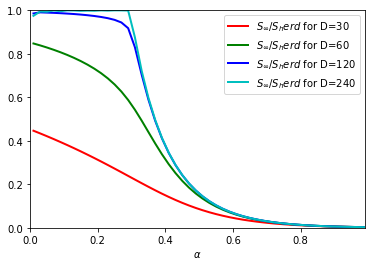

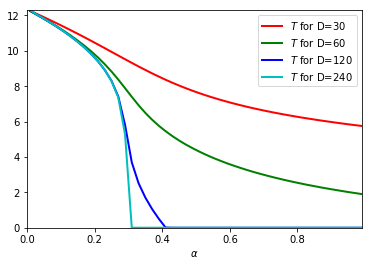

In [22]:
#graphique S infini et T en fonction de alpha (figure 3-4)

# parameters
NT=int(50001) # number of time step
nb_alpha = 50
min_alpha = 0.01
max_alpha = 0.99
alpha_array = np.linspace(min_alpha,max_alpha,nb_alpha)
D_array=[30,60,120,240]
color_plt=['r-','g-','b-','c-','m-','y-','b--','g--','r--']
color_tikz=['red','black!60!green','blue','black','brown']
R0_array=[1.5, 2, 2.5, 3.5, 4.5, 6 ,8, 10]

#for ind_R0 in range(len(R0_array)):
ind_R0=6
RR0=R0_array[ind_R0]
S_herd=1.0/RR0
beta=RR0*nu
# Computation of T Sinf theoretical
S_inf_rel_theo_array =  np.zeros((len(D_array),len(alpha_array)))
T_theo_array =  np.zeros((len(D_array),len(alpha_array)))
for ind_alpha in range(len(alpha_array)):
    alpha = alpha_array[ind_alpha]
    for ind_D in range(len(D_array)):
        D = D_array[ind_D]
        h = D/NT        #the time step
        print('##############################################')
        print('Iteration '+str(ind_D+1)+'/'+str(len(D_array))+' and '+str(ind_alpha+1)+'/'+str(len(alpha_array))+" and R0="+str(RR0))
        print('##############################################')  
        S_inf, T, u, Jval, yval = exact_value_T(D,alpha,Init)
        print("T=",T)
        print('S_inf=',S_inf)
        S_inf_rel_theo_array[ind_D,ind_alpha] = S_inf/S_herd
        T_theo_array[ind_D,ind_alpha] = T

# post processing - resultats et figures
# Plot
plt.figure(2*ind_R0+1)
for ind_D in range(len(D_array)):
    plt.plot(alpha_array,S_inf_rel_theo_array[ind_D,:],'{0}'.format(color_plt[ind_D]),linewidth=2,label=r'$S_\infty/S_herd$ for D={0}'.format(D_array[ind_D]))
plt.legend(loc='best')
plt.xlabel(r'$\alpha$')
plt.axis([0, max(alpha_array),0.0, np.max(S_inf_rel_theo_array)])
plt.savefig("fig3_simu_covid_S_infinity_rel_with_respect_to_alpha_R0_{0}.png".format(10*RR0))
plt.figure(2*ind_R0+2)
for ind_D in range(len(D_array)):
    plt.plot(alpha_array,T_theo_array[ind_D,:],'{0}'.format(color_plt[ind_D]),linewidth=2,label=r'$T$ for D={0}'.format(D_array[ind_D]))
plt.legend(loc='best')
plt.xlabel(r'$\alpha$')
plt.axis([0, max(alpha_array), 0.0, np.max(T_theo_array)])
plt.savefig("fig4_simu_covid_T_with_respect_to_alpha_R0_{0}.png".format(10*RR0))
plt.show()

# Save the values for tikz
File = open('fig3_simu_covid_S_infinity_rel_with_respect_to_alpha_R0_{0}.txt'.format(10*RR0),'w')
for ind_D in range(len(D_array)):
    File.write('\\addplot[color={0}'.format(color_tikz[ind_D]))
    File.write(' ]coordinates { ')
    write_to_file(File,alpha_array,S_inf_rel_theo_array[ind_D,:])
    File.write(' };\n\n')
File.close()
File = open('fig4_simu_covid_T_with_respect_to_alpha_R0_{0}.txt'.format(10*RR0),'w')
for ind_D in range(len(D_array)):
    File.write('\\addplot[color={0}'.format(color_tikz[ind_D]))
    File.write(' ]coordinates { ')
    write_to_file(File,alpha_array,T_theo_array[ind_D,:])
    File.write(' };\n\n')
File.close()




##############################################
Iteration 1/4 and 1/50 and R0=10
##############################################
('T=', 9.7870042599148)
('S_inf=', 0.03819274964151001)
##############################################
Iteration 2/4 and 1/50 and R0=10
##############################################
('T=', 9.77740445191096)
('S_inf=', 0.0823455812312317)
##############################################
Iteration 3/4 and 1/50 and R0=10
##############################################
('T=', 9.784604307913842)
('S_inf=', 0.09845275880453494)
##############################################
Iteration 4/4 and 1/50 and R0=10
##############################################
('T=', 9.80140397192056)
('S_inf=', 0.09775695803024292)
##############################################
Iteration 1/4 and 2/50 and R0=10
##############################################
('T=', 9.611207775844482)
('S_inf=', 0.03688659731082153)
##############################################
Iteration 2/4 and 2/50 and R0=10


('T=', 7.712845743085138)
('S_inf=', 0.021554566214141847)
##############################################
Iteration 2/4 and 12/50 and R0=10
##############################################
('T=', 6.631067378652427)
('S_inf=', 0.06164855995382691)
##############################################
Iteration 3/4 and 12/50 and R0=10
##############################################
('T=', 5.978280434391312)
('S_inf=', 0.09501647954202272)
##############################################
Iteration 4/4 and 12/50 and R0=10
##############################################
('T=', 5.956680866382672)
('S_inf=', 0.09993591308657837)
##############################################
Iteration 1/4 and 13/50 and R0=10
##############################################
('T=', 7.51544969100618)
('S_inf=', 0.019839478340667724)
##############################################
Iteration 2/4 and 13/50 and R0=10
##############################################
('T=', 6.16667666646667)
('S_inf=', 0.05726013226333618)
############

('T=', 5.933881322373552)
('S_inf=', 0.005776978481292725)
##############################################
Iteration 2/4 and 23/50 and R0=10
##############################################
('T=', 3.2495350092998136)
('S_inf=', 0.010739136634796143)
##############################################
Iteration 3/4 and 23/50 and R0=10
##############################################
('T=', 0.0023999520009599807)
('S_inf=', 0.011624146391571045)
##############################################
Iteration 4/4 and 23/50 and R0=10
##############################################
('T=', 0.004799904001919961)
('S_inf=', 0.01163024990713501)
##############################################
Iteration 1/4 and 24/50 and R0=10
##############################################
('T=', 5.824083518329633)
('S_inf=', 0.004940796849029541)
##############################################
Iteration 2/4 and 24/50 and R0=10
##############################################
('T=', 3.103137937241255)
('S_inf=', 0.008804322201019288)

('T=', 5.0404991900162)
('S_inf=', 0.0009063730612487793)
##############################################
Iteration 2/4 and 34/50 and R0=10
##############################################
('T=', 2.107157856842863)
('S_inf=', 0.0011993418083190918)
##############################################
Iteration 3/4 and 34/50 and R0=10
##############################################
('T=', 0.0023999520009599807)
('S_inf=', 0.001229859386138916)
##############################################
Iteration 4/4 and 34/50 and R0=10
##############################################
('T=', 0.004799904001919961)
('S_inf=', 0.001229859386138916)
##############################################
Iteration 1/4 and 35/50 and R0=10
##############################################
('T=', 4.98290034199316)
('S_inf=', 0.000759888687713623)
##############################################
Iteration 2/4 and 35/50 and R0=10
##############################################
('T=', 2.0375592488150236)
('S_inf=', 0.0009857187635803222

('T=', 4.528709425811484)
('S_inf=', 0.0001251230690612793)
##############################################
Iteration 2/4 and 45/50 and R0=10
##############################################
('T=', 1.487970240595188)
('S_inf=', 0.00013122658462524412)
##############################################
Iteration 3/4 and 45/50 and R0=10
##############################################
('T=', 0.0023999520009599807)
('S_inf=', 0.000137330100189209)
##############################################
Iteration 4/4 and 45/50 and R0=10
##############################################
('T=', 0.004799904001919961)
('S_inf=', 0.000137330100189209)
##############################################
Iteration 1/4 and 46/50 and R0=10
##############################################
('T=', 4.4927101457970835)
('S_inf=', 0.00010070900680541992)
##############################################
Iteration 2/4 and 46/50 and R0=10
##############################################
('T=', 1.4447711045779084)
('S_inf=', 0.000106812522

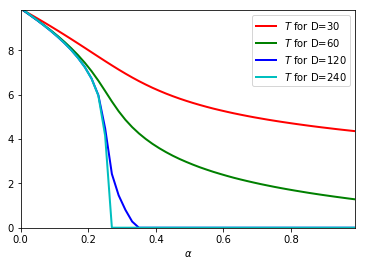

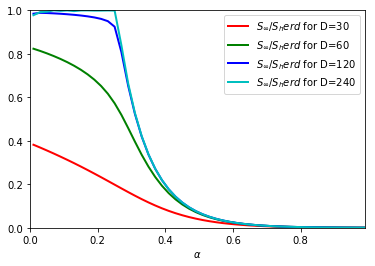

In [13]:
#graphique S infini et T en fonction de alpha (figure 3-4)

# parameters
NT=int(50001) # number of time step
nb_alpha = 50
min_alpha = 0.01
max_alpha = 0.99
alpha_array = np.linspace(min_alpha,max_alpha,nb_alpha)
D_array=[30,60,120,240]
color_plt=['r-','g-','b-','c-','m-','y-','b--','g--','r--']
color_tikz=['red','black!60!green','blue','black','brown']
R0_array=[1.5, 2, 2.5, 3.5, 4.5, 6 ,8, 10]

#for ind_R0 in range(len(R0_array)):
ind_R0=7
RR0=R0_array[ind_R0]
S_herd=1.0/RR0
beta=RR0*nu
# Computation of T Sinf theoretical
S_inf_rel_theo_array =  np.zeros((len(D_array),len(alpha_array)))
T_theo_array =  np.zeros((len(D_array),len(alpha_array)))
for ind_alpha in range(len(alpha_array)):
    alpha = alpha_array[ind_alpha]
    for ind_D in range(len(D_array)):
        D = D_array[ind_D]
        h = D/NT        #the time step
        print('##############################################')
        print('Iteration '+str(ind_D+1)+'/'+str(len(D_array))+' and '+str(ind_alpha+1)+'/'+str(len(alpha_array))+" and R0="+str(RR0))
        print('##############################################')  
        S_inf, T, u, Jval, yval = exact_value_T(D,alpha,Init)
        print("T=",T)
        print('S_inf=',S_inf)
        S_inf_rel_theo_array[ind_D,ind_alpha] = S_inf/S_herd
        T_theo_array[ind_D,ind_alpha] = T

# post processing - resultats et figures
# Plot
plt.figure(2*ind_R0+1)
for ind_D in range(len(D_array)):
    plt.plot(alpha_array,S_inf_rel_theo_array[ind_D,:],'{0}'.format(color_plt[ind_D]),linewidth=2,label=r'$S_\infty/S_herd$ for D={0}'.format(D_array[ind_D]))
plt.legend(loc='best')
plt.xlabel(r'$\alpha$')
plt.axis([0, max(alpha_array),0.0, np.max(S_inf_rel_theo_array)])
plt.savefig("fig3_simu_covid_S_infinity_rel_with_respect_to_alpha_R0_{0}.png".format(10*RR0))
plt.figure(2*ind_R0+2)
for ind_D in range(len(D_array)):
    plt.plot(alpha_array,T_theo_array[ind_D,:],'{0}'.format(color_plt[ind_D]),linewidth=2,label=r'$T$ for D={0}'.format(D_array[ind_D]))
plt.legend(loc='best')
plt.xlabel(r'$\alpha$')
plt.axis([0, max(alpha_array), 0.0, np.max(T_theo_array)])
plt.savefig("fig4_simu_covid_T_with_respect_to_alpha_R0_{0}.png".format(10*RR0))
plt.show()

# Save the values for tikz
File = open('fig3_simu_covid_S_infinity_rel_with_respect_to_alpha_R0_{0}.txt'.format(10*RR0),'w')
for ind_D in range(len(D_array)):
    File.write('\\addplot[color={0}'.format(color_tikz[ind_D]))
    File.write(' ]coordinates { ')
    write_to_file(File,alpha_array,S_inf_rel_theo_array[ind_D,:])
    File.write(' };\n\n')
File.close()
File = open('fig4_simu_covid_T_with_respect_to_alpha_R0_{0}.txt'.format(10*RR0),'w')
for ind_D in range(len(D_array)):
    File.write('\\addplot[color={0}'.format(color_tikz[ind_D]))
    File.write(' ]coordinates { ')
    write_to_file(File,alpha_array,T_theo_array[ind_D,:])
    File.write(' };\n\n')
File.close()




Argmin de J pour D=100: [17.941 15.071  7.894  6.459  5.741]


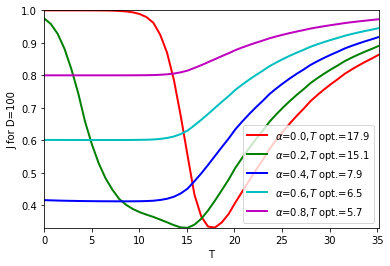

In [10]:
# calcul de J pour toute les valeurs de T (figure 5)

# parameters
Init=np.array([S0, I0,R0]) 
alpha  = 0.0
NT=int(1001) # number of time step
D=100
h = D/NT        #the time step
alpha_array = np.linspace(0,0.8,5)
color=['r-','g-','b-','c-','m-','y-','r--','g--','b--','c--','m--','y--']
color_tikz=['red','black!60!green','blue','black','brown','yellow','purple','cyan','orange','gray']



T_ind_max = 2*T_max_ind(Init)
T_array = np.linspace(0,h*T_ind_max,50)
Jval_array = np.zeros((len(T_array),len(alpha_array)))
argmin_J = np.zeros(len(alpha_array))
for ind_alpha in range(len(alpha_array)):
    alpha = alpha_array[ind_alpha]
    for T_ind in range(len(T_array)):
        T = T_array[T_ind]
        u=np.ones(int(T/h)+NT)
        for ii in range(int(T/h),int(T/h)+NT):
            u[ii]=alpha
        yval=RK4_state(u,Init)
        Jval=J(yval)
        #print(Jval)
        Jval_array[T_ind,ind_alpha] = Jval
    ind_min = np.argmin(Jval_array[:,ind_alpha])
    argmin_J[ind_alpha] = T_array[ind_min]



# Plot
plt.figure(1)
for ind_alpha in range(len(alpha_array)):
    plt.plot(T_array,Jval_array[:,ind_alpha],'{0}'.format(color[ind_alpha]),linewidth=2,label=r'$\alpha$={0},$T$ opt.={1}'.format(alpha_array[ind_alpha],round(argmin_J[ind_alpha],1)))
plt.legend(loc='best')
plt.xlabel('T')
plt.ylabel('J for D={0}'.format(D))
plt.axis([0,T,np.min(Jval_array),np.max(Jval_array)])
plt.savefig("fig5_simu_covid_values_J_D_{0}.png".format(D))

# Save the values for tikz
File = open('fig5_simu_covid_values_J_D_{0}.txt'.format(D),'w')
for ind_alpha in range(len(alpha_array)):
    File.write('\\addplot[color={0}]'.format(color_tikz[ind_alpha]))
    File.write(' coordinates { ')
    write_to_file(File,T_array,Jval_array[:,ind_alpha])
    File.write(' };\n\n')
File.close()

print('Argmin de J pour D={0}: '.format(D)+str(np.round(argmin_J,3)))





Argmin de J pour D=200: [17.941 15.071  0.718  0.     0.   ]


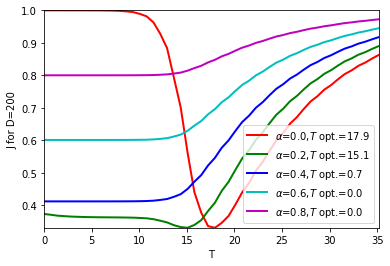

In [11]:
# calcul de J pour toute les valeurs de T (figure 5)

# parameters
Init=np.array([S0, I0,R0]) 
NT=int(1001) # number of time step
D=200
h = D/NT        #the time step
alpha_array = np.linspace(0,0.8,5)
color=['r-','g-','b-','c-','m-','y-','r--','g--','b--','c--','m--','y--']
color_tikz=['red','black!60!green','blue','black','brown','yellow','purple','cyan','orange','gray']



T_ind_max = 2*T_max_ind(Init)
T_array = np.linspace(0,h*T_ind_max,50)
Jval_array = np.zeros((len(T_array),len(alpha_array)))
argmin_J = np.zeros(len(alpha_array))
for ind_alpha in range(len(alpha_array)):
    alpha = alpha_array[ind_alpha]
    for T_ind in range(len(T_array)):
        T = T_array[T_ind]
        u=np.ones(int(T/h)+NT)
        for ii in range(int(T/h),int(T/h)+NT):
            u[ii]=alpha
        yval=RK4_state(u,Init)
        Jval=J(yval)
        #print(Jval)
        Jval_array[T_ind,ind_alpha] = Jval
    ind_min = np.argmin(Jval_array[:,ind_alpha])
    argmin_J[ind_alpha] = T_array[ind_min]



# Plot
plt.figure(1)
for ind_alpha in range(len(alpha_array)):
    plt.plot(T_array,Jval_array[:,ind_alpha],'{0}'.format(color[ind_alpha]),linewidth=2,label=r'$\alpha$={0},$T$ opt.={1}'.format(alpha_array[ind_alpha],round(argmin_J[ind_alpha],1)))
plt.legend(loc='best')
plt.xlabel('T')
plt.ylabel('J for D={0}'.format(D))
plt.axis([0,T,np.min(Jval_array),np.max(Jval_array)])
plt.savefig("fig5_simu_covid_values_J_D_{0}.png".format(D))

# Save the values for tikz
File = open('fig5_simu_covid_values_J_D_{0}.txt'.format(D),'w')
for ind_alpha in range(len(alpha_array)):
    File.write('\\addplot[color={0}]'.format(color_tikz[ind_alpha]))
    File.write(' coordinates { ')
    write_to_file(File,T_array,Jval_array[:,ind_alpha])
    File.write(' };\n\n')
File.close()

print('Argmin de J pour D={0}: '.format(D)+str(np.round(argmin_J,3)))





('I0', 1.4925373134328358e-07)
('alpha', 0.0)
##############################################
Iteration 1/100 and 1/5
##############################################
(1007, 5001)
('T=', 20.13597280543891)
('S_inf=', 0.09747009279873659)
('I0', 1.5223880597014925e-05)
('alpha', 0.0)
##############################################
Iteration 2/100 and 1/5
##############################################
(750, 5001)
('T=', 14.997000599880023)
('S_inf=', 0.09747009279873659)
('I0', 3.0298507462686567e-05)
('alpha', 0.0)
##############################################
Iteration 3/100 and 1/5
##############################################
(711, 5001)
('T=', 14.217156568686262)
('S_inf=', 0.09753112795437621)
('I0', 4.537313432835821e-05)
('alpha', 0.0)
##############################################
Iteration 4/100 and 1/5
##############################################
(689, 5001)
('T=', 13.777244551089781)
('S_inf=', 0.0975372314699402)
('I0', 6.044776119402985e-05)
('alpha', 0.0)
#################

('T=', 11.037792441511698)
('S_inf=', 0.09754333498550416)
('I0', 0.0005428358208955224)
('alpha', 0.0)
##############################################
Iteration 37/100 and 1/5
##############################################
(551, 5001)
('T=', 11.017796440711857)
('S_inf=', 0.09749450686099242)
('I0', 0.000557910447761194)
('alpha', 0.0)
##############################################
Iteration 38/100 and 1/5
##############################################
(549, 5001)
('T=', 10.977804439112177)
('S_inf=', 0.09754943850106812)
('I0', 0.0005729850746268657)
('alpha', 0.0)
##############################################
Iteration 39/100 and 1/5
##############################################
(548, 5001)
('T=', 10.957808438312338)
('S_inf=', 0.09748840334542846)
('I0', 0.0005880597014925374)
('alpha', 0.0)
##############################################
Iteration 40/100 and 1/5
##############################################
(546, 5001)
('T=', 10.917816436712657)
('S_inf=', 0.09754943850106812)
('

('T=', 10.257948410317935)
('S_inf=', 0.09750061037655641)
('I0', 0.0010704477611940299)
('alpha', 0.0)
##############################################
Iteration 72/100 and 1/5
##############################################
(513, 5001)
('T=', 10.257948410317935)
('S_inf=', 0.09748840334542846)
('I0', 0.0010855223880597016)
('alpha', 0.0)
##############################################
Iteration 73/100 and 1/5
##############################################
(512, 5001)
('T=', 10.237952409518096)
('S_inf=', 0.0975372314699402)
('I0', 0.0011005970149253733)
('alpha', 0.0)
##############################################
Iteration 74/100 and 1/5
##############################################
(511, 5001)
('T=', 10.217956408718257)
('S_inf=', 0.09754943850106812)
('I0', 0.0011156716417910447)
('alpha', 0.0)
##############################################
Iteration 75/100 and 1/5
##############################################
(510, 5001)
('T=', 10.197960407918416)
('S_inf=', 0.09752502443881225)
('

('T=', 9.138172365526895)
('S_inf=', 0.08948669444107055)
('I0', 0.00010567164179104477)
('alpha', 0.231)
##############################################
Iteration 8/100 and 2/5
##############################################
('T=', 8.998200359928013)
('S_inf=', 0.08946838389437867)
('I0', 0.00012074626865671642)
('alpha', 0.231)
##############################################
Iteration 9/100 and 2/5
##############################################
('T=', 8.818236352729453)
('S_inf=', 0.08948669444107055)
('I0', 0.00013582089552238808)
('alpha', 0.231)
##############################################
Iteration 10/100 and 2/5
##############################################
('T=', 8.698260347930413)
('S_inf=', 0.08948669444107055)
('I0', 0.00015089552238805971)
('alpha', 0.231)
##############################################
Iteration 11/100 and 2/5
##############################################
('T=', 8.598280343931213)
('S_inf=', 0.08946838389437867)
('I0', 0.00016597014925373135)
('alpha', 0.2

('T=', 6.958608278344331)
('S_inf=', 0.08947448740994263)
('I0', 0.0006634328358208955)
('alpha', 0.231)
##############################################
Iteration 45/100 and 2/5
##############################################
('T=', 6.9386122775444905)
('S_inf=', 0.08946838389437867)
('I0', 0.0006785074626865672)
('alpha', 0.231)
##############################################
Iteration 46/100 and 2/5
##############################################
('T=', 6.89862027594481)
('S_inf=', 0.08947448740994263)
('I0', 0.0006935820895522389)
('alpha', 0.231)
##############################################
Iteration 47/100 and 2/5
##############################################
('T=', 6.87862427514497)
('S_inf=', 0.08947448740994263)
('I0', 0.0007086567164179105)
('alpha', 0.231)
##############################################
Iteration 48/100 and 2/5
##############################################
('T=', 6.838632273545291)
('S_inf=', 0.08947448740994263)
('I0', 0.0007237313432835821)
('alpha', 0.231)


('T=', 6.25874825034993)
('S_inf=', 0.08946228037881471)
('I0', 0.0012211940298507463)
('alpha', 0.231)
##############################################
Iteration 82/100 and 2/5
##############################################
('T=', 6.23875224955009)
('S_inf=', 0.08946228037881471)
('I0', 0.001236268656716418)
('alpha', 0.231)
##############################################
Iteration 83/100 and 2/5
##############################################
('T=', 6.23875224955009)
('S_inf=', 0.08945617686325075)
('I0', 0.0012513432835820895)
('alpha', 0.231)
##############################################
Iteration 84/100 and 2/5
##############################################
('T=', 6.19876024795041)
('S_inf=', 0.08946228037881471)
('I0', 0.0012664179104477612)
('alpha', 0.231)
##############################################
Iteration 85/100 and 2/5
##############################################
('T=', 6.21875624875025)
('S_inf=', 0.0894439698321228)
('I0', 0.0012814925373134329)
('alpha', 0.231)
######

('T=', 2.459508098380324)
('S_inf=', 0.01966857990487671)
('I0', 0.00027149253731343286)
('alpha', 0.4)
##############################################
Iteration 19/100 and 3/5
##############################################
('T=', 2.3995200959808036)
('S_inf=', 0.019662476389312747)
('I0', 0.0002865671641791045)
('alpha', 0.4)
##############################################
Iteration 20/100 and 3/5
##############################################
('T=', 2.339532093581284)
('S_inf=', 0.019662476389312747)
('I0', 0.00030164179104477613)
('alpha', 0.4)
##############################################
Iteration 21/100 and 3/5
##############################################
('T=', 2.2995400919816036)
('S_inf=', 0.019662476389312747)
('I0', 0.00031671641791044777)
('alpha', 0.4)
##############################################
Iteration 22/100 and 3/5
##############################################
('T=', 2.2595480903819234)
('S_inf=', 0.019662476389312747)
('I0', 0.0003317910447761194)
('alpha', 0.4)

('T=', 1.1997600479904018)
('S_inf=', 0.019625855295928956)
('I0', 0.0008292537313432836)
('alpha', 0.4)
##############################################
Iteration 56/100 and 3/5
##############################################
('T=', 1.1797640471905617)
('S_inf=', 0.019625855295928956)
('I0', 0.0008443283582089552)
('alpha', 0.4)
##############################################
Iteration 57/100 and 3/5
##############################################
('T=', 1.1397720455908817)
('S_inf=', 0.019625855295928956)
('I0', 0.0008594029850746269)
('alpha', 0.4)
##############################################
Iteration 58/100 and 3/5
##############################################
('T=', 1.1397720455908817)
('S_inf=', 0.019625855295928956)
('I0', 0.0008744776119402986)
('alpha', 0.4)
##############################################
Iteration 59/100 and 3/5
##############################################
('T=', 1.0997800439912018)
('S_inf=', 0.019619751780364993)
('I0', 0.0008895522388059702)
('alpha', 0.4)

('T=', 0.5998800239952009)
('S_inf=', 0.019589234202545165)
('I0', 0.0013870149253731345)
('alpha', 0.4)
##############################################
Iteration 93/100 and 3/5
##############################################
('T=', 0.5998800239952009)
('S_inf=', 0.019589234202545165)
('I0', 0.001402089552238806)
('alpha', 0.4)
##############################################
Iteration 94/100 and 3/5
##############################################
('T=', 0.5998800239952009)
('S_inf=', 0.019583130686981202)
('I0', 0.0014171641791044776)
('alpha', 0.4)
##############################################
Iteration 95/100 and 3/5
##############################################
('T=', 0.5598880223955208)
('S_inf=', 0.019583130686981202)
('I0', 0.0014322388059701493)
('alpha', 0.4)
##############################################
Iteration 96/100 and 3/5
##############################################
('T=', 0.5598880223955208)
('S_inf=', 0.019583130686981202)
('I0', 0.001447313432835821)
('alpha', 0.4)
#

('T=', 0.1399720055988802)
('S_inf=', 0.002505494139007568)
('I0', 0.00043731343283582094)
('alpha', 0.6)
##############################################
Iteration 30/100 and 4/5
##############################################
('T=', 0.09998000399920015)
('S_inf=', 0.002505494139007568)
('I0', 0.0004523880597014926)
('alpha', 0.6)
##############################################
Iteration 31/100 and 4/5
##############################################
('T=', 0.059988002399520096)
('S_inf=', 0.002505494139007568)
('I0', 0.0004674626865671642)
('alpha', 0.6)
##############################################
Iteration 32/100 and 4/5
##############################################
('T=', 0.01999600079984003)
('S_inf=', 0.002505494139007568)
('I0', 0.00048253731343283584)
('alpha', 0.6)
##############################################
Iteration 33/100 and 4/5
##############################################
('T=', 0.01999600079984003)
('S_inf=', 0.002505494139007568)
('I0', 0.0004976119402985075)
('alpha

('T=', 0.01999600079984003)
('S_inf=', 0.002499390623443604)
('I0', 0.0009950746268656717)
('alpha', 0.6)
##############################################
Iteration 67/100 and 4/5
##############################################
('T=', 0.01999600079984003)
('S_inf=', 0.002499390623443604)
('I0', 0.0010101492537313433)
('alpha', 0.6)
##############################################
Iteration 68/100 and 4/5
##############################################
('T=', 0.01999600079984003)
('S_inf=', 0.002499390623443604)
('I0', 0.001025223880597015)
('alpha', 0.6)
##############################################
Iteration 69/100 and 4/5
##############################################
('T=', 0.01999600079984003)
('S_inf=', 0.002499390623443604)
('I0', 0.0010402985074626865)
('alpha', 0.6)
##############################################
Iteration 70/100 and 4/5
##############################################
('T=', 0.01999600079984003)
('S_inf=', 0.002499390623443604)
('I0', 0.0010553731343283582)
('alpha', 

('T=', 2.1595680863827234)
('S_inf=', 0.0003387461138000488)
('I0', 4.537313432835821e-05)
('alpha', 0.8)
##############################################
Iteration 4/100 and 5/5
##############################################
('T=', 1.6996600679864027)
('S_inf=', 0.0003387461138000488)
('I0', 6.044776119402985e-05)
('alpha', 0.8)
##############################################
Iteration 5/100 and 5/5
##############################################
('T=', 1.3797240551889622)
('S_inf=', 0.0003387461138000488)
('I0', 7.552238805970149e-05)
('alpha', 0.8)
##############################################
Iteration 6/100 and 5/5
##############################################
('T=', 1.1397720455908817)
('S_inf=', 0.0003387461138000488)
('I0', 9.059701492537314e-05)
('alpha', 0.8)
##############################################
Iteration 7/100 and 5/5
##############################################
('T=', 0.9598080383923215)
('S_inf=', 0.0003387461138000488)
('I0', 0.00010567164179104477)
('alpha', 0.

('T=', 0.01999600079984003)
('S_inf=', 0.00033264259823608395)
('I0', 0.000603134328358209)
('alpha', 0.8)
##############################################
Iteration 41/100 and 5/5
##############################################
('T=', 0.01999600079984003)
('S_inf=', 0.00033264259823608395)
('I0', 0.0006182089552238807)
('alpha', 0.8)
##############################################
Iteration 42/100 and 5/5
##############################################
('T=', 0.01999600079984003)
('S_inf=', 0.00033264259823608395)
('I0', 0.0006332835820895522)
('alpha', 0.8)
##############################################
Iteration 43/100 and 5/5
##############################################
('T=', 0.01999600079984003)
('S_inf=', 0.00033264259823608395)
('I0', 0.0006483582089552239)
('alpha', 0.8)
##############################################
Iteration 44/100 and 5/5
##############################################
('T=', 0.01999600079984003)
('S_inf=', 0.00033264259823608395)
('I0', 0.0006634328358208955)


('T=', 0.01999600079984003)
('S_inf=', 0.00033264259823608395)
('I0', 0.0011608955223880598)
('alpha', 0.8)
##############################################
Iteration 78/100 and 5/5
##############################################
('T=', 0.01999600079984003)
('S_inf=', 0.00033264259823608395)
('I0', 0.0011759701492537315)
('alpha', 0.8)
##############################################
Iteration 79/100 and 5/5
##############################################
('T=', 0.01999600079984003)
('S_inf=', 0.00033264259823608395)
('I0', 0.001191044776119403)
('alpha', 0.8)
##############################################
Iteration 80/100 and 5/5
##############################################
('T=', 0.01999600079984003)
('S_inf=', 0.00033264259823608395)
('I0', 0.0012061194029850746)
('alpha', 0.8)
##############################################
Iteration 81/100 and 5/5
##############################################
('T=', 0.01999600079984003)
('S_inf=', 0.00033264259823608395)
('I0', 0.0012211940298507463)


('J', 0.33)
('T', 12.29754049190162)
('S_inf', 0.09670715335324098)
##############################################
Iteration J Num 13/100 and 1/5
##############################################
('I0', 0.000181044776119403)
('alpha', 0.0)
('T_ind_max', 612)
('J', 0.33)
('T', 12.197560487902418)
('S_inf', 0.09656677249526976)
##############################################
Iteration J Num 14/100 and 1/5
##############################################
('I0', 0.00019611940298507464)
('alpha', 0.0)
('T_ind_max', 607)
('J', 0.33)
('T', 12.097580483903219)
('S_inf', 0.09602355961007691)
##############################################
Iteration J Num 15/100 and 1/5
##############################################
('I0', 0.00021119402985074628)
('alpha', 0.0)
('T_ind_max', 603)
('J', 0.33)
('T', 12.017596480703858)
('S_inf', 0.09615173343692018)
##############################################
Iteration J Num 16/100 and 1/5
##############################################
('I0', 0.00022626865671641794)
(

('J', 0.33)
('T', 10.777844431113776)
('S_inf', 0.09670104983767702)
##############################################
Iteration J Num 45/100 and 1/5
##############################################
('I0', 0.0006634328358208955)
('alpha', 0.0)
('T_ind_max', 539)
('J', 0.33)
('T', 10.737852429514097)
('S_inf', 0.096005249063385)
##############################################
Iteration J Num 46/100 and 1/5
##############################################
('I0', 0.0006785074626865672)
('alpha', 0.0)
('T_ind_max', 538)
('J', 0.33)
('T', 10.717856428714256)
('S_inf', 0.0962677002326355)
##############################################
Iteration J Num 47/100 and 1/5
##############################################
('I0', 0.0006935820895522389)
('alpha', 0.0)
('T_ind_max', 537)
('J', 0.33)
('T', 10.697860427914417)
('S_inf', 0.09649353030850219)
##############################################
Iteration J Num 48/100 and 1/5
##############################################
('I0', 0.0007086567164179105)
('alp

('J', 0.33)
('T', 10.157968406318735)
('S_inf', 0.09683532718008422)
##############################################
Iteration J Num 77/100 and 1/5
##############################################
('I0', 0.001145820895522388)
('alpha', 0.0)
('T_ind_max', 509)
('J', 0.33)
('T', 10.137972405518896)
('S_inf', 0.09660949710421754)
##############################################
Iteration J Num 78/100 and 1/5
##############################################
('I0', 0.0011608955223880598)
('alpha', 0.0)
('T_ind_max', 508)
('J', 0.33)
('T', 10.117976404719055)
('S_inf', 0.09635925296609496)
##############################################
Iteration J Num 79/100 and 1/5
##############################################
('I0', 0.0011759701492537315)
('alpha', 0.0)
('T_ind_max', 507)
('J', 0.33)
('T', 10.097980403919216)
('S_inf', 0.09607849125015258)
##############################################
Iteration J Num 80/100 and 1/5
##############################################
('I0', 0.001191044776119403)
('al

('J', 0.331)
('T', 8.978204359128174)
('S_inf', 0.08948669444107055)
##############################################
Iteration J Num 9/100 and 2/5
##############################################
('I0', 0.00012074626865671642)
('alpha', 0.231)
('T_ind_max', 634)
('J', 0.331)
('T', 8.818236352729453)
('S_inf', 0.08948669444107055)
##############################################
Iteration J Num 10/100 and 2/5
##############################################
('I0', 0.00013582089552238808)
('alpha', 0.231)
('T_ind_max', 628)
('J', 0.331)
('T', 8.698260347930413)
('S_inf', 0.08948669444107055)
##############################################
Iteration J Num 11/100 and 2/5
##############################################
('I0', 0.00015089552238805971)
('alpha', 0.231)
('T_ind_max', 622)
('J', 0.331)
('T', 8.578284343131374)
('S_inf', 0.08948669444107055)
##############################################
Iteration J Num 12/100 and 2/5
##############################################
('I0', 0.000165970149253

('J', 0.331)
('T', 7.038592281543691)
('S_inf', 0.08946838389437867)
##############################################
Iteration J Num 41/100 and 2/5
##############################################
('I0', 0.000603134328358209)
('alpha', 0.231)
('T_ind_max', 545)
('J', 0.331)
('T', 7.018596280743851)
('S_inf', 0.08947448740994263)
##############################################
Iteration J Num 42/100 and 2/5
##############################################
('I0', 0.0006182089552238807)
('alpha', 0.231)
('T_ind_max', 543)
('J', 0.331)
('T', 6.998600279944011)
('S_inf', 0.08947448740994263)
##############################################
Iteration J Num 43/100 and 2/5
##############################################
('I0', 0.0006332835820895522)
('alpha', 0.231)
('T_ind_max', 542)
('J', 0.331)
('T', 6.958608278344331)
('S_inf', 0.08946838389437867)
##############################################
Iteration J Num 44/100 and 2/5
##############################################
('I0', 0.000648358208955223

('J', 0.331)
('T', 6.37872425514897)
('S_inf', 0.08946838389437867)
##############################################
Iteration J Num 73/100 and 2/5
##############################################
('I0', 0.0010855223880597016)
('alpha', 0.231)
('T_ind_max', 512)
('J', 0.331)
('T', 6.3587282543491295)
('S_inf', 0.08946228037881471)
##############################################
Iteration J Num 74/100 and 2/5
##############################################
('I0', 0.0011005970149253733)
('alpha', 0.231)
('T_ind_max', 511)
('J', 0.331)
('T', 6.3587282543491295)
('S_inf', 0.08946228037881471)
##############################################
Iteration J Num 75/100 and 2/5
##############################################
('I0', 0.0011156716417910447)
('alpha', 0.231)
('T_ind_max', 510)
('J', 0.331)
('T', 6.31873625274945)
('S_inf', 0.08945617686325075)
##############################################
Iteration J Num 76/100 and 2/5
##############################################
('I0', 0.00113074626865671

('J', 0.412)
('T', 4.399120175964807)
('S_inf', 0.01968078693600464)
##############################################
Iteration J Num 5/100 and 3/5
##############################################
('I0', 6.044776119402985e-05)
('alpha', 0.4)
('T_ind_max', 673)
('J', 0.412)
('T', 4.079184163167366)
('S_inf', 0.01968078693600464)
##############################################
Iteration J Num 6/100 and 3/5
##############################################
('I0', 7.552238805970149e-05)
('alpha', 0.4)
('T_ind_max', 660)
('J', 0.412)
('T', 3.839232153569286)
('S_inf', 0.01968078693600464)
##############################################
Iteration J Num 7/100 and 3/5
##############################################
('I0', 9.059701492537314e-05)
('alpha', 0.4)
('T_ind_max', 650)
('J', 0.413)
('T', 3.6192761447710455)
('S_inf', 0.01968078693600464)
##############################################
Iteration J Num 8/100 and 3/5
##############################################
('I0', 0.00010567164179104477)
('al

('J', 0.413)
('T', 1.6596680663867225)
('S_inf', 0.019650269358184817)
##############################################
Iteration J Num 37/100 and 3/5
##############################################
('I0', 0.0005428358208955224)
('alpha', 0.4)
('T_ind_max', 551)
('J', 0.413)
('T', 1.6396720655868826)
('S_inf', 0.019644165842620853)
##############################################
Iteration J Num 38/100 and 3/5
##############################################
('I0', 0.000557910447761194)
('alpha', 0.4)
('T_ind_max', 549)
('J', 0.413)
('T', 1.6196760647870425)
('S_inf', 0.019644165842620853)
##############################################
Iteration J Num 39/100 and 3/5
##############################################
('I0', 0.0005729850746268657)
('alpha', 0.4)
('T_ind_max', 548)
('J', 0.413)
('T', 1.5796840631873625)
('S_inf', 0.019644165842620853)
##############################################
Iteration J Num 40/100 and 3/5
##############################################
('I0', 0.0005880597014925

('J', 0.413)
('T', 0.9398120375924814)
('S_inf', 0.019613648264801026)
##############################################
Iteration J Num 69/100 and 3/5
##############################################
('I0', 0.001025223880597015)
('alpha', 0.4)
('T_ind_max', 515)
('J', 0.413)
('T', 0.9398120375924814)
('S_inf', 0.019613648264801026)
##############################################
Iteration J Num 70/100 and 3/5
##############################################
('I0', 0.0010402985074626865)
('alpha', 0.4)
('T_ind_max', 514)
('J', 0.413)
('T', 0.9198160367926415)
('S_inf', 0.019613648264801026)
##############################################
Iteration J Num 71/100 and 3/5
##############################################
('I0', 0.0010553731343283582)
('alpha', 0.4)
('T_ind_max', 513)
('J', 0.413)
('T', 0.8998200359928014)
('S_inf', 0.019607544749237062)
##############################################
Iteration J Num 72/100 and 3/5
##############################################
('I0', 0.0010704477611940

('J', 0.413)
('T', 0.5198960207958409)
('S_inf', 0.019577027171417235)
##############################################
Iteration J Num 1/100 and 4/5
##############################################
('I0', 1.4925373134328358e-07)
('alpha', 0.6)
('T_ind_max', 1007)
('J', 0.601)
('T', 8.958208358328333)
('S_inf', 0.0025115976545715332)
##############################################
Iteration J Num 2/100 and 4/5
##############################################
('I0', 1.5223880597014925e-05)
('alpha', 0.6)
('T_ind_max', 750)
('J', 0.601)
('T', 3.819236152769446)
('S_inf', 0.0025115976545715332)
##############################################
Iteration J Num 3/100 and 4/5
##############################################
('I0', 3.0298507462686567e-05)
('alpha', 0.6)
('T_ind_max', 711)
('J', 0.601)
('T', 3.0593881223755246)
('S_inf', 0.0025115976545715332)
##############################################
Iteration J Num 4/100 and 4/5
##############################################
('I0', 4.53731343283582

('J', 0.601)
('T', 0.01999600079984003)
('S_inf', 0.002505494139007568)
##############################################
Iteration J Num 33/100 and 4/5
##############################################
('I0', 0.00048253731343283584)
('alpha', 0.6)
('T_ind_max', 557)
('J', 0.601)
('T', 0.01999600079984003)
('S_inf', 0.002505494139007568)
##############################################
Iteration J Num 34/100 and 4/5
##############################################
('I0', 0.0004976119402985075)
('alpha', 0.6)
('T_ind_max', 555)
('J', 0.601)
('T', 0.01999600079984003)
('S_inf', 0.002505494139007568)
##############################################
Iteration J Num 35/100 and 4/5
##############################################
('I0', 0.0005126865671641792)
('alpha', 0.6)
('T_ind_max', 554)
('J', 0.601)
('T', 0.01999600079984003)
('S_inf', 0.002505494139007568)
##############################################
Iteration J Num 36/100 and 4/5
##############################################
('I0', 0.0005277611

('J', 0.602)
('T', 0.01999600079984003)
('S_inf', 0.002499390623443604)
##############################################
Iteration J Num 65/100 and 4/5
##############################################
('I0', 0.0009649253731343284)
('alpha', 0.6)
('T_ind_max', 518)
('J', 0.602)
('T', 0.01999600079984003)
('S_inf', 0.002499390623443604)
##############################################
Iteration J Num 66/100 and 4/5
##############################################
('I0', 0.00098)
('alpha', 0.6)
('T_ind_max', 518)
('J', 0.602)
('T', 0.01999600079984003)
('S_inf', 0.002499390623443604)
##############################################
Iteration J Num 67/100 and 4/5
##############################################
('I0', 0.0009950746268656717)
('alpha', 0.6)
('T_ind_max', 517)
('J', 0.602)
('T', 0.01999600079984003)
('S_inf', 0.002499390623443604)
##############################################
Iteration J Num 68/100 and 4/5
##############################################
('I0', 0.0010101492537313433)
('al

('J', 0.602)
('T', 0.01999600079984003)
('S_inf', 0.0024932871078796387)
##############################################
Iteration J Num 97/100 and 4/5
##############################################
('I0', 0.001447313432835821)
('alpha', 0.6)
('T_ind_max', 496)
('J', 0.602)
('T', 0.01999600079984003)
('S_inf', 0.0024932871078796387)
##############################################
Iteration J Num 98/100 and 4/5
##############################################
('I0', 0.0014623880597014927)
('alpha', 0.6)
('T_ind_max', 495)
('J', 0.602)
('T', 0.01999600079984003)
('S_inf', 0.0024932871078796387)
##############################################
Iteration J Num 99/100 and 4/5
##############################################
('I0', 0.0014774626865671641)
('alpha', 0.6)
('T_ind_max', 494)
('J', 0.602)
('T', 0.01999600079984003)
('S_inf', 0.0024932871078796387)
##############################################
Iteration J Num 100/100 and 4/5
##############################################
('I0', 0.0014925

('J', 0.8)
('T', 0.01999600079984003)
('S_inf', 0.00033264259823608395)
##############################################
Iteration J Num 29/100 and 5/5
##############################################
('I0', 0.00042223880597014925)
('alpha', 0.8)
('T_ind_max', 565)
('J', 0.8)
('T', 0.01999600079984003)
('S_inf', 0.00033264259823608395)
##############################################
Iteration J Num 30/100 and 5/5
##############################################
('I0', 0.00043731343283582094)
('alpha', 0.8)
('T_ind_max', 563)
('J', 0.8)
('T', 0.01999600079984003)
('S_inf', 0.00033264259823608395)
##############################################
Iteration J Num 31/100 and 5/5
##############################################
('I0', 0.0004523880597014926)
('alpha', 0.8)
('T_ind_max', 561)
('J', 0.8)
('T', 0.01999600079984003)
('S_inf', 0.00033264259823608395)
##############################################
Iteration J Num 32/100 and 5/5
##############################################
('I0', 0.000467462

('J', 0.801)
('T', 0.01999600079984003)
('S_inf', 0.00033264259823608395)
##############################################
Iteration J Num 61/100 and 5/5
##############################################
('I0', 0.0009046268656716419)
('alpha', 0.8)
('T_ind_max', 522)
('J', 0.801)
('T', 0.01999600079984003)
('S_inf', 0.00033264259823608395)
##############################################
Iteration J Num 62/100 and 5/5
##############################################
('I0', 0.0009197014925373134)
('alpha', 0.8)
('T_ind_max', 521)
('J', 0.801)
('T', 0.01999600079984003)
('S_inf', 0.00033264259823608395)
##############################################
Iteration J Num 63/100 and 5/5
##############################################
('I0', 0.0009347761194029851)
('alpha', 0.8)
('T_ind_max', 520)
('J', 0.801)
('T', 0.01999600079984003)
('S_inf', 0.00033264259823608395)
##############################################
Iteration J Num 64/100 and 5/5
##############################################
('I0', 0.000

('J', 0.801)
('T', 0.01999600079984003)
('S_inf', 0.00033264259823608395)
##############################################
Iteration J Num 93/100 and 5/5
##############################################
('I0', 0.0013870149253731345)
('alpha', 0.8)
('T_ind_max', 498)
('J', 0.801)
('T', 0.01999600079984003)
('S_inf', 0.00033264259823608395)
##############################################
Iteration J Num 94/100 and 5/5
##############################################
('I0', 0.001402089552238806)
('alpha', 0.8)
('T_ind_max', 497)
('J', 0.801)
('T', 0.01999600079984003)
('S_inf', 0.00033264259823608395)
##############################################
Iteration J Num 95/100 and 5/5
##############################################
('I0', 0.0014171641791044776)
('alpha', 0.8)
('T_ind_max', 497)
('J', 0.801)
('T', 0.01999600079984003)
('S_inf', 0.00033264259823608395)
##############################################
Iteration J Num 96/100 and 5/5
##############################################
('I0', 0.0014

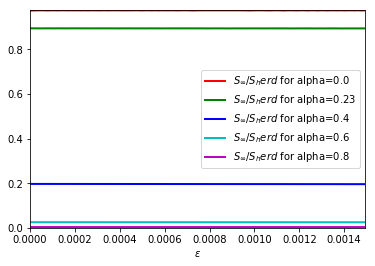

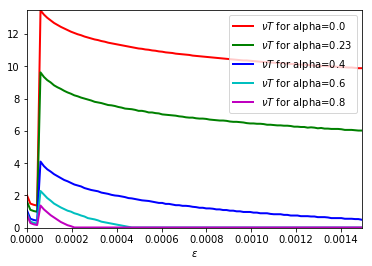

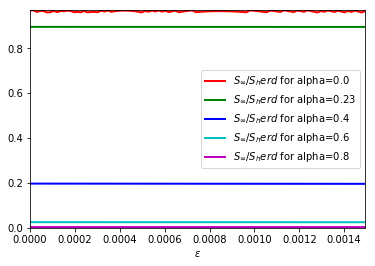

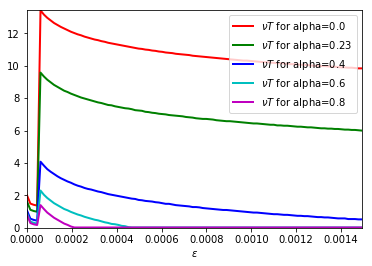

In [12]:
#graphique S infini et T en fonction de epsilon (figure 5-6)

# parameters
NT=int(5001) # number of time step
nb_eps = 100
min_eps = 10/N
max_eps = 100000/N
eps_array = np.linspace(min_eps,max_eps,nb_eps)
alpha_array=[0.0,alpha_conf,0.4,0.6,0.8]
D=100
h = D/NT        #the time step
color_plt=['r-','g-','b-','c-','m-','y-','b--','g--','r--']
color_tikz=['red','black!60!green','blue','black','yellow']


# Computation of T Sinf theoretical
S_inf_rel_theo_array =  np.zeros((len(eps_array),len(alpha_array)))
T_theo_array =  np.zeros((len(eps_array),len(alpha_array)))
for ind_alpha in range(len(alpha_array)):
    alpha = alpha_array[ind_alpha]
    for ind_eps in range(len(eps_array)):
        I0 = eps_array[ind_eps]
        Init=np.array([S0, I0,R0])
        print('I0',I0)
        print('alpha',alpha)
        print('##############################################')
        print('Iteration '+str(ind_eps+1)+'/'+str(len(eps_array))+' and '+str(ind_alpha+1)+'/'+str(len(alpha_array)))
        print('##############################################')
        S_inf, T, u, Jval, yval = exact_value_T(D,alpha,Init)
        print("T=",T)
        print('S_inf=',S_inf)
        S_inf_rel_theo_array[ind_eps,ind_alpha] = S_inf/S_herd
        T_theo_array[ind_eps,ind_alpha] = T

        
# Computation of T Sinf theoretical by dichotomy
T_dicho_array =  np.zeros((len(eps_array),len(alpha_array)))
S_inf_rel_dicho_array =  np.zeros((len(eps_array),len(alpha_array)))
for ind_alpha in range(len(alpha_array)):
    alpha = alpha_array[ind_alpha]
    for ind_eps in range(len(eps_array)):
        print('##############################################')
        print('Iteration J Num '+str(ind_eps+1)+'/'+str(len(eps_array))+' and '+str(ind_alpha+1)+'/'+str(len(alpha_array)))
        print('##############################################')
        I0 = eps_array[ind_eps]
        Init=np.array([S0, I0,R0])
        print('I0',I0)
        print('alpha',alpha)
        u, Jval, yval, T = optimSIR_dic(alpha,D,Init)
        S_inf = Dicho_S_inf(J(yval))
        T_dicho_array[ind_eps,ind_alpha] = T
        S_inf_rel_dicho_array[ind_eps,ind_alpha] = S_inf/S_herd
        print('J',np.round(Jval,3))
        print('T',T)
        print('S_inf',S_inf)
        plt.show()

nu_T_theo_array =  T_theo_array
nu_T_dicho_array =  T_dicho_array
for i in range(len(D_array)):
    nu_T_theo_array[i] = nu*T_theo_array[i]
    nu_T_dicho_array[i] = nu*T_dicho_array[i]


        
# post processing - resultats et figures
# Plot
plt.figure(1)
for ind_alpha in range(len(alpha_array)):
    plt.plot(eps_array,S_inf_rel_theo_array[:,ind_alpha],'{0}'.format(color_plt[ind_alpha]),linewidth=2,label=r'$S_\infty/S_herd$ for alpha={0}'.format(round(alpha_array[ind_alpha],2)))
plt.legend(loc='best')
plt.xlabel(r'$\epsilon$')
plt.axis([0, max(eps_array),0.0, np.max(S_inf_rel_theo_array)])
plt.savefig("fig5_simu_covid_S_infinity_relative_with_respect_to_eps_theo.png")
plt.figure(2)
for ind_alpha in range(len(alpha_array)):
    plt.plot(eps_array,nu_T_theo_array[:,ind_alpha],'{0}'.format(color_plt[ind_alpha]),linewidth=2,label=r'$\nu T$ for alpha={0}'.format(round(alpha_array[ind_alpha],2)))
plt.legend(loc='best')
plt.xlabel(r'$\epsilon$')
plt.axis([0, max(eps_array), 0.0, np.max(nu_T_theo_array)])
plt.savefig("fig6_simu_covid_nu_T_with_respect_to_eps_theo.png")
plt.figure(3)
for ind_alpha in range(len(alpha_array)):
    plt.plot(eps_array,S_inf_rel_dicho_array[:,ind_alpha],'{0}'.format(color_plt[ind_alpha]),linewidth=2,label=r'$S_\infty/S_herd$ for alpha={0}'.format(round(alpha_array[ind_alpha],2)))
plt.legend(loc='best')
plt.xlabel(r'$\epsilon$')
plt.axis([0, max(eps_array),0.0, np.max(S_inf_rel_dicho_array)])
plt.savefig("fig5_simu_covid_S_infinity_with_respect_to_eps_opt.png")
plt.figure(4)
for ind_alpha in range(len(alpha_array)):
    plt.plot(eps_array,nu_T_dicho_array[:,ind_alpha],'{0}'.format(color_plt[ind_alpha]),linewidth=2,label=r'$\nu T$ for alpha={0}'.format(round(alpha_array[ind_alpha],2)))
plt.legend(loc='best')
plt.xlabel(r'$\epsilon$')
plt.axis([0, max(eps_array), 0.0, np.max(nu_T_dicho_array)])
plt.savefig("fig6_simu_covid_nu_T_with_respect_to_eps_opt.png")
plt.show()


# Save the values for tikz
File = open('fig5_simu_covid_S_infinity_with_respect_to_eps.txt','w')
for ind_alpha in range(len(alpha_array)):
    File.write('\\addplot[color={0},opacity = 0.25,line width=1mm]'.format(color_tikz[ind_alpha]))
    File.write(' coordinates { ')
    write_to_file(File,eps_array,S_inf_rel_dicho_array[:,ind_alpha])
    File.write(' };\n\n')
    File.write('\\addplot[color={0}]'.format(color_tikz[ind_alpha]))
    File.write(' coordinates { ')
    write_to_file(File,eps_array,S_inf_rel_theo_array[:,ind_alpha])
    File.write(' };\n\n')
File.close()
File = open('fig6_simu_covid_nu_T_with_respect_to_eps.txt','w')
for ind_alpha in range(len(alpha_array)):
    File.write('\\addplot[color={0},opacity = 0.25,line width=1mm]'.format(color_tikz[ind_alpha]))
    File.write(' coordinates { ')
    write_to_file(File,eps_array,nu_T_dicho_array[:,ind_alpha])
    File.write(' };\n\n')
    File.write('\\addplot[color={0}]'.format(color_tikz[ind_alpha]))
    File.write(' coordinates { ')
    write_to_file(File,eps_array,nu_T_theo_array[:,ind_alpha])
    File.write(' };\n\n')
File.close()






